# Final Project Submission

Please fill out:
* Student name: Deztany Jackson
* Student pace: DS Flex
* Scheduled project review date/time: March 30, 2023
* Instructor name: Morgan Jones
* Blog post URL: Dmvinedata.com

# X-ray Image Predictions: Pneumonia or Normal

![Pnemonia Image](images/Pneumonia.jpeg)

# Summary

A local hospital wants to explore their image recognition options for pneumonia cases. They want eventually replace a few doctors due to staffing issues. They want to test it out for a trial version. Worldwide Pneumonia s is a deadly and expensive condition, especially for children and the elderly. Using Convultion Neural Networks, X-Ray images of Normal and Pneumonia patients, data scienties will attempt to build models that detect pneumonia with the goal of minimizing False Negatives (predicting no pneumonia, while there is). Because of the severity this is a main focus. <br>

 The dataset is from Chest X-Ray of "Normal" and "Pneumonia" images from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) with a total of 5856 .jpeg files.<br>
 
Based on the business goal and data, the main metrics will be Recall, F1-Score, and Loss, Accuracy will be secondary.<br>

There is a data imbalance between categories and splits. After the images are loaded, the Train and Validation images  are combined and then split 80/20 for each respective category (Normal, Pneumonia). This does not solve the data and split imbalance but improves the offset to support more accurate modeling evaluation metrics.<br>

Modeling was down over 10 iterations (including a Transfor Model) with Hyperparameter tweeks: (Batch Size, Epochs, Dropout, Activation, Class Weight). The best models had no False Negatives or False Positives with scores of 1. The chosen model had the smallest loss. <br>

Hospital Recommendations:
- Usage: The model is best as a learning tool and not an official diagnosis.
- Strategy: Use the model as an initial reviewer of the images.
- Staffing: The model is best used with a doctor, not standalone.

Technical Recommendations:
- Scope, review and process images more beforehand
- Visualize the activation functions to see better what areas the model layers are diagnosing
- Iterate model improvement with with augmented data
- Visually inspect the images that were FN and FP.

## Import Libraries

In [375]:
import os 
import glob 

#from google.colab import drive #Google Collab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow 

from tensorflow import keras
from tensorflow.keras.metrics import Accuracy,Precision,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import  VGG19 #Pretrained Transfer Modeling
from sklearn.utils.class_weight import compute_class_weight

from keras.preprocessing import image
from PIL import Image

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, f1_score, recall_score,accuracy_score, auc, log_loss
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight 

#Used to move files
import shutil

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
tf.__version__

# Stop Tensorflow errors from showing especially 
import logging
tf.get_logger().setLevel(logging.ERROR)

# Showing the areas of the image boundaries
import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
#Getting start time
original_start = datetime.datetime.now()


**The following modeling effort was developed on a Apple M2 Max 64GB computer. There may be tasks that may longer execute on other hardware**

# Data Understanding


The dataset is from Chest X-Ray of "Normal" and "Pneumonia" images from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) with a total of 5856 .jpeg files. This data set is already broken up into three folders (train, validation and test) and a folder for each category ("NORMAL" or "PNEUMONIA"). 

<b> Original Dataset Splits 
- Train [1341 NORMAL, 3875 PNEUMONIA]
- Validation [8 NORMAL, 8 PNEUMONIA]
- Test [234 NORMAL, 390 PNEUMONIA]
    
There is a data imbalance between categories and splits. After the images are loaded, the Train and Validation images  are combined and then split 80/20 for each respective category (Normal, Pneumonia). This does not solve the data and split imbalance but improves the offset to support more accurate modeling evaluation metrics.

**The original dataset is already split by the time this notebook is turned it. The following code will still work with the original dataset and previously shifted images**    

## Loading Images

Images are loaded from the current directory joined with the location of the datset. The python "glob" module [Glob, Tara Boyle, 2021](https://towardsdatascience.com/the-python-glob-module-47d82f4cbd2d) is used to retrieve files recursively. Without knowing all the file names "*" astericks are used in place to get all fo the files.

In [377]:
#Get Current directory
cur_dir = os.getcwd()
cur_dir

'/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4'

Understanding the total images split among the respective directories

In [399]:
#Retrieving dataset in the respective folders
train_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/**/*.jpeg'))
val_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/**/*.jpeg'))
test_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/**/*.jpeg'))

#Printing total number of images in different directories
print(f"Training Set has: {len(train_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print(f"Testing Set has: {len(test_data)} images")

Training Set has: 2679 images
Validation Set has: 907 images
Testing Set has: 624 images


Understanding the total categories (Normal and Pneumonia) split among the respective directories

---

### Initial Data Balancing 

The data splitting and moving will not solve the data imbalance for training, but supports better modeling metric evaluations. 
- Orinally started with 16 Validation Images
- Moving validation images to train set.
- Perform Random Train/Valid split 80/20 on Normal and Pneumonia images
- Move 20% of each back to validation folder

Retrieves Normal and Pneumonia specific images for each dataset

In [376]:
#Pulling in Normal and Pneumonia specific data 

#Training Data
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
#Validation Data
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
#Test Data
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/PNEUMONIA/*.jpeg'))

<b> Moving and Splitting Files (If Necessary)

Moving the validation data to the respective Normal and Pneumonia Training folders if the amount of files in the folders are less than 20 (This number is arbitrary). . If so, there will be a 80/20 split of the data and then the 20% of files are moved back to the respective Validation folder. The original dataset had 8 images per folder. The goal is to only move files if there is an huge value offset.  If not, then the files don't need to move.

In [ ]:
if len(v_pneu) < 20 | len(v_norm) < 20: # Only perform action if validation folders have a certain amount of images
    #Moving Validation to Test
    cat = [v_norm,v_pneu]
    for c in cat:
        if c == v_norm:
            images = [f for f in v_norm if '.jpeg' in f.lower()] 
            for img in images:
                new_path = os.path.join(cur_dir,"data/chest_xray/train/NORMAL/")
                shutil.move(img,new_path)
        elif c == v_pneu:
            images = [f for f in v_pneu if '.jpeg' in f.lower()] 
            for img in images:
                new_path = os.path.join(cur_dir,"data/chest_xray/train/PNEUMONIA/")
                shutil.move(img,new_path)
        else:
            pass
        
        #Splitting the data 80/20 for the Normal and Pnuemonia categories. 
        #Moving the 20% split to the respective Validation directories.
    train_cat = [t_norm,t_pneu]
    for cat in train_cat:
        train,val = train_test_split(cat, train_size=.8, random_state=42)
        if cat == t_norm:
            for img in val:
                new_path = os.path.join(cur_dir,"data/chest_xray/val/NORMAL/")
                shutil.move(img,new_path)
        elif cat == t_pneu:
            for img in val:
                new_path = os.path.join(cur_dir,"data/chest_xray/val/PNEUMONIA/")
                shutil.move(img,new_path)
        else:
            pass
else: #If validation folders doesnt have less than 20 images then don't do anything
    pass

In [6]:
#Printing Dataset values 

#Totals for Training, Validation and Testing
print(f"Training Set has: {len(train_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print("\n")
#Training Data
print(f"Training Pneumonia Amount: {len(t_pneu)} images")
print(f"Training Normal Amount: {len(t_norm)} images")
print(f"Training Normal to Pneumonia Ratio: {round(len(t_norm)/len(t_pneu),2)}")
print("\n")
#Validation Data
print(f"Validation Pneumonia Amount: {len(v_pneu)} images")
print(f"Validation Normal Amount: {len(v_norm)} images")
print(f"Validation Normal to Pneumonia Ratio: {round(len(v_norm)/len(v_pneu),2)}")

Training Set has: 4325 images
Validation Set has: 907 images
Testing Set has: 624 images


Training Pneumonia Amount: 3210 images
Training Normal Amount: 1115 images
Training Normal to Pneumonia Ratio: 0.35


Validation Pneumonia Amount: 673 images
Validation Normal Amount: 234 images
Validation Normal to Pneumonia Ratio: 0.35


**There is still imbalance but better offset.**

---

### Normal and Pneumonia Images

Displaying 10 of the first images in the Normal and Pneumonia Training folders. ".imread()" method reads images from file into an array. All the images will be displayed a grid to show size and in the color gray.

<b> NORMAL IMAGES

Sample of Normal Pictures


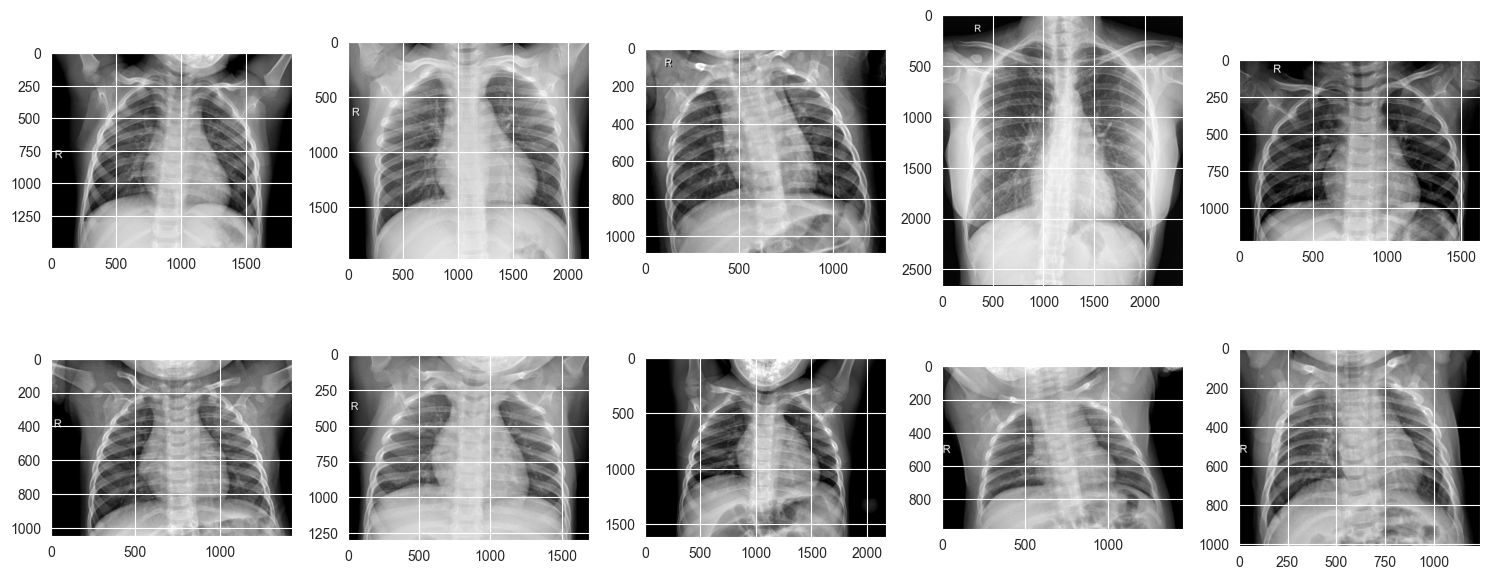

In [393]:
#Plotting 10 images from the train folder
plt.figure(figsize = (15,15))
print ("Sample of Normal Pictures")
for i in range(10):
    plt.subplot(5,5,i+1)
    #Reads images from file into an array
    img = plt.imread(t_norm[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
plt.savefig('images/Img_Norm.png')

<b> NORMAL PIXEL INTENSITY

Displaying pixel intensity associated with the plotted images

Associated Normal Pixel Intensities


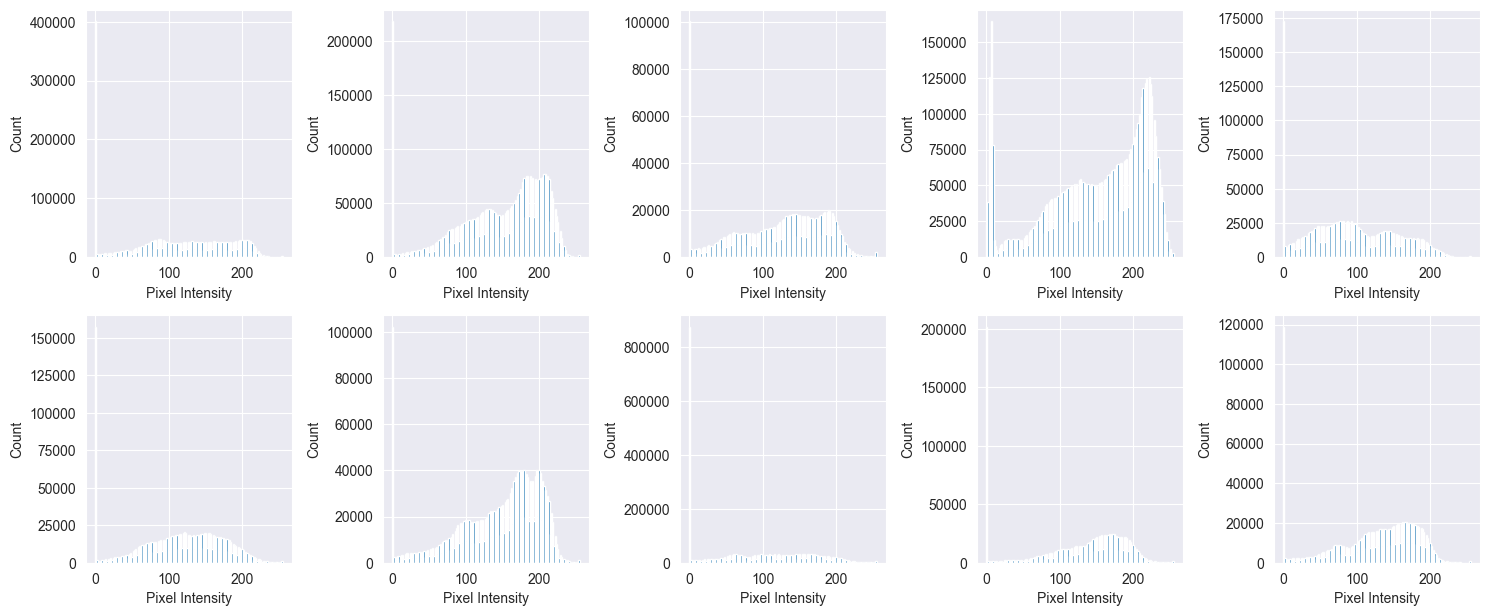

In [392]:
#Plotting 10 image pixels from the train folder
plt.figure(figsize = (15,15),facecolor="White")
print ("Associated Normal Pixel Intensities")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_norm[i])
    plt.hist(img.ravel(), bins=150)
    plt.tight_layout()
    plt.ylabel("Count")
    plt.xlabel("Pixel Intensity")
plt.savefig('images/Hist_Norm.png')
    #plt.axis('off')

---

<b> PNEUMONIA IMAGES

Sample of Random Pneumonia Pictures


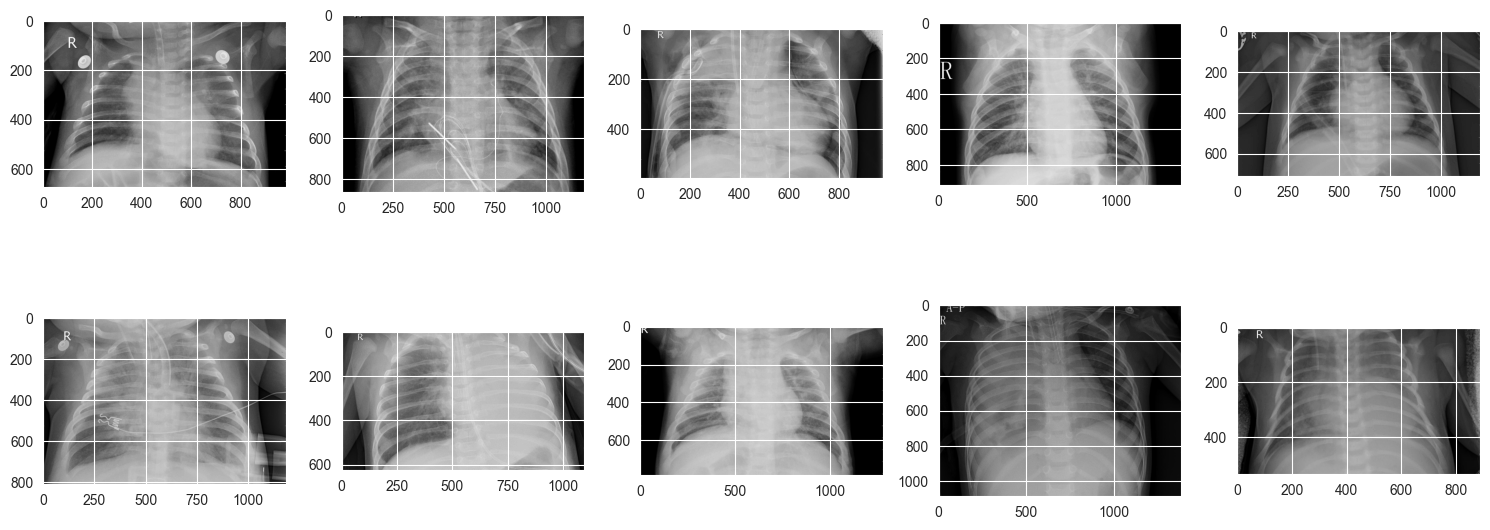

In [391]:
plt.figure(figsize = (15,15))
print ("Sample of Random Pneumonia Pictures")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_pneu[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
plt.savefig('images/Img_Pneu.png')
    #plt.axis('off')

Visually, both the Normal and Pneumonia pictures vary in size. Pneumonia pictures have a cloudier visual look.

<b> PNEUMONIA PIXEL IMAGES

Displaying pixel intensity associated with the plotted images.

Associated Pneumonia Pixel Intensities


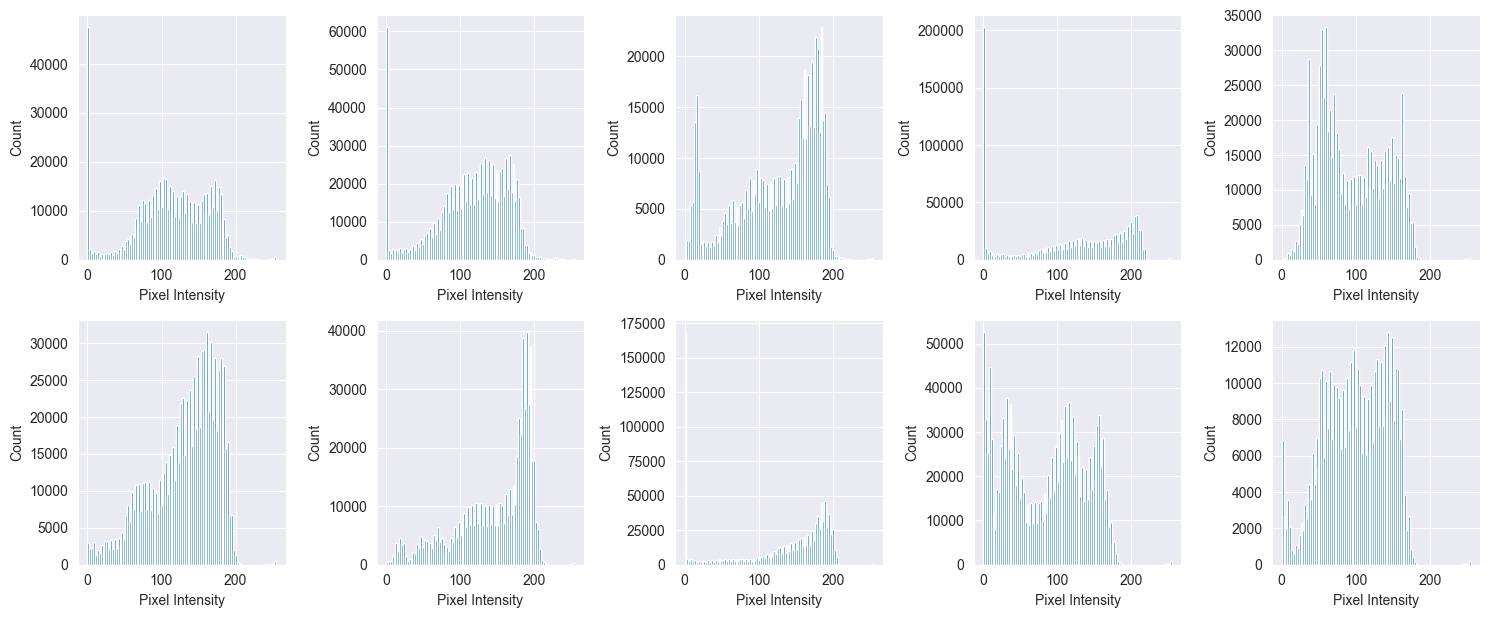

In [390]:
plt.figure(figsize = (15,15),facecolor="White")
print ("Associated Pneumonia Pixel Intensities")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_pneu[i])
    plt.hist(img.ravel(), bins=100)
    plt.tight_layout()
    plt.ylabel("Count")
    plt.xlabel("Pixel Intensity")
plt.savefig('images/Hist_Pneu.png')
    #plt.axis('off')

It appears the pixel intensity is more with Pneumonia.

---

## Preprocessing Images

**Rescaling the image**  [Rescaling](https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation#:~:text=As%20rightly%20pointed%20out%20by,evenly%20to%20the%20total%20loss)

For the intial dataset, the only preprocessing will be rescaling, creating target size and scoping the batch size. Further data augmentation will be done during the modeling.

### Image Generator

Generating batches of tensor image data with real-time data augmentation.

In [13]:
#ImageDataGenerator without pre data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Creating directories for augmentation.  The subdirectories will be understood by the operation.

In [14]:
#Create Current Directories
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'

With the tensor image data and directory we will generate batches of augmented data.<br>


**Describe:**
- **Target Size** - Dimensions the images will be resized to
- **Batch Size** - Size of batches of data
- **Classes** - Class names 
- **Class Mode** -  "Binary" 1D Binary labels
- **Shuffle** -  Sorts data in a random matter, Default is True. 
- **Seed** - Random seed for shuffling

In [15]:
#Using a generator for the images to work with.
train_gen = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=64,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   seed = 42)

val_gen = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42)
#Testing data will be used on Final Model only
test_gen = test_datagen.flow_from_directory(test_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 624,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42,
                                                      shuffle= False)                                                      

Found 4325 images belonging to 2 classes.
Found 907 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
#Checking the class label and index match
print(train_gen.class_indices)
print(val_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


Iterating through the generated images.
X and y are the images and labels respectively. It is a sample equal to the batch size above.

In [233]:
X_train, y_train = next(train_gen)
X_val, y_val = next(val_gen)
X_test, y_test = next(test_gen)

print("X_train:",len(X_train),"y_train:",len(y_train))
print("X_val:",len(X_val),"y_val:",len(y_val))
print("X_test:",len(X_test),"y_test:",len(y_test))

X_train: 64 y_train: 64
X_val: 32 y_val: 32
X_test: 624 y_test: 624


# Modeling


### Custom Functions for Model Evaluation


[Visualization Metrics,A.Jang 2023](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays#8.-Visualizing-model-performance)

In [305]:
#Create a new directory for saved files
directory = "saved_files"
save_path = os.path.join(cur_dir,directory)
try: 
    os.mkdir(save_path) 
except OSError as error: 
    print(error)

[Errno 17] File exists: '/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4/saved_files'


In [19]:
#Using Pickle in a function to save files
def save_file(name,file):
    """ Saving file to a specific directory using pickle"""
    saved_name = os.path.join(save_path,name)
    with open(saved_name, 'wb') as f:
        pickle.dump(file, f)


In [20]:
#loading Pickle Files
def load_file(name):
    """ Loading file from a specific directory using pickle"""
    saved_name = os.path.join(save_path,name)
    with open(saved_name, 'rb') as f:
        file = pickle.load(f)
    return file

In [21]:
#Printing metric subplots of training and validation per epoch
def eval_metrics(history):
    """ Plots Train and Validation metrics["acc","loss","recall","precision"]
    from a model's evaluation results."""
    
    fig, ax = plt.subplots(1,4, figsize = (25,5))
    fig.suptitle('Model Metrics Results')
    
    metrics = ["loss","recall","acc","precision"]   
    
    for i, metric in enumerate(metrics):
    
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title('Model {}'.format(metric))
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel("Epochs")
        ax[i].legend(['train', 'val'])

        

[Predictor Algorithm with Shuffle,by Jakob, 2021](https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator/67282636#67282636)

In [22]:
def predict_results(model,generator):
    """Generates prediction results and true labels from a specific model and specific data set. 
    This formula works well for shuffled generated data."""
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
        return labels, predictions #y_true, y_hat_train/y_pred

In [23]:
def conf_matrix(y_true,y_pred, norm_bool):
    """Prints confusion matrix for the Normal and Pneumonia true and predicted values. """
    y_pred = np.round(y_pred,0) #Rounding to the nearest 0 or 1, assumes threshold is >.5 for
    cmatrix= cm(y_true, y_pred, normalize=norm_bool)# Allows normalized matrix
    matrix_disp= ConfusionMatrixDisplay(cmatrix, display_labels= ["NORMAL", "PNUEMONIA"])
    matrix_disp.plot()

    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Model Confusion Matrix')
    plt.show()
    

In [197]:
def eval_report(y_true, y_pred,gen,history):
    """ Displaying the classification report and loss from the model results"""
    y_pred = np.round(y_pred,0) # Rounding to the nearest 0 or 1
    #Display Precision, Recall, F1 and Accuracy
    print(classification_report(y_true, y_pred, digits = 3))
    print('\n')
    
    #Display Model Metrics
    loss, _,_,_ = history.model.evaluate(gen)
                   
    print(f'Loss: {np.round(loss,4)}')
   


In [35]:
# set up the class weights using y_train
def calc_weight(labels):
    """ Setting the weights and pairing it with the classes for the class weight paramters in model.fit. 
    Labels can also be thought of as y_train"""
    classes = [0,1]
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = dict(zip(classes, weights))
    return class_weights

### The following is the outline of each model iteration:

- Sequence <br>
- Compile <br>
- Summary <br>
- Fit <br>
- Predict <br>
- Conf_matrix <br>
- Eval report <br>
- Model Evaluation <br>

Each iteration will have slight changes for improvement.  They will be described more at the
General descriptions of specific iterations.

### The main metrics focused on are:
- **Recall, F1 Score, Loss (Primary)** <br>
- **and Accuracy (Secondary)**<br>

Because the goal is to minimized False Negatives of Pneumonia (predicting no Pneumonia, while there is). 
The True Positives will be looked at secondary.

There are a total of 10* model iterations with a Final Model. The model iterations are trained on the training data and tested on validation data. Both the training and validation data metrics will be displayed.

The Final Model will be chosen based on the main metrics. This final model will be used with the test data. 


### Main Hyperparameters & Parameters

[NN Hyperparameters, Rukshan P, 2022](https://towardsdatascience.com/classification-of-neural-network-hyperparameters-c7991b6937c3)
- **Model**
    - layers: 
        - Conv2D:
        - MaxPooling2D:
        - Dense output:
    - filters:
    - activation: 
        - Relu 
        - Sigmoid: 
    - dropout: Regularization technique that supports overfitting. Smaller network allows parameters to update  more.
- **Model Compile**
    - loss: 
        - binary_crossentropy 
    - optimizer: 
        - adam
    - learning rate: 
- **Fit**
    - batchsize: 
    - epochs: 
    - early stopping: After convergence, stopping the training process after the validation and training error diverge  
    - class weights:
    

# Baseline Modeling (1)

Description of the main model hyperparameters and data parameters:

- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - epochs: 10
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs


In [25]:
# Baseline Model Stack
baseline = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='relu'),    
Dense(units=1, activation='sigmoid'),
])

#Compile Model
baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

Metal device set to: Apple M2 Max


2023-03-28 22:08:54.318853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 22:08:54.319104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The model summary provides a description of the sequential Layers, Output Shapes and Learning Parameters.

In [45]:
#Display model summary ()
baseline.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 96)       0

Returning a model object that contains model evaluation metrics, and hyperparameter attributes

In [26]:
#Fiting the data
history = baseline.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       validation_data=val_gen)

Epoch 1/10


2023-03-28 22:09:14.361758: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-28 22:09:14.673991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 22:09:37.361368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 29s - loss: 0.3879 - acc: 0.8509 - recall: 0.9115 - precision: 0.8902 - val_loss: 0.1003 - val_acc: 0.9669 - val_recall: 0.9866 - val_precision: 0.9693 - 29s/epoch - 421ms/step
Epoch 2/10
68/68 - 27s - loss: 0.1125 - acc: 0.9575 - recall: 0.9713 - precision: 0.9713 - val_loss: 0.0975 - val_acc: 0.9570 - val_recall: 0.9510 - val_precision: 0.9907 - 27s/epoch - 404ms/step
Epoch 3/10
68/68 - 25s - loss: 0.1107 - acc: 0.9595 - recall: 0.9695 - precision: 0.9759 - val_loss: 0.0879 - val_acc: 0.9724 - val_recall: 0.9881 - val_precision: 0.9751 - 25s/epoch - 366ms/step
Epoch 4/10
68/68 - 25s - loss: 0.0653 - acc: 0.9776 - recall: 0.9819 - precision: 0.9878 - val_loss: 0.0569 - val_acc: 0.9824 - val_recall: 0.9896 - val_precision: 0.9867 - 25s/epoch - 370ms/step
Epoch 5/10
68/68 - 25s - loss: 0.0456 - acc: 0.9838 - recall: 0.9879 - precision: 0.9903 - val_loss: 0.0618 - val_acc: 0.9802 - val_recall: 0.9822 - val_precision: 0.9910 - 25s/epoch - 365ms/step
Epoch 6/10
68/68 - 25s - loss: 

<b> Baseline Metrics

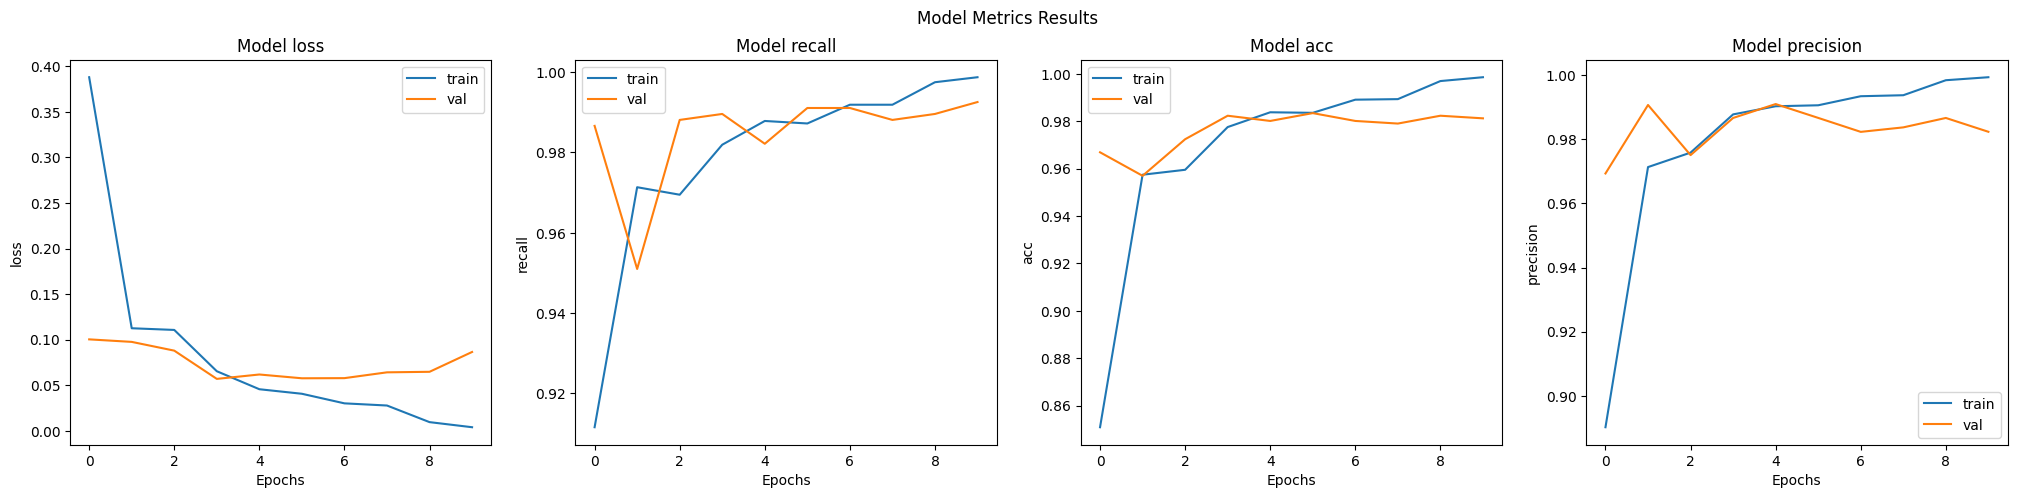

In [28]:
#Plotting chosen Train and Validation Metrics
eval_metrics(history)

In [191]:
#Returns Train and Validation labels and predictions
train_labels, train_predictions = predict_results(baseline,train_gen)
val_labels, val_predictions = predict_results(baseline,val_gen)

1/1 [==============================] - 0s 15ms/step


Training Confusion Matrices:



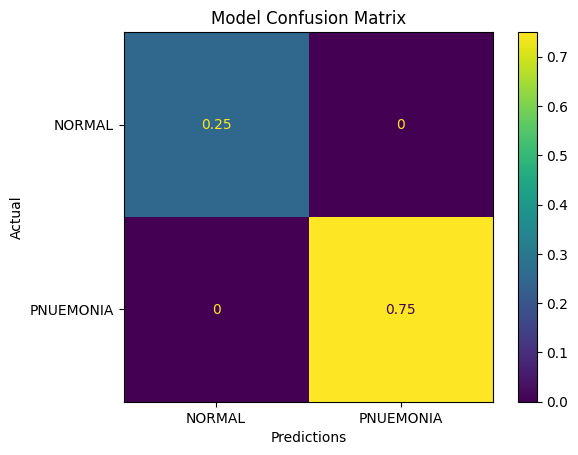

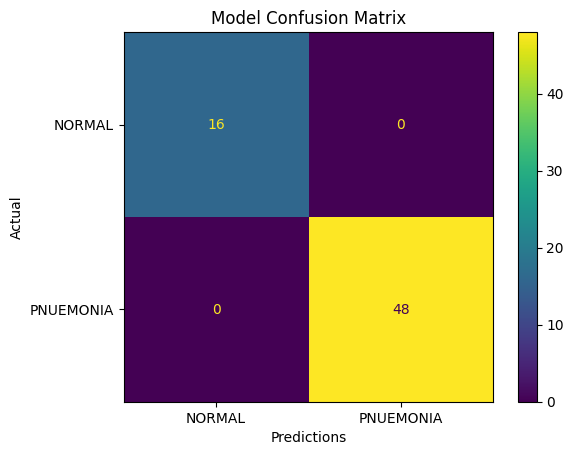

Validation Confusion Matrices:



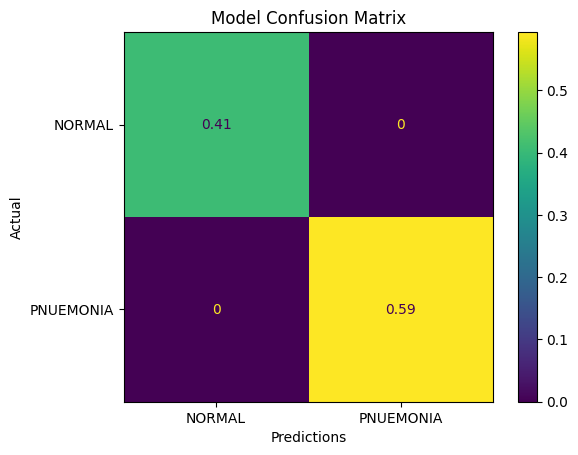

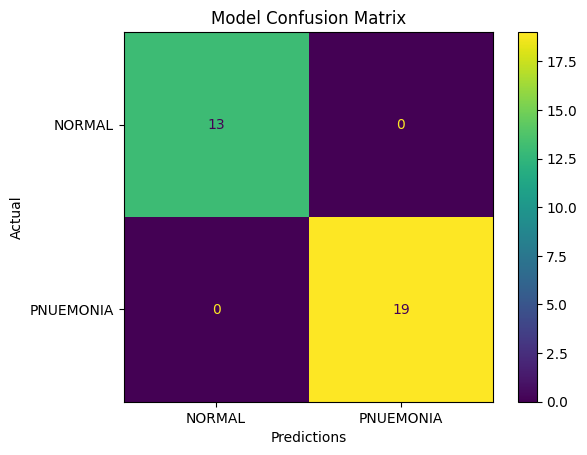

In [30]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, "all")
conf_matrix(train_labels,train_predictions, None)
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, "all")
conf_matrix(val_labels, val_predictions, None)

In [198]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000        17
         1.0      1.000     1.000     1.000        47

    accuracy                          1.000        64
   macro avg      1.000     1.000     1.000        64
weighted avg      1.000     1.000     1.000        64



68/68 [==============================] - 21s 311ms/step - loss: 0.0021 - acc: 0.9995 - recall: 1.0000 - precision: 0.9994
Loss: 0.0021


In [32]:
#Validation Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        19

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



29/29 [==============================] - 4s 149ms/step - loss: 0.0865 - acc: 0.9813 - recall: 0.9926 - precision: 0.9824
Loss: 0.0865


### Baseline (1) Model Evaluation

- Model Plots: The baseline model is actually really good. There is slight variation and divergence but that may be due to the limited epochs.
- Condusion Matrix: With the current batch size and imbalanced data, the model predicted everything as true, even on the training set. This led to no False Negatives, but many False Positives. This is with the validation model having 40% Normal images.
- Report: The loss in the validation model is only slightly worse than the training model.
- The is a solid model. ThereTo help with the lingering data balance, we will work to improve that.

---

# Baseline Model (2) with Class Weights 

Change Description: 
- Adding class weights to see it helps with class imbalance.

Description of the model hyperparameters and data parameters:


- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - epochs: 10
    - **Added class weights**: {0: 1.6, 1: 0.7272727272727273}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [33]:
# Baseline Model Stack
baseline2 = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='relu'),    
Dense(units=1, activation='sigmoid'),
])

#Compile Model
baseline2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

Calculating class weights help to balance the dataset by weighting respecively.

In [36]:
#Calculating class weights for imbalance
class_weights = calc_weight(y_train)
class_weights


{0: 1.6, 1: 0.7272727272727273}

In [37]:
#Fitting the data on the baseline model with class weight
history2 = baseline2.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen)

Epoch 1/10


2023-03-28 22:18:01.775455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 22:18:23.311449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 26s - loss: 0.3605 - acc: 0.8476 - recall: 0.8530 - precision: 0.9361 - val_loss: 0.1322 - val_acc: 0.9526 - val_recall: 0.9495 - val_precision: 0.9861 - 26s/epoch - 386ms/step
Epoch 2/10
68/68 - 25s - loss: 0.1163 - acc: 0.9545 - recall: 0.9558 - precision: 0.9824 - val_loss: 0.1033 - val_acc: 0.9559 - val_recall: 0.9450 - val_precision: 0.9953 - 25s/epoch - 369ms/step
Epoch 3/10
68/68 - 26s - loss: 0.0876 - acc: 0.9690 - recall: 0.9701 - precision: 0.9879 - val_loss: 0.0550 - val_acc: 0.9779 - val_recall: 0.9881 - val_precision: 0.9823 - 26s/epoch - 386ms/step
Epoch 4/10
68/68 - 26s - loss: 0.0585 - acc: 0.9778 - recall: 0.9773 - precision: 0.9927 - val_loss: 0.0607 - val_acc: 0.9757 - val_recall: 0.9777 - val_precision: 0.9895 - 26s/epoch - 380ms/step
Epoch 5/10
68/68 - 25s - loss: 0.0516 - acc: 0.9815 - recall: 0.9794 - precision: 0.9956 - val_loss: 0.0787 - val_acc: 0.9735 - val_recall: 0.9688 - val_precision: 0.9954 - 25s/epoch - 371ms/step
Epoch 6/10
68/68 - 26s - loss: 

In [38]:
#Baseline2 Summary
baseline2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 96)      

Basline Evaluation Metrics w/ Class Weights :



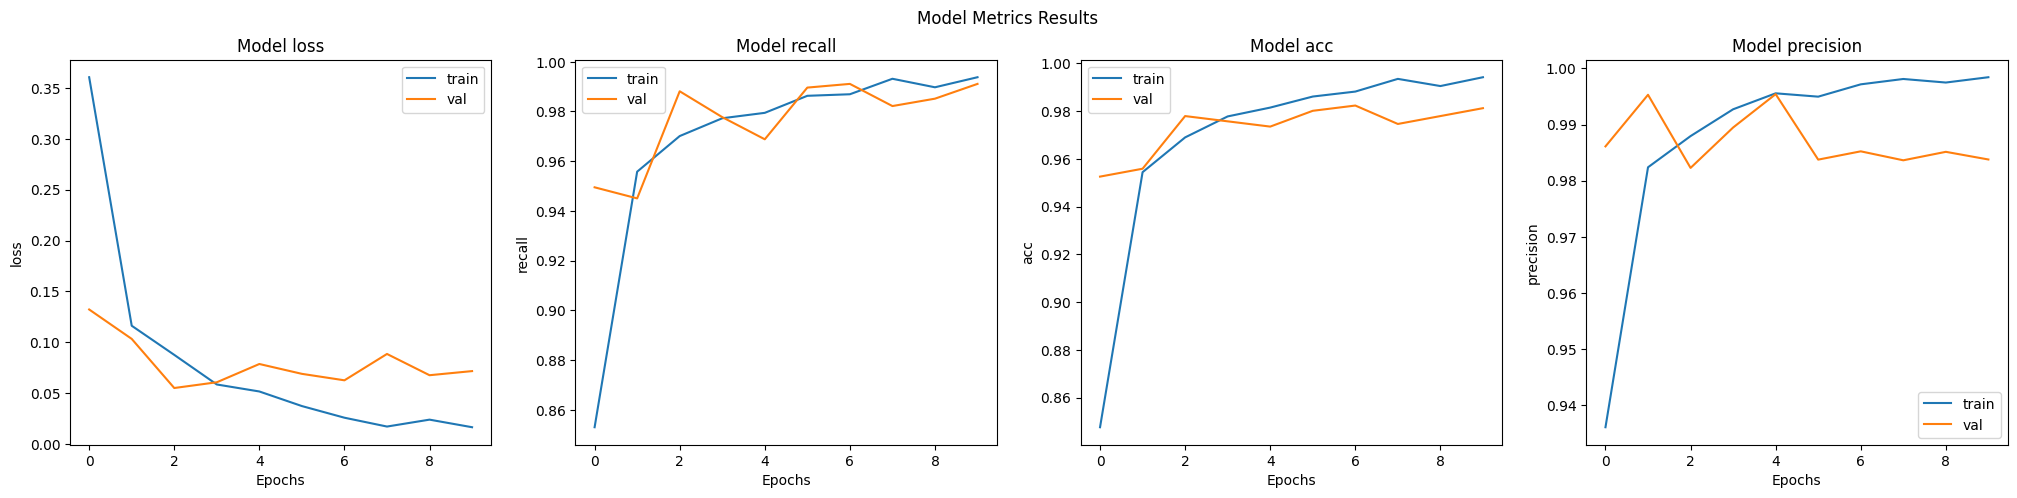

In [39]:
print("Basline Evaluation Metrics w/ Class Weights :\n")
eval_metrics(history2)

In [41]:
#Returns Train and Validation labels and predictions
train_labels, train_predictions = predict_results(baseline2,train_gen)
val_labels, val_predictions = predict_results(baseline2,val_gen)

2/2 [==============================] - 0s 102ms/step


2023-03-28 22:24:48.666988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 18ms/step


Training Confusion Matrices:



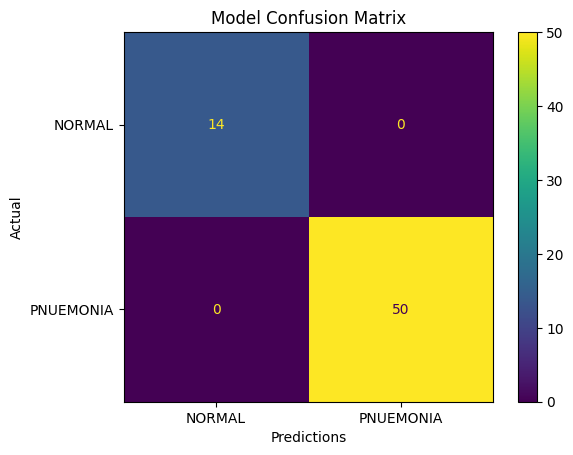

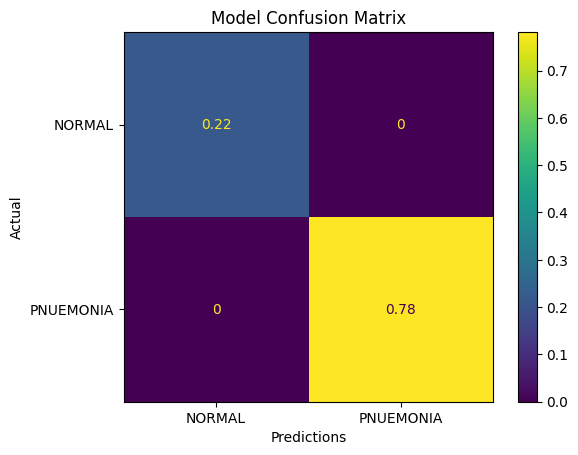

Validation Confusion Matrices:



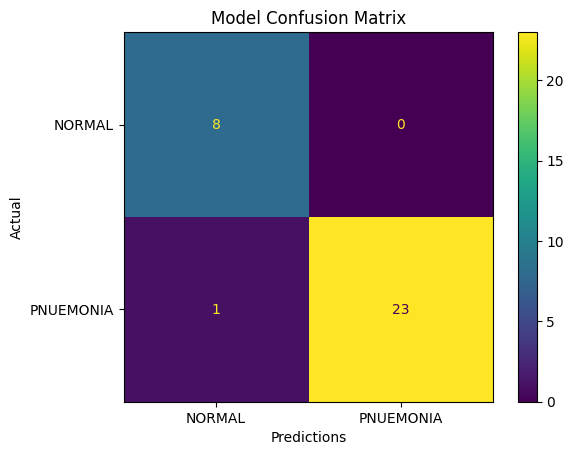

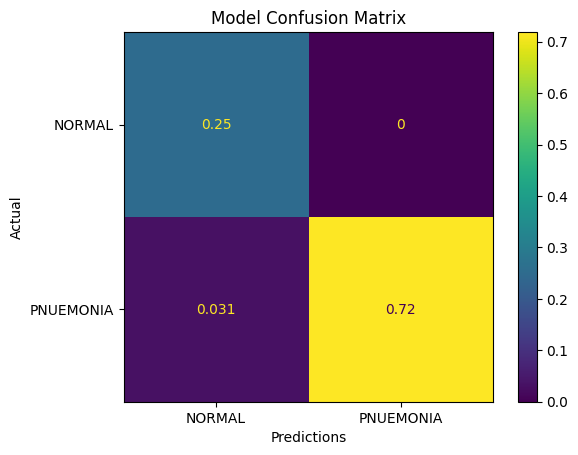

In [42]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [43]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history2)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



68/68 [==============================] - 21s 303ms/step - loss: 0.0042 - acc: 0.9995 - recall: 0.9994 - precision: 1.0000
Loss: 0.0042


In [44]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history2)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.96      0.98        24

    accuracy                           0.97        32
   macro avg       0.94      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



29/29 [==============================] - 4s 149ms/step - loss: 0.0717 - acc: 0.9813 - recall: 0.9911 - precision: 0.9838
Loss: 0.0717


### Baseline (2) Model Evaluation

- Model Plots: Slight improvement with the class weight. The recall and accuracy do not diverge as much. 
- Confusion Matrix: There is one FN with the validation set and no False Positives. The validation set had 25% Normal images this time.
- Report: The loss in the validaiton set decreased from the previous model, but slightly higher than the current training set
- Ths model wasn't bad either. The loss decreased but the amounf of FN increased.. The validation and training set are getting comparable results. The next models will add and tweek some hyperparameters to see if we can improve.

---

# Model Iteration 3

Change Description: 
- Increase Epochs, Adding EarlyStop and Dropout between Dense layers

Description of the model hyperparameters and data parameters:


- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - **dropout**: .3
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - **epochs**: 30
    - **early stopping** : True
    - class weights: {0: 1.6, 1: 0.7272727272727273}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [52]:
#Model 3 Sequential Layers
model_3= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='relu'), 
Dropout(0.3),  
Dense(units=1, activation='sigmoid'),
])
#Compile model
model_3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

Early stopping allows the execution of the model fitting to stop when the model has stopped improving.

In [50]:
#Adding early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [53]:
history3 = model_3.fit(train_gen,
                       epochs=30,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es)

Epoch 1/30


2023-03-28 22:54:01.175345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 22:54:22.717240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 27s - loss: 0.3631 - acc: 0.8400 - recall: 0.8470 - precision: 0.9312 - val_loss: 0.1341 - val_acc: 0.9515 - val_recall: 0.9941 - val_precision: 0.9436 - 27s/epoch - 391ms/step
Epoch 2/30
68/68 - 26s - loss: 0.1335 - acc: 0.9531 - recall: 0.9558 - precision: 0.9805 - val_loss: 0.0760 - val_acc: 0.9746 - val_recall: 0.9792 - val_precision: 0.9865 - 26s/epoch - 386ms/step
Epoch 3/30
68/68 - 26s - loss: 0.0917 - acc: 0.9660 - recall: 0.9651 - precision: 0.9888 - val_loss: 0.0737 - val_acc: 0.9735 - val_recall: 0.9733 - val_precision: 0.9909 - 26s/epoch - 378ms/step
Epoch 4/30
68/68 - 26s - loss: 0.0827 - acc: 0.9683 - recall: 0.9688 - precision: 0.9882 - val_loss: 0.0676 - val_acc: 0.9779 - val_recall: 0.9881 - val_precision: 0.9823 - 26s/epoch - 381ms/step
Epoch 5/30
68/68 - 26s - loss: 0.0680 - acc: 0.9750 - recall: 0.9741 - precision: 0.9921 - val_loss: 0.0579 - val_acc: 0.9791 - val_recall: 0.9866 - val_precision: 0.9852 - 26s/epoch - 381ms/step
Epoch 6/30
68/68 - 26s - loss: 

In [54]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 28, 28, 96)      

Model 3: Dropout, EarlyStopping and 30 Epochs :



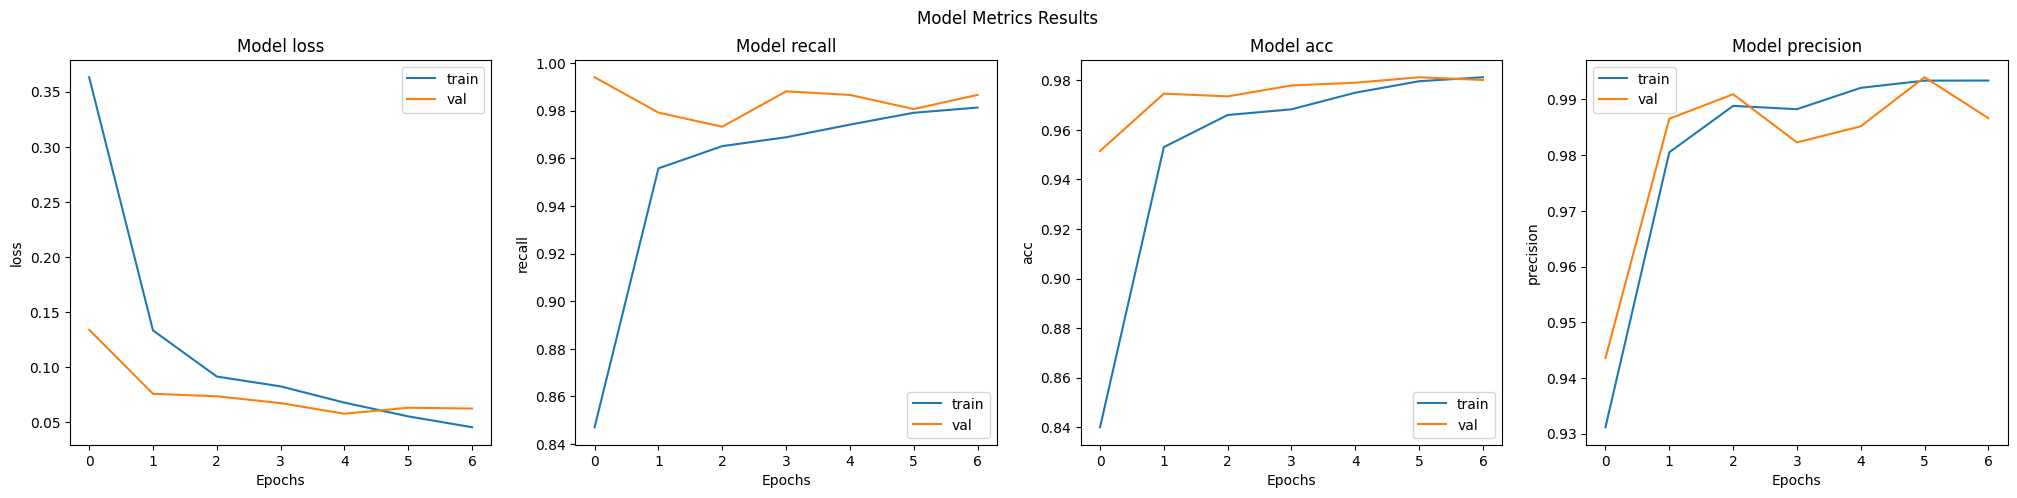

In [55]:
print("Model 3: Dropout, EarlyStopping and 30 Epochs :\n")
eval_metrics(history3)

In [56]:
train_labels, train_predictions = predict_results(model_3,train_gen)
val_labels, val_predictions = predict_results(model_3,val_gen)

2/2 [==============================] - 0s 88ms/step


2023-03-28 23:08:19.071574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


Training Confusion Matrices:



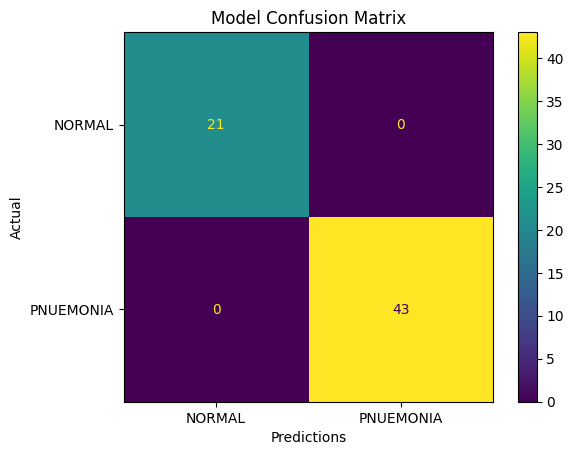

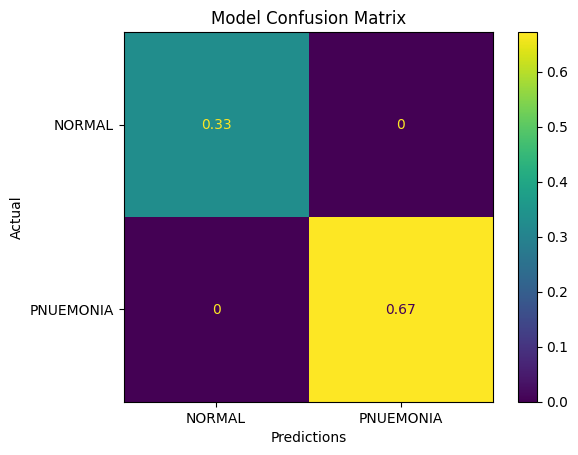

Validation Confusion Matrices:



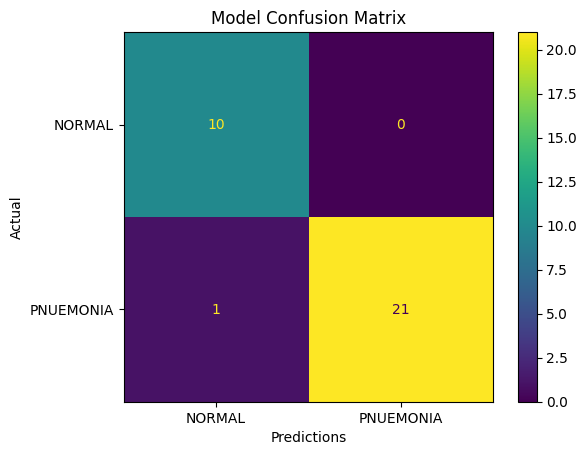

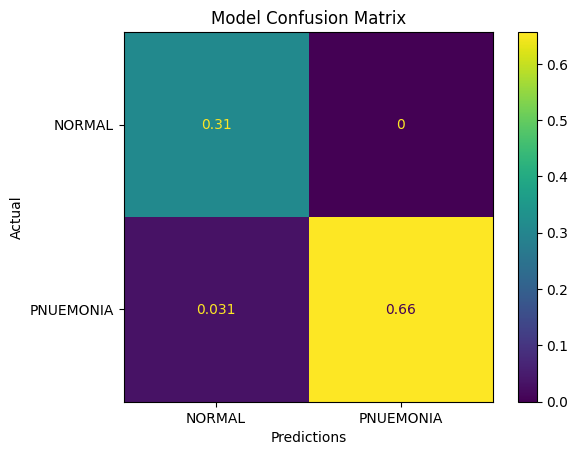

In [57]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [58]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history3)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         1.0       1.00      1.00      1.00        43

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



68/68 [==============================] - 21s 304ms/step - loss: 0.0302 - acc: 0.9894 - recall: 0.9866 - precision: 0.9991
Loss: 0.0302


In [59]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history3)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.95      0.98        22

    accuracy                           0.97        32
   macro avg       0.95      0.98      0.96        32
weighted avg       0.97      0.97      0.97        32



29/29 [==============================] - 4s 149ms/step - loss: 0.0626 - acc: 0.9802 - recall: 0.9866 - precision: 0.9866
Loss: 0.0626


### Model 3 Evaluation

- Model Plots: The validation data seems to be fitting well.
- Confusion Matrix: There is one FN. 
- Report: The validation loss is slightly more than the training model. The amount of Normal Validation images decreased to about 30%. This could have lead to slightly lower scores.
- It isn't clear what to improve, optimizing this model with gridsearch will be the next step.

---

# Model Iterations 4-7 
**These models will use  Keras wrappers amd GridsearchCV to optimize various hyperparameters in the models. The best parameters will be applied along to the model.**

---

# Model 4 

Using gridsearch and keras wrappers to do some hyperparameter optimization
- **batch_size = [32,64,96,128]**
- **epochs = [30,45,60,90]**

Description of the model hyperparameters and data parameters:


- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - dropout: .3
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - **train batchsize:** 128
    - **epochs:** 90
    - early stopping : True
    - class weights: {0: 1.6, 1: 0.7272727272727273}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [60]:
# Creating a function to supply to the Keras wrapper
def buildModel():

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
        
    Flatten(),
    Dense(units=64, activation='relu'), 
    Dropout(0.3),  
    Dense(units=1, activation='sigmoid'),])

    model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=["acc","Recall","Precision"]
                 )
    return model

Choosing hyperparameters range to optimize. Being mindful of hardware and software resources.

In [61]:
#Choosing Paramers for Optimization
batch_size = [32,64,96,128]
epochs = [30,45,60,90]
parameters = dict(batch_size=batch_size, epochs=epochs )


In [62]:
#Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

[GridSearchCV with CNN, Aaryn Dhore, 2020](https://www.kaggle.com/code/aaryandhore/neural-network-gridsearchcv-explanations/notebook)<br>
[GridSearch for Deep Learning, J. Brownlee, 2022](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

KerasClassifier creates a classifier from the Model Sequence build model to use as an estimator. The created parameters will be used as the parameters in the Gridsearch to help optimize.

In [63]:
#Creating a wrapped classifier
classifier = KerasClassifier(build_fn=buildModel, class_weight = class_weights)

#Gridsearch Creating 
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
#Fitting Gridsearch
gs = grid_search.fit(X_train, y_train, verbose = 0)

2023-03-28 23:22:21.117278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 49ms/step


2023-03-28 23:22:24.185717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:22:24.695543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 48ms/step


2023-03-28 23:22:27.604357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:22:28.144039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s

2023-03-28 23:22:31.080631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 51ms/step


2023-03-28 23:22:31.638642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 51ms/step


2023-03-28 23:22:35.912222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:22:36.742283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 47ms/step


2023-03-28 23:22:41.030011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:22:41.553746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:22:46.042499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:22:46.624696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 73ms/step


2023-03-28 23:22:51.938175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:22:52.470417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:22:58.026284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:22:58.886253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 86ms/step


2023-03-28 23:23:04.533056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 155ms/step


2023-03-28 23:23:05.305902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:13.092489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 64ms/step


2023-03-28 23:23:13.690703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:21.945496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 65ms/step


2023-03-28 23:23:22.545679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:30.740171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step


2023-03-28 23:23:31.589272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:34.314163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 60ms/step


2023-03-28 23:23:34.848362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:37.788012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:23:38.347591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:40.962197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:23:41.511744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:45.002121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 70ms/step


2023-03-28 23:23:46.020205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:49.622820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step


2023-03-28 23:23:50.170343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:53.854522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:23:54.391458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:23:58.989653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 64ms/step


2023-03-28 23:23:59.547357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:04.095490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 62ms/step


2023-03-28 23:24:04.911569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:09.668506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 62ms/step


2023-03-28 23:24:10.215144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 83ms/step


2023-03-28 23:24:16.460103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 153ms/step


2023-03-28 23:24:17.204814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:23.687980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 58ms/step


2023-03-28 23:24:24.241472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:30.869916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 56ms/step


2023-03-28 23:24:31.677031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:34.269920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:24:34.832803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:37.700338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 65ms/step


2023-03-28 23:24:38.278840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:40.962771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 64ms/step


2023-03-28 23:24:41.519359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:45.041049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 73ms/step


2023-03-28 23:24:45.586645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:49.667007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 62ms/step


2023-03-28 23:24:50.215965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:53.885787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:24:54.434894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:24:59.174695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 59ms/step


2023-03-28 23:24:59.722496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:04.379341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 70ms/step


2023-03-28 23:25:05.196127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:10.043550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 65ms/step


2023-03-28 23:25:10.610517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:16.918543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:25:17.479704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:24.189697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step


2023-03-28 23:25:24.757414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:31.522734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 67ms/step


2023-03-28 23:25:32.351215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:34.987198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 62ms/step


2023-03-28 23:25:35.558233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:38.371663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:25:38.977231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:41.933027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step


2023-03-28 23:25:42.492972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:46.070402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 66ms/step


2023-03-28 23:25:46.910873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 59ms/step


2023-03-28 23:25:50.912782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:25:51.457267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:25:55.110858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 81ms/step


2023-03-28 23:25:55.730376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:26:00.433479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 61ms/step


2023-03-28 23:26:01.003175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:26:05.777999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 66ms/step


2023-03-28 23:26:06.605928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:26:11.530167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 63ms/step


2023-03-28 23:26:12.091947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:26:18.457790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 59ms/step


2023-03-28 23:26:19.014041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:26:25.760612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 82ms/step


2023-03-28 23:26:26.382581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2023-03-28 23:26:33.139313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 99ms/step


2023-03-28 23:26:33.984687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [64]:
#Printing best score and parameters
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))

Best: 0.749639 using {'batch_size': 128, 'epochs': 90}


### Plotting Model 4 with best parameters

In [65]:
# Model 4
model_4= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Flatten(),  
Dense(units=64, activation='relu'),
Dropout(0.3),    
Dense(units=1, activation='sigmoid'),
])

model_4.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

In [66]:
#Fitting model with best parameters
history4 = model_4.fit(train_gen,batch_size= 128,
                       epochs=90,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

Epoch 1/90


2023-03-28 23:32:11.773492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-28 23:32:34.023271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 28s - loss: 0.3303 - acc: 0.8569 - recall: 0.8632 - precision: 0.9390 - val_loss: 0.1171 - val_acc: 0.9504 - val_recall: 0.9406 - val_precision: 0.9922 - 28s/epoch - 405ms/step
Epoch 2/90
68/68 - 27s - loss: 0.1366 - acc: 0.9505 - recall: 0.9530 - precision: 0.9798 - val_loss: 0.0861 - val_acc: 0.9702 - val_recall: 0.9673 - val_precision: 0.9924 - 27s/epoch - 391ms/step
Epoch 3/90
68/68 - 27s - loss: 0.0977 - acc: 0.9639 - recall: 0.9639 - precision: 0.9872 - val_loss: 0.0695 - val_acc: 0.9713 - val_recall: 0.9733 - val_precision: 0.9879 - 27s/epoch - 393ms/step
Epoch 4/90
68/68 - 27s - loss: 0.0719 - acc: 0.9716 - recall: 0.9707 - precision: 0.9908 - val_loss: 0.0603 - val_acc: 0.9757 - val_recall: 0.9896 - val_precision: 0.9780 - 27s/epoch - 403ms/step
Epoch 5/90
68/68 - 27s - loss: 0.0606 - acc: 0.9785 - recall: 0.9782 - precision: 0.9927 - val_loss: 0.0807 - val_acc: 0.9757 - val_recall: 0.9733 - val_precision: 0.9939 - 27s/epoch - 399ms/step
Epoch 6/90
68/68 - 26s - loss: 

In [67]:
#Model Summary
model_4.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_156 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_156 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_157 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_157 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_158 (Conv2D)         (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_158 (MaxPooli  (None, 28, 28, 96)     

Basline Evaluation Metrics Best Metrics :



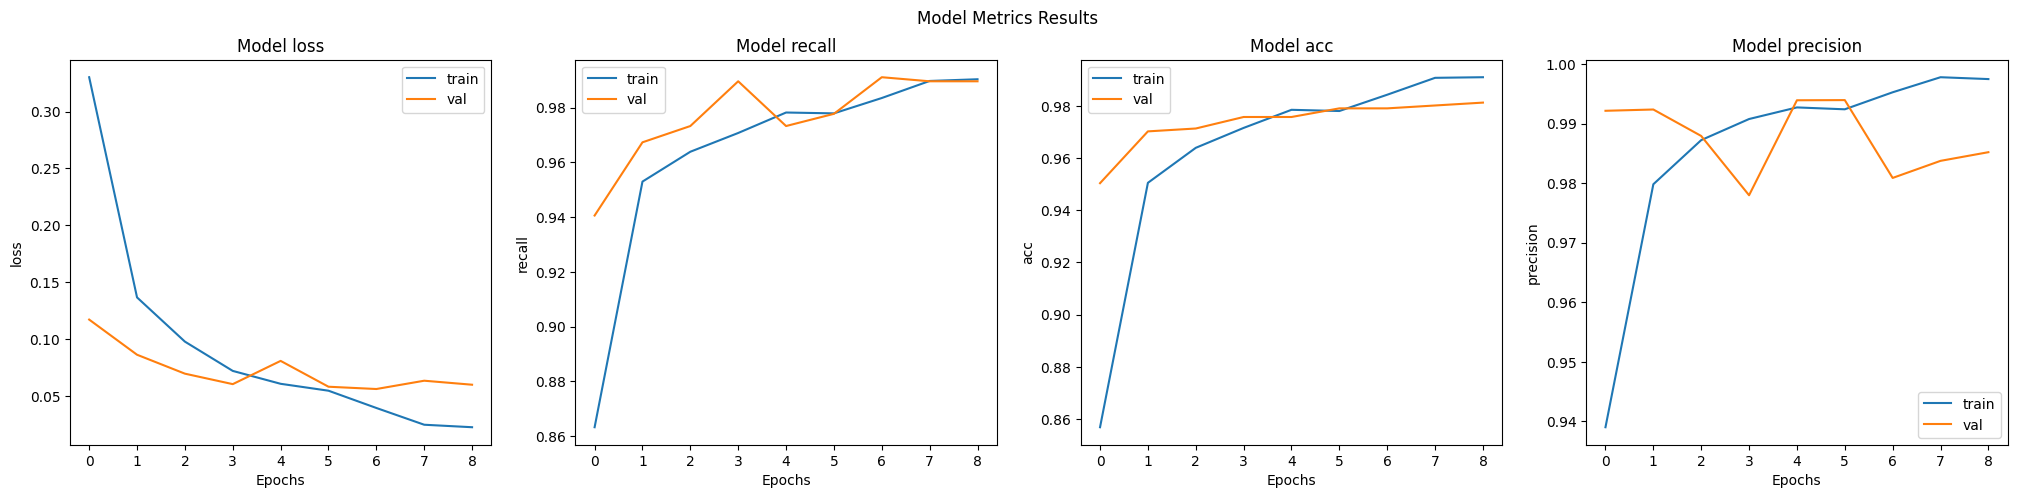

In [68]:
print("Basline Evaluation Metrics Best Metrics :\n")
eval_metrics(history4)

In [69]:
train_labels, train_predictions = predict_results(model_4,train_gen)
val_labels, val_predictions = predict_results(model_4,val_gen)

2/2 [==============================] - 0s 95ms/step


2023-03-28 23:42:16.343760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


Training Confusion Matrices:



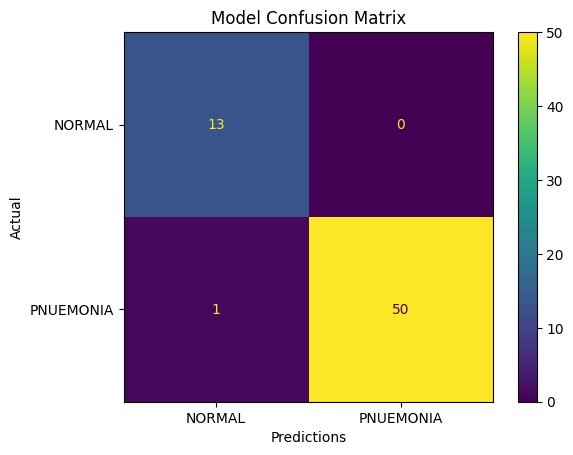

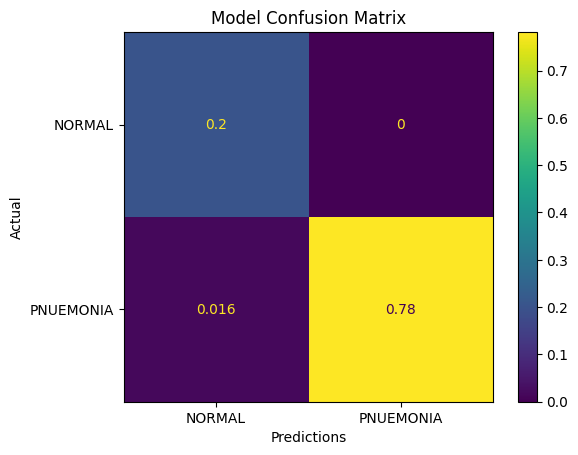

Validation Confusion Matrices:



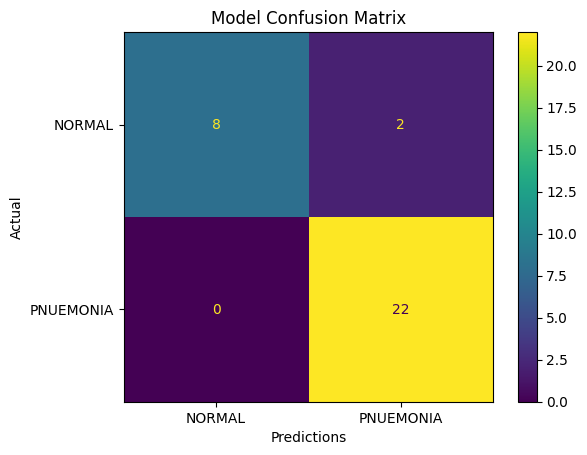

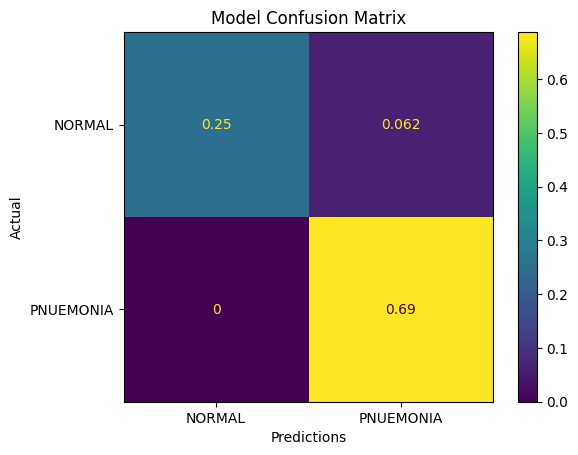

In [70]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [71]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history4)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        13
         1.0       1.00      0.98      0.99        51

    accuracy                           0.98        64
   macro avg       0.96      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



68/68 [==============================] - 21s 302ms/step - loss: 0.0131 - acc: 0.9977 - recall: 0.9975 - precision: 0.9994
Loss: 0.0131


In [72]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history4)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        10
         1.0       0.92      1.00      0.96        22

    accuracy                           0.94        32
   macro avg       0.96      0.90      0.92        32
weighted avg       0.94      0.94      0.94        32



29/29 [==============================] - 5s 159ms/step - loss: 0.0597 - acc: 0.9813 - recall: 0.9896 - precision: 0.9852
Loss: 0.0597


### Model 4 Evaluation

- Model Plots: The validation metrics are slightly worse than the training metrics, but not far off.
- Confusion Matrix: The validation model had no FN, but 2 FP. 
- Report: The Validation Normall Recall scores are the lowest yet. 
- Overall the Recall and Loss are still acceptable


---

# Model 5 

Using gridsearch and keras wrappers to do some hyperparameter optimization
- epochs = [45,65,90]
- optimizer = ['adam', "SGD"]
- dropout_rate = [.3,.5] 
- Will add Conv2D and a Dense layer for more complexity.

Description of the model hyperparameters and data parameters:

- **Model***
    - **layers: 4 Conv2D each w/ MaxPooling2D, 3 Dense output layers
    - filters: 32,64,96,128 for Conv2D, 128, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - **dropout:** .5 between the dense output layers
- **Model Compile**
    - loss: binary_crossentropy
    - **optimizer:**adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 128
    - **epochs:** 90
    - early stopping : True
    - class weights: {0: 1.6, 1: 0.7272727272727273}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [74]:
#Build model for classifier with parameters in signature
def buildModel(dropout_rate, optimizer = "adam"):

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(units=128, activation='relu',), 
    Dropout(dropout_rate),
    Dense(units=64, activation='relu'),
    Dropout(dropout_rate),    
    Dense(units=1, activation='sigmoid'),
    ])

    model.compile(loss='binary_crossentropy',
                    optimizer= optimizer,
                    metrics=["acc","Recall","Precision"]
                     )
    return model

In [78]:
#Hyperparameters for GridsearchCV
epochs = [45,65,90]
optimizer = ['adam', "SGD"]
dropout_rate = [.3,.5] 

#Creating a dictionary to use as parameters
parameters_2 = dict(optimizer=optimizer, dropout_rate=dropout_rate,  epochs=epochs )
parameters_2

{'optimizer': ['adam', 'SGD'],
 'dropout_rate': [0.3, 0.5],
 'epochs': [45, 65, 90]}

In [79]:
#Creating a wrapped classifier
classifier = KerasClassifier(build_fn=buildModel, batch_size = 128, class_weight = class_weights)

#Gridsearch Creation
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters_2,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
#Gridsearch Fitting
gs_2 = grid_search.fit(X_train, y_train, verbose = 1)

Epoch 1/45


2023-03-29 00:05:24.915396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6529 - acc: 0.3333 - recall: 0.4062 - precision: 0.5909
Epoch 2/45
1/1 [==============================] - 0s 160ms/step - loss: 0.6431 - acc: 0.7143 - recall: 0.9375 - precision: 0.7500
Epoch 3/45
1/1 [==============================] - 0s 113ms/step - loss: 0.6483 - acc: 0.7381 - recall: 0.9688 - precision: 0.7561
Epoch 4/45
1/1 [==============================] - 0s 148ms/step - loss: 0.6411 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 5/45
1/1 [==============================] - 0s 109ms/step - loss: 0.6342 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 6/45
1/1 [==============================] - 0s 149ms/step - loss: 0.6307 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 7/45
1/1 [==============================] - 0s 52ms/step - loss: 0.6359 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 8/45
1/1 [==============================] - 0s 115ms/step - loss: 0.6302 - acc: 0.7619 - recall: 1.

2023-03-29 00:05:29.536473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 107ms/step
Epoch 1/45


2023-03-29 00:05:30.382326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6988 - acc: 0.5581 - recall: 0.5517 - precision: 0.7273
Epoch 2/45
1/1 [==============================] - 0s 184ms/step - loss: 0.6955 - acc: 0.4884 - recall: 0.4828 - precision: 0.6667
Epoch 3/45
1/1 [==============================] - 0s 116ms/step - loss: 0.6932 - acc: 0.4651 - recall: 0.3103 - precision: 0.7500
Epoch 4/45
1/1 [==============================] - 0s 155ms/step - loss: 0.7073 - acc: 0.4186 - recall: 0.2759 - precision: 0.6667
Epoch 5/45
1/1 [==============================] - 0s 156ms/step - loss: 0.7156 - acc: 0.4651 - recall: 0.3103 - precision: 0.7500
Epoch 6/45
1/1 [==============================] - 0s 99ms/step - loss: 0.6851 - acc: 0.5116 - recall: 0.4483 - precision: 0.7222
Epoch 7/45
1/1 [==============================] - 0s 67ms/step - loss: 0.7120 - acc: 0.5116 - recall: 0.4828 - precision: 0.7000
Epoch 8/45
1/1 [==============================] - 0s 147ms/step - loss: 0.7290 - acc: 0.4186 - recall: 0.4

2023-03-29 00:05:35.928095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 128ms/step
Epoch 1/45


2023-03-29 00:05:36.820043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.7281 - acc: 0.4186 - recall: 0.2963 - precision: 0.5714
Epoch 2/45
1/1 [==============================] - 0s 365ms/step - loss: 0.7278 - acc: 0.4419 - recall: 0.2222 - precision: 0.6667
Epoch 3/45
1/1 [==============================] - 0s 178ms/step - loss: 0.7169 - acc: 0.4651 - recall: 0.1481 - precision: 1.0000
Epoch 4/45
1/1 [==============================] - 0s 181ms/step - loss: 0.7301 - acc: 0.3721 - recall: 0.0370 - precision: 0.5000
Epoch 5/45
1/1 [==============================] - 0s 108ms/step - loss: 0.7068 - acc: 0.4651 - recall: 0.2222 - precision: 0.7500
Epoch 6/45
1/1 [==============================] - 0s 95ms/step - loss: 0.7529 - acc: 0.3488 - recall: 0.1852 - precision: 0.4545
Epoch 7/45
1/1 [==============================] - 0s 103ms/step - loss: 0.7225 - acc: 0.4186 - recall: 0.1852 - precision: 0.6250
Epoch 8/45
1/1 [==============================] - 0s 123ms/step - loss: 0.7304 - acc: 0.3721 - recall: 0.

2023-03-29 00:05:41.555828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 113ms/step
Epoch 1/45


2023-03-29 00:05:42.393191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6498 - acc: 0.4524 - recall: 0.5000 - precision: 0.6957
Epoch 2/45
1/1 [==============================] - 0s 158ms/step - loss: 0.6465 - acc: 0.6429 - recall: 0.7188 - precision: 0.7931
Epoch 3/45
1/1 [==============================] - 0s 153ms/step - loss: 0.6454 - acc: 0.7143 - recall: 0.7812 - precision: 0.8333
Epoch 4/45
1/1 [==============================] - 0s 93ms/step - loss: 0.6461 - acc: 0.6429 - recall: 0.8125 - precision: 0.7429
Epoch 5/45
1/1 [==============================] - 0s 106ms/step - loss: 0.6475 - acc: 0.7143 - recall: 0.8438 - precision: 0.7941
Epoch 6/45
1/1 [==============================] - 0s 172ms/step - loss: 0.6453 - acc: 0.7619 - recall: 0.9688 - precision: 0.7750
Epoch 7/45
1/1 [==============================] - 0s 93ms/step - loss: 0.6448 - acc: 0.7381 - recall: 0.9375 - precision: 0.7692
Epoch 8/45
1/1 [==============================] - 0s 104ms/step - loss: 0.6468 - acc: 0.7381 - recall: 0.9

2023-03-29 00:05:46.955852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 118ms/step
Epoch 1/45


2023-03-29 00:05:48.370013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7050 - acc: 0.3953 - recall: 0.4828 - precision: 0.5600
Epoch 2/45
1/1 [==============================] - 0s 105ms/step - loss: 0.7020 - acc: 0.5349 - recall: 0.5172 - precision: 0.7143
Epoch 3/45
1/1 [==============================] - 0s 165ms/step - loss: 0.7008 - acc: 0.4884 - recall: 0.4828 - precision: 0.6667
Epoch 4/45
1/1 [==============================] - 0s 115ms/step - loss: 0.6998 - acc: 0.4651 - recall: 0.4828 - precision: 0.6364
Epoch 5/45
1/1 [==============================] - 0s 115ms/step - loss: 0.7015 - acc: 0.4186 - recall: 0.3793 - precision: 0.6111
Epoch 6/45
1/1 [==============================] - 0s 226ms/step - loss: 0.6999 - acc: 0.5349 - recall: 0.4828 - precision: 0.7368
Epoch 7/45
1/1 [==============================] - 0s 110ms/step - loss: 0.6984 - acc: 0.5116 - recall: 0.4483 - precision: 0.7222
Epoch 8/45
1/1 [==============================] - 0s 89ms/step - loss: 0.7007 - acc: 0.3721 - recall: 0.

2023-03-29 00:05:52.902748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 214ms/step
Epoch 1/45


2023-03-29 00:05:53.817937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.7273 - acc: 0.5581 - recall: 0.5926 - precision: 0.6667
Epoch 2/45
1/1 [==============================] - 0s 163ms/step - loss: 0.7336 - acc: 0.3023 - recall: 0.3333 - precision: 0.4286
Epoch 3/45
1/1 [==============================] - 0s 106ms/step - loss: 0.7294 - acc: 0.3953 - recall: 0.3333 - precision: 0.5294
Epoch 4/45
1/1 [==============================] - 0s 155ms/step - loss: 0.7268 - acc: 0.5116 - recall: 0.4074 - precision: 0.6875
Epoch 5/45
1/1 [==============================] - 0s 66ms/step - loss: 0.7297 - acc: 0.4651 - recall: 0.3333 - precision: 0.6429
Epoch 6/45
1/1 [==============================] - 0s 99ms/step - loss: 0.7270 - acc: 0.3953 - recall: 0.1852 - precision: 0.5556
Epoch 7/45
1/1 [==============================] - 0s 116ms/step - loss: 0.7262 - acc: 0.4419 - recall: 0.1852 - precision: 0.7143
Epoch 8/45
1/1 [==============================] - 0s 97ms/step - loss: 0.7253 - acc: 0.4884 - recall: 0.22

2023-03-29 00:05:58.209153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 112ms/step
Epoch 1/65


2023-03-29 00:05:59.280906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6487 - acc: 0.5476 - recall: 0.5625 - precision: 0.7826
Epoch 2/65
1/1 [==============================] - 0s 209ms/step - loss: 0.6365 - acc: 0.7857 - recall: 1.0000 - precision: 0.7805
Epoch 3/65
1/1 [==============================] - 0s 165ms/step - loss: 0.6143 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 4/65
1/1 [==============================] - 0s 94ms/step - loss: 0.6822 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 5/65
1/1 [==============================] - 0s 118ms/step - loss: 0.6561 - acc: 0.7143 - recall: 0.9375 - precision: 0.7500
Epoch 6/65
1/1 [==============================] - 0s 194ms/step - loss: 0.6387 - acc: 0.7381 - recall: 0.9375 - precision: 0.7692
Epoch 7/65
1/1 [==============================] - 0s 189ms/step - loss: 0.6432 - acc: 0.6905 - recall: 0.8750 - precision: 0.7568
Epoch 8/65
1/1 [==============================] - 0s 63ms/step - loss: 0.6400 - acc: 0.6667 - recall: 0.8

2023-03-29 00:06:04.826968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 173ms/step
Epoch 1/65


2023-03-29 00:06:05.879657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.7005 - acc: 0.5581 - recall: 0.5862 - precision: 0.7083
Epoch 2/65
1/1 [==============================] - 0s 366ms/step - loss: 0.6987 - acc: 0.6512 - recall: 0.7931 - precision: 0.7188
Epoch 3/65
1/1 [==============================] - 0s 199ms/step - loss: 0.6961 - acc: 0.6047 - recall: 0.6552 - precision: 0.7308
Epoch 4/65
1/1 [==============================] - 0s 150ms/step - loss: 0.7004 - acc: 0.4419 - recall: 0.2759 - precision: 0.7273
Epoch 5/65
1/1 [==============================] - 0s 191ms/step - loss: 0.7203 - acc: 0.4651 - recall: 0.3448 - precision: 0.7143
Epoch 6/65
1/1 [==============================] - 0s 53ms/step - loss: 0.6598 - acc: 0.5814 - recall: 0.4138 - precision: 0.9231
Epoch 7/65
1/1 [==============================] - 0s 109ms/step - loss: 0.7031 - acc: 0.4651 - recall: 0.3793 - precision: 0.6875
Epoch 8/65
1/1 [==============================] - 0s 65ms/step - loss: 0.6950 - acc: 0.5116 - recall: 0.4

1/1 [==============================] - 0s 47ms/step - loss: 0.0020 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/65
1/1 [==============================] - 0s 197ms/step


2023-03-29 00:06:11.994096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 114ms/step
Epoch 1/65


2023-03-29 00:06:13.232051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7311 - acc: 0.4419 - recall: 0.5185 - precision: 0.5600
Epoch 2/65
1/1 [==============================] - 0s 173ms/step - loss: 0.7215 - acc: 0.3953 - recall: 0.1481 - precision: 0.5714
Epoch 3/65
1/1 [==============================] - 0s 170ms/step - loss: 0.7074 - acc: 0.3488 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/65
1/1 [==============================] - 0s 160ms/step - loss: 0.7312 - acc: 0.3953 - recall: 0.0370 - precision: 1.0000
Epoch 5/65
1/1 [==============================] - 0s 109ms/step - loss: 0.7084 - acc: 0.3953 - recall: 0.0741 - precision: 0.6667
Epoch 6/65
1/1 [==============================] - 0s 70ms/step - loss: 0.7049 - acc: 0.5349 - recall: 0.2963 - precision: 0.8889
Epoch 7/65
1/1 [==============================] - 0s 61ms/step - loss: 0.6955 - acc: 0.4419 - recall: 0.2593 - precision: 0.6364
Epoch 8/65
1/1 [==============================] - 0s 202ms/step - loss: 0.7823 - acc: 0.3023 - rec

1/1 [==============================] - 0s 49ms/step - loss: 0.0039 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/65
1/1 [==============================] - 0s 209ms/step


2023-03-29 00:06:19.275825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 122ms/step
Epoch 1/65


2023-03-29 00:06:20.097352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6459 - acc: 0.6190 - recall: 0.7188 - precision: 0.7667
Epoch 2/65
1/1 [==============================] - 0s 172ms/step - loss: 0.6461 - acc: 0.6429 - recall: 0.7188 - precision: 0.7931
Epoch 3/65
1/1 [==============================] - 0s 124ms/step - loss: 0.6476 - acc: 0.6190 - recall: 0.7812 - precision: 0.7353
Epoch 4/65
1/1 [==============================] - 0s 160ms/step - loss: 0.6464 - acc: 0.6905 - recall: 0.8438 - precision: 0.7714
Epoch 5/65
1/1 [==============================] - 0s 98ms/step - loss: 0.6474 - acc: 0.7143 - recall: 0.8750 - precision: 0.7778
Epoch 6/65
1/1 [==============================] - 0s 97ms/step - loss: 0.6451 - acc: 0.6429 - recall: 0.8438 - precision: 0.7297
Epoch 7/65
1/1 [==============================] - 0s 152ms/step - loss: 0.6482 - acc: 0.7619 - recall: 0.9688 - precision: 0.7750
Epoch 8/65
1/1 [==============================] - 0s 115ms/step - loss: 0.6446 - acc: 0.7619 - recall: 0.9

2023-03-29 00:06:25.497997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 113ms/step
Epoch 1/65


2023-03-29 00:06:26.321029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7039 - acc: 0.4186 - recall: 0.4138 - precision: 0.6000
Epoch 2/65
1/1 [==============================] - 0s 115ms/step - loss: 0.7031 - acc: 0.3721 - recall: 0.3793 - precision: 0.5500
Epoch 3/65
1/1 [==============================] - 0s 165ms/step - loss: 0.7018 - acc: 0.4419 - recall: 0.4138 - precision: 0.6316
Epoch 4/65
1/1 [==============================] - 0s 157ms/step - loss: 0.7006 - acc: 0.5116 - recall: 0.4138 - precision: 0.7500
Epoch 5/65
1/1 [==============================] - 0s 116ms/step - loss: 0.6994 - acc: 0.5814 - recall: 0.4828 - precision: 0.8235
Epoch 6/65
1/1 [==============================] - 0s 180ms/step - loss: 0.6977 - acc: 0.5581 - recall: 0.5172 - precision: 0.7500
Epoch 7/65
1/1 [==============================] - 0s 48ms/step - loss: 0.6997 - acc: 0.4651 - recall: 0.3793 - precision: 0.6875
Epoch 8/65
1/1 [==============================] - 0s 189ms/step - loss: 0.6998 - acc: 0.5116 - recall: 0.

2023-03-29 00:06:32.378890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 141ms/step
Epoch 1/65


2023-03-29 00:06:33.211192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.7301 - acc: 0.5116 - recall: 0.5926 - precision: 0.6154
Epoch 2/65
1/1 [==============================] - 0s 203ms/step - loss: 0.7295 - acc: 0.4186 - recall: 0.3704 - precision: 0.5556
Epoch 3/65
1/1 [==============================] - 0s 137ms/step - loss: 0.7284 - acc: 0.3721 - recall: 0.2593 - precision: 0.5000
Epoch 4/65
1/1 [==============================] - 0s 149ms/step - loss: 0.7260 - acc: 0.5349 - recall: 0.3704 - precision: 0.7692
Epoch 5/65
1/1 [==============================] - 0s 124ms/step - loss: 0.7287 - acc: 0.4186 - recall: 0.2222 - precision: 0.6000
Epoch 6/65
1/1 [==============================] - 0s 103ms/step - loss: 0.7281 - acc: 0.3721 - recall: 0.1852 - precision: 0.5000
Epoch 7/65
1/1 [==============================] - 0s 96ms/step - loss: 0.7269 - acc: 0.4186 - recall: 0.1481 - precision: 0.6667
Epoch 8/65
1/1 [==============================] - 0s 107ms/step - loss: 0.7276 - acc: 0.3721 - recall: 0.

2023-03-29 00:06:38.816104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 178ms/step
Epoch 1/90


2023-03-29 00:06:40.454880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6445 - acc: 0.5714 - recall: 0.6250 - precision: 0.7692
Epoch 2/90
1/1 [==============================] - 0s 198ms/step - loss: 0.6453 - acc: 0.7143 - recall: 0.9375 - precision: 0.7500
Epoch 3/90
1/1 [==============================] - 0s 198ms/step - loss: 0.6149 - acc: 0.7381 - recall: 0.9688 - precision: 0.7561
Epoch 4/90
1/1 [==============================] - 0s 124ms/step - loss: 0.6123 - acc: 0.7619 - recall: 0.9375 - precision: 0.7895
Epoch 5/90
1/1 [==============================] - 0s 116ms/step - loss: 0.6376 - acc: 0.6905 - recall: 0.8750 - precision: 0.7568
Epoch 6/90
1/1 [==============================] - 0s 247ms/step - loss: 0.6622 - acc: 0.6667 - recall: 0.8438 - precision: 0.7500
Epoch 7/90
1/1 [==============================] - 0s 119ms/step - loss: 0.6381 - acc: 0.6905 - recall: 0.8438 - precision: 0.7714
Epoch 8/90
1/1 [==============================] - 0s 70ms/step - loss: 0.6485 - acc: 0.6429 - recall: 0.

1/1 [==============================] - 0s 47ms/step - loss: 0.0357 - acc: 0.9762 - recall: 0.9688 - precision: 1.0000
Epoch 65/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0232 - acc: 0.9762 - recall: 0.9688 - precision: 1.0000
Epoch 66/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1036 - acc: 0.9762 - recall: 1.0000 - precision: 0.9697
Epoch 67/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0038 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0278 - acc: 0.9762 - recall: 0.9688 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0213 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0333 - acc: 0.9762 - recall: 0.9688 - precision: 1.0000
Epoch 71/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0093 - acc: 1.0000 - recall:

2023-03-29 00:06:47.597964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 130ms/step
Epoch 1/90


2023-03-29 00:06:48.566605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6995 - acc: 0.6279 - recall: 0.6897 - precision: 0.7407
Epoch 2/90
1/1 [==============================] - 0s 201ms/step - loss: 0.7068 - acc: 0.3721 - recall: 0.2414 - precision: 0.5833
Epoch 3/90
1/1 [==============================] - 0s 112ms/step - loss: 0.7043 - acc: 0.2791 - recall: 0.0345 - precision: 0.2500
Epoch 4/90
1/1 [==============================] - 0s 337ms/step - loss: 0.6984 - acc: 0.3488 - recall: 0.0690 - precision: 0.6667
Epoch 5/90
1/1 [==============================] - 0s 210ms/step - loss: 0.6933 - acc: 0.3721 - recall: 0.0690 - precision: 1.0000
Epoch 6/90
1/1 [==============================] - 0s 122ms/step - loss: 0.6937 - acc: 0.4419 - recall: 0.1724 - precision: 1.0000
Epoch 7/90
1/1 [==============================] - 0s 201ms/step - loss: 0.6873 - acc: 0.3953 - recall: 0.1379 - precision: 0.8000
Epoch 8/90
1/1 [==============================] - 0s 165ms/step - loss: 0.7153 - acc: 0.4884 - recall: 0

2023-03-29 00:06:56.016017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 180ms/step
Epoch 1/90


2023-03-29 00:06:57.029471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7304 - acc: 0.3953 - recall: 0.4444 - precision: 0.5217
Epoch 2/90
1/1 [==============================] - 0s 184ms/step - loss: 0.7197 - acc: 0.4186 - recall: 0.0741 - precision: 1.0000
Epoch 3/90
1/1 [==============================] - 0s 111ms/step - loss: 0.7311 - acc: 0.3488 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/90
1/1 [==============================] - 0s 234ms/step - loss: 0.7228 - acc: 0.3953 - recall: 0.0741 - precision: 0.6667
Epoch 5/90
1/1 [==============================] - 0s 130ms/step - loss: 0.7286 - acc: 0.3953 - recall: 0.0370 - precision: 1.0000
Epoch 6/90
1/1 [==============================] - 0s 137ms/step - loss: 0.7442 - acc: 0.3953 - recall: 0.0370 - precision: 1.0000
Epoch 7/90
1/1 [==============================] - 0s 133ms/step - loss: 0.7145 - acc: 0.3488 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 8/90
1/1 [==============================] - 0s 192ms/step - loss: 0.7125 - acc: 0.

2023-03-29 00:07:04.881674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 153ms/step
Epoch 1/90


2023-03-29 00:07:05.811636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6441 - acc: 0.6429 - recall: 0.6875 - precision: 0.8148
Epoch 2/90
1/1 [==============================] - 0s 232ms/step - loss: 0.6469 - acc: 0.5476 - recall: 0.6250 - precision: 0.7407
Epoch 3/90
1/1 [==============================] - 0s 117ms/step - loss: 0.6476 - acc: 0.6905 - recall: 0.8438 - precision: 0.7714
Epoch 4/90
1/1 [==============================] - 0s 123ms/step - loss: 0.6436 - acc: 0.7381 - recall: 0.8438 - precision: 0.8182
Epoch 5/90
1/1 [==============================] - 0s 190ms/step - loss: 0.6460 - acc: 0.7619 - recall: 0.9688 - precision: 0.7750
Epoch 6/90
1/1 [==============================] - 0s 207ms/step - loss: 0.6457 - acc: 0.7619 - recall: 0.9688 - precision: 0.7750
Epoch 7/90
1/1 [==============================] - 0s 136ms/step - loss: 0.6421 - acc: 0.7619 - recall: 0.9688 - precision: 0.7750
Epoch 8/90
1/1 [==============================] - 0s 213ms/step - loss: 0.6433 - acc: 0.7619 - recall: 1

1/1 [==============================] - 0s 47ms/step - loss: 0.6347 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6259 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 66/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6269 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 67/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6275 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 68/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6259 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 69/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6249 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 70/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6357 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 71/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6342 - acc: 0.7619 - recall:

2023-03-29 00:07:13.323461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 109ms/step
Epoch 1/90


2023-03-29 00:07:14.491861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6991 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 2/90
1/1 [==============================] - 0s 197ms/step - loss: 0.7013 - acc: 0.4651 - recall: 0.4138 - precision: 0.6667
Epoch 3/90
1/1 [==============================] - 0s 103ms/step - loss: 0.6967 - acc: 0.6279 - recall: 0.5517 - precision: 0.8421
Epoch 4/90
1/1 [==============================] - 0s 138ms/step - loss: 0.6991 - acc: 0.5116 - recall: 0.4483 - precision: 0.7222
Epoch 5/90
1/1 [==============================] - 0s 52ms/step - loss: 0.7001 - acc: 0.4884 - recall: 0.4483 - precision: 0.6842
Epoch 6/90
1/1 [==============================] - 0s 119ms/step - loss: 0.6982 - acc: 0.5349 - recall: 0.4828 - precision: 0.7368
Epoch 7/90
1/1 [==============================] - 0s 129ms/step - loss: 0.6973 - acc: 0.6279 - recall: 0.5517 - precision: 0.8421
Epoch 8/90
1/1 [==============================] - 0s 196ms/step - loss: 0.7011 - acc: 0.4651 - recall: 0.

1/1 [==============================] - 0s 47ms/step - loss: 0.6960 - acc: 0.5116 - recall: 0.3448 - precision: 0.8333
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6951 - acc: 0.5349 - recall: 0.3793 - precision: 0.8462
Epoch 66/90
1/1 [==============================] - 0s 48ms/step - loss: 0.6996 - acc: 0.4419 - recall: 0.2759 - precision: 0.7273
Epoch 67/90
1/1 [==============================] - 0s 48ms/step - loss: 0.6950 - acc: 0.4884 - recall: 0.3103 - precision: 0.8182
Epoch 68/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6954 - acc: 0.5116 - recall: 0.3448 - precision: 0.8333
Epoch 69/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6957 - acc: 0.4419 - recall: 0.2759 - precision: 0.7273
Epoch 70/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6916 - acc: 0.6047 - recall: 0.4483 - precision: 0.9286
Epoch 71/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6947 - acc: 0.5814 - recall:

2023-03-29 00:07:21.920846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 218ms/step
Epoch 1/90


2023-03-29 00:07:22.821063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.7288 - acc: 0.5581 - recall: 0.7407 - precision: 0.6250
Epoch 2/90
1/1 [==============================] - 0s 196ms/step - loss: 0.7245 - acc: 0.5581 - recall: 0.4444 - precision: 0.7500
Epoch 3/90
1/1 [==============================] - 0s 207ms/step - loss: 0.7271 - acc: 0.4419 - recall: 0.3704 - precision: 0.5882
Epoch 4/90
1/1 [==============================] - 0s 110ms/step - loss: 0.7279 - acc: 0.5581 - recall: 0.4074 - precision: 0.7857
Epoch 5/90
1/1 [==============================] - 0s 141ms/step - loss: 0.7265 - acc: 0.5349 - recall: 0.3333 - precision: 0.8182
Epoch 6/90
1/1 [==============================] - 0s 178ms/step - loss: 0.7271 - acc: 0.4651 - recall: 0.2222 - precision: 0.7500
Epoch 7/90
1/1 [==============================] - 0s 153ms/step - loss: 0.7278 - acc: 0.4419 - recall: 0.2222 - precision: 0.6667
Epoch 8/90
1/1 [==============================] - 0s 110ms/step - loss: 0.7271 - acc: 0.3953 - recall: 0

2023-03-29 00:07:30.113033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 113ms/step
Epoch 1/45


2023-03-29 00:07:30.947688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6487 - acc: 0.5714 - recall: 0.6250 - precision: 0.7692
Epoch 2/45
1/1 [==============================] - 0s 175ms/step - loss: 0.6337 - acc: 0.6667 - recall: 0.8438 - precision: 0.7500
Epoch 3/45
1/1 [==============================] - 0s 153ms/step - loss: 0.6684 - acc: 0.7143 - recall: 0.9062 - precision: 0.7632
Epoch 4/45
1/1 [==============================] - 0s 96ms/step - loss: 0.6020 - acc: 0.8095 - recall: 0.9375 - precision: 0.8333
Epoch 5/45
1/1 [==============================] - 0s 167ms/step - loss: 0.6495 - acc: 0.6905 - recall: 0.8438 - precision: 0.7714
Epoch 6/45
1/1 [==============================] - 0s 140ms/step - loss: 0.6655 - acc: 0.6905 - recall: 0.8438 - precision: 0.7714
Epoch 7/45
1/1 [==============================] - 0s 52ms/step - loss: 0.6813 - acc: 0.5952 - recall: 0.7500 - precision: 0.7273
Epoch 8/45
1/1 [==============================] - 0s 140ms/step - loss: 0.6484 - acc: 0.5476 - recall: 0.6

2023-03-29 00:07:36.248115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 172ms/step
Epoch 1/45


2023-03-29 00:07:37.268805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6982 - acc: 0.5581 - recall: 0.5862 - precision: 0.7083
Epoch 2/45
1/1 [==============================] - 0s 201ms/step - loss: 0.6581 - acc: 0.6977 - recall: 0.7241 - precision: 0.8077
Epoch 3/45
1/1 [==============================] - 0s 166ms/step - loss: 0.7587 - acc: 0.5814 - recall: 0.6207 - precision: 0.7200
Epoch 4/45
1/1 [==============================] - 0s 195ms/step - loss: 0.7674 - acc: 0.4884 - recall: 0.4828 - precision: 0.6667
Epoch 5/45
1/1 [==============================] - 0s 207ms/step - loss: 0.6921 - acc: 0.5581 - recall: 0.5172 - precision: 0.7500
Epoch 6/45
1/1 [==============================] - 0s 54ms/step - loss: 0.7077 - acc: 0.5349 - recall: 0.4828 - precision: 0.7368
Epoch 7/45
1/1 [==============================] - 0s 89ms/step - loss: 0.6909 - acc: 0.5349 - recall: 0.4828 - precision: 0.7368
Epoch 8/45
1/1 [==============================] - 0s 50ms/step - loss: 0.6878 - acc: 0.6279 - recall: 0.58

2023-03-29 00:07:42.901220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 176ms/step
Epoch 1/45


2023-03-29 00:07:44.282357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7290 - acc: 0.4884 - recall: 0.5556 - precision: 0.6000
Epoch 2/45
1/1 [==============================] - 0s 255ms/step - loss: 0.7234 - acc: 0.4651 - recall: 0.3704 - precision: 0.6250
Epoch 3/45
1/1 [==============================] - 0s 253ms/step - loss: 0.7295 - acc: 0.3953 - recall: 0.2593 - precision: 0.5385
Epoch 4/45
1/1 [==============================] - 0s 209ms/step - loss: 0.7460 - acc: 0.3488 - recall: 0.1852 - precision: 0.4545
Epoch 5/45
1/1 [==============================] - 0s 154ms/step - loss: 0.7005 - acc: 0.4651 - recall: 0.2593 - precision: 0.7000
Epoch 6/45
1/1 [==============================] - 0s 73ms/step - loss: 0.7314 - acc: 0.3721 - recall: 0.0741 - precision: 0.5000
Epoch 7/45
1/1 [==============================] - 0s 52ms/step - loss: 0.7160 - acc: 0.4186 - recall: 0.0741 - precision: 1.0000
Epoch 8/45
1/1 [==============================] - 0s 156ms/step - loss: 0.6902 - acc: 0.4186 - recall: 0.0

2023-03-29 00:07:49.717907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 217ms/step
Epoch 1/45


2023-03-29 00:07:50.585277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step - loss: 0.6517 - acc: 0.5000 - recall: 0.5625 - precision: 0.7200
Epoch 2/45
1/1 [==============================] - 0s 447ms/step - loss: 0.6492 - acc: 0.5000 - recall: 0.5312 - precision: 0.7391
Epoch 3/45
1/1 [==============================] - 0s 245ms/step - loss: 0.6465 - acc: 0.5714 - recall: 0.6250 - precision: 0.7692
Epoch 4/45
1/1 [==============================] - 0s 253ms/step - loss: 0.6479 - acc: 0.5952 - recall: 0.6562 - precision: 0.7778
Epoch 5/45
1/1 [==============================] - 0s 196ms/step - loss: 0.6533 - acc: 0.5714 - recall: 0.6562 - precision: 0.7500
Epoch 6/45
1/1 [==============================] - 0s 160ms/step - loss: 0.6432 - acc: 0.6190 - recall: 0.7188 - precision: 0.7667
Epoch 7/45
1/1 [==============================] - 0s 88ms/step - loss: 0.6474 - acc: 0.6429 - recall: 0.7812 - precision: 0.7576
Epoch 8/45
1/1 [==============================] - 0s 52ms/step - loss: 0.6430 - acc: 0.6429 - recall: 0.7

2023-03-29 00:07:56.253341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 169ms/step
Epoch 1/45


2023-03-29 00:07:57.242562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6993 - acc: 0.4884 - recall: 0.5517 - precision: 0.6400
Epoch 2/45
1/1 [==============================] - 0s 248ms/step - loss: 0.6971 - acc: 0.5814 - recall: 0.5517 - precision: 0.7619
Epoch 3/45
1/1 [==============================] - 0s 223ms/step - loss: 0.6950 - acc: 0.5814 - recall: 0.5172 - precision: 0.7895
Epoch 4/45
1/1 [==============================] - 0s 171ms/step - loss: 0.7014 - acc: 0.5116 - recall: 0.5172 - precision: 0.6818
Epoch 5/45
1/1 [==============================] - 0s 168ms/step - loss: 0.7023 - acc: 0.5581 - recall: 0.5517 - precision: 0.7273
Epoch 6/45
1/1 [==============================] - 0s 244ms/step - loss: 0.6962 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 7/45
1/1 [==============================] - 0s 158ms/step - loss: 0.7014 - acc: 0.5116 - recall: 0.5172 - precision: 0.6818
Epoch 8/45
1/1 [==============================] - 0s 172ms/step - loss: 0.7099 - acc: 0.4186 - recall: 0

2023-03-29 00:08:03.214158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 167ms/step
Epoch 1/45


2023-03-29 00:08:04.185410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7341 - acc: 0.3953 - recall: 0.4444 - precision: 0.5217
Epoch 2/45
1/1 [==============================] - 0s 238ms/step - loss: 0.7306 - acc: 0.5116 - recall: 0.5185 - precision: 0.6364
Epoch 3/45
1/1 [==============================] - 0s 245ms/step - loss: 0.7225 - acc: 0.6047 - recall: 0.5926 - precision: 0.7273
Epoch 4/45
1/1 [==============================] - 0s 237ms/step - loss: 0.7290 - acc: 0.4419 - recall: 0.4444 - precision: 0.5714
Epoch 5/45
1/1 [==============================] - 0s 157ms/step - loss: 0.7308 - acc: 0.4186 - recall: 0.4074 - precision: 0.5500
Epoch 6/45
1/1 [==============================] - 0s 237ms/step - loss: 0.7265 - acc: 0.4884 - recall: 0.4444 - precision: 0.6316
Epoch 7/45
1/1 [==============================] - 0s 163ms/step - loss: 0.7292 - acc: 0.4884 - recall: 0.4074 - precision: 0.6471
Epoch 8/45
1/1 [==============================] - 0s 50ms/step - loss: 0.7259 - acc: 0.4884 - recall: 0.

2023-03-29 00:08:09.631446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 228ms/step
Epoch 1/65


2023-03-29 00:08:11.103944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6472 - acc: 0.4762 - recall: 0.5000 - precision: 0.7273
Epoch 2/65
1/1 [==============================] - 0s 461ms/step - loss: 0.6249 - acc: 0.7619 - recall: 0.9062 - precision: 0.8056
Epoch 3/65
1/1 [==============================] - 0s 252ms/step - loss: 0.6696 - acc: 0.6667 - recall: 0.8438 - precision: 0.7500
Epoch 4/65
1/1 [==============================] - 0s 260ms/step - loss: 0.6755 - acc: 0.6667 - recall: 0.8750 - precision: 0.7368
Epoch 5/65
1/1 [==============================] - 0s 84ms/step - loss: 0.6538 - acc: 0.6667 - recall: 0.8438 - precision: 0.7500
Epoch 6/65
1/1 [==============================] - 0s 245ms/step - loss: 0.6456 - acc: 0.6905 - recall: 0.7812 - precision: 0.8065
Epoch 7/65
1/1 [==============================] - 0s 53ms/step - loss: 0.6431 - acc: 0.5476 - recall: 0.6875 - precision: 0.7097
Epoch 8/65
1/1 [==============================] - 0s 221ms/step - loss: 0.6480 - acc: 0.6429 - recall: 0.7

1/1 [==============================] - 0s 47ms/step - loss: 0.0377 - acc: 0.9762 - recall: 0.9688 - precision: 1.0000
Epoch 65/65
1/1 [==============================] - 0s 48ms/step - loss: 0.0275 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000


2023-03-29 00:08:18.268549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 168ms/step
Epoch 1/65


2023-03-29 00:08:19.299564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7036 - acc: 0.4419 - recall: 0.4828 - precision: 0.6087
Epoch 2/65
1/1 [==============================] - 0s 259ms/step - loss: 0.6856 - acc: 0.6047 - recall: 0.6207 - precision: 0.7500
Epoch 3/65
1/1 [==============================] - 0s 253ms/step - loss: 0.7649 - acc: 0.3721 - recall: 0.4828 - precision: 0.5385
Epoch 4/65
1/1 [==============================] - 0s 252ms/step - loss: 0.6969 - acc: 0.5116 - recall: 0.4483 - precision: 0.7222
Epoch 5/65
1/1 [==============================] - 0s 246ms/step - loss: 0.7155 - acc: 0.3953 - recall: 0.3103 - precision: 0.6000
Epoch 6/65
1/1 [==============================] - 0s 66ms/step - loss: 0.7015 - acc: 0.5116 - recall: 0.4138 - precision: 0.7500
Epoch 7/65
1/1 [==============================] - 0s 247ms/step - loss: 0.6901 - acc: 0.6047 - recall: 0.4483 - precision: 0.9286
Epoch 8/65
1/1 [==============================] - 0s 227ms/step - loss: 0.7024 - acc: 0.4651 - recall: 0.

1/1 [==============================] - 0s 48ms/step - loss: 0.0219 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/65
1/1 [==============================] - 0s 47ms/step - loss: 0.0315 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000


2023-03-29 00:08:26.366402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 166ms/step
Epoch 1/65


2023-03-29 00:08:27.436815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7283 - acc: 0.5116 - recall: 0.4074 - precision: 0.6875
Epoch 2/65
1/1 [==============================] - 0s 263ms/step - loss: 0.7336 - acc: 0.4186 - recall: 0.2963 - precision: 0.5714
Epoch 3/65
1/1 [==============================] - 0s 172ms/step - loss: 0.7122 - acc: 0.4419 - recall: 0.2593 - precision: 0.6364
Epoch 4/65
1/1 [==============================] - 0s 256ms/step - loss: 0.7246 - acc: 0.4651 - recall: 0.2222 - precision: 0.7500
Epoch 5/65
1/1 [==============================] - 0s 156ms/step - loss: 0.8043 - acc: 0.2326 - recall: 0.0741 - precision: 0.2000
Epoch 6/65
1/1 [==============================] - 0s 174ms/step - loss: 0.7094 - acc: 0.5349 - recall: 0.2963 - precision: 0.8889
Epoch 7/65
1/1 [==============================] - 0s 139ms/step - loss: 0.7129 - acc: 0.4651 - recall: 0.2222 - precision: 0.7500
Epoch 8/65
1/1 [==============================] - 0s 146ms/step - loss: 0.7273 - acc: 0.4186 - recall: 0

1/1 [==============================] - 0s 48ms/step - loss: 0.0169 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/65
1/1 [==============================] - 0s 64ms/step - loss: 0.0293 - acc: 0.9767 - recall: 1.0000 - precision: 0.9643


2023-03-29 00:08:34.699449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 169ms/step
Epoch 1/65


2023-03-29 00:08:36.060219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6503 - acc: 0.4524 - recall: 0.4375 - precision: 0.7368
Epoch 2/65
1/1 [==============================] - 0s 251ms/step - loss: 0.6557 - acc: 0.4524 - recall: 0.5312 - precision: 0.6800
Epoch 3/65
1/1 [==============================] - 0s 248ms/step - loss: 0.6478 - acc: 0.5238 - recall: 0.5625 - precision: 0.7500
Epoch 4/65
1/1 [==============================] - 0s 141ms/step - loss: 0.6493 - acc: 0.5714 - recall: 0.6250 - precision: 0.7692
Epoch 5/65
1/1 [==============================] - 0s 75ms/step - loss: 0.6425 - acc: 0.7381 - recall: 0.7812 - precision: 0.8621
Epoch 6/65
1/1 [==============================] - 0s 161ms/step - loss: 0.6416 - acc: 0.6429 - recall: 0.6875 - precision: 0.8148
Epoch 7/65
1/1 [==============================] - 0s 220ms/step - loss: 0.6414 - acc: 0.7143 - recall: 0.8125 - precision: 0.8125
Epoch 8/65
1/1 [==============================] - 0s 208ms/step - loss: 0.6440 - acc: 0.6429 - recall: 0.

1/1 [==============================] - 0s 46ms/step - loss: 0.6268 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 65/65
1/1 [==============================] - 0s 46ms/step - loss: 0.6449 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619


2023-03-29 00:08:42.717339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 398ms/step
Epoch 1/65


2023-03-29 00:08:43.975798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7009 - acc: 0.5581 - recall: 0.5862 - precision: 0.7083
Epoch 2/65
1/1 [==============================] - 0s 249ms/step - loss: 0.7015 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 3/65
1/1 [==============================] - 0s 239ms/step - loss: 0.7007 - acc: 0.4884 - recall: 0.5172 - precision: 0.6522
Epoch 4/65
1/1 [==============================] - 0s 247ms/step - loss: 0.7019 - acc: 0.4651 - recall: 0.4828 - precision: 0.6364
Epoch 5/65
1/1 [==============================] - 0s 157ms/step - loss: 0.7064 - acc: 0.4419 - recall: 0.4828 - precision: 0.6087
Epoch 6/65
1/1 [==============================] - 0s 238ms/step - loss: 0.6903 - acc: 0.6977 - recall: 0.6897 - precision: 0.8333
Epoch 7/65
1/1 [==============================] - 0s 92ms/step - loss: 0.6964 - acc: 0.5814 - recall: 0.5862 - precision: 0.7391
Epoch 8/65
1/1 [==============================] - 0s 75ms/step - loss: 0.7010 - acc: 0.5581 - recall: 0.5

1/1 [==============================] - 0s 46ms/step - loss: 0.6969 - acc: 0.4186 - recall: 0.3448 - precision: 0.6250
Epoch 65/65
1/1 [==============================] - 0s 46ms/step - loss: 0.7046 - acc: 0.4419 - recall: 0.3793 - precision: 0.6471


2023-03-29 00:08:50.741542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 174ms/step
Epoch 1/65


2023-03-29 00:08:51.806578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7288 - acc: 0.6279 - recall: 0.5926 - precision: 0.7619
Epoch 2/65
1/1 [==============================] - 0s 172ms/step - loss: 0.7341 - acc: 0.3721 - recall: 0.3704 - precision: 0.5000
Epoch 3/65
1/1 [==============================] - 0s 166ms/step - loss: 0.7269 - acc: 0.5116 - recall: 0.4444 - precision: 0.6667
Epoch 4/65
1/1 [==============================] - 0s 446ms/step - loss: 0.7313 - acc: 0.5581 - recall: 0.4815 - precision: 0.7222
Epoch 5/65
1/1 [==============================] - 0s 251ms/step - loss: 0.7340 - acc: 0.4651 - recall: 0.4074 - precision: 0.6111
Epoch 6/65
1/1 [==============================] - 0s 137ms/step - loss: 0.7299 - acc: 0.4419 - recall: 0.3704 - precision: 0.5882
Epoch 7/65
1/1 [==============================] - 0s 222ms/step - loss: 0.7283 - acc: 0.4419 - recall: 0.3704 - precision: 0.5882
Epoch 8/65
1/1 [==============================] - 0s 134ms/step - loss: 0.7299 - acc: 0.4419 - recall: 0

2023-03-29 00:08:58.769324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 177ms/step
Epoch 1/90


2023-03-29 00:08:59.831177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6559 - acc: 0.4048 - recall: 0.4375 - precision: 0.6667
Epoch 2/90
1/1 [==============================] - 0s 257ms/step - loss: 0.6553 - acc: 0.6429 - recall: 0.8125 - precision: 0.7429
Epoch 3/90
1/1 [==============================] - 0s 148ms/step - loss: 0.6358 - acc: 0.7619 - recall: 0.9062 - precision: 0.8056
Epoch 4/90
1/1 [==============================] - 0s 252ms/step - loss: 0.6521 - acc: 0.6905 - recall: 0.9062 - precision: 0.7436
Epoch 5/90
1/1 [==============================] - 0s 220ms/step - loss: 0.6321 - acc: 0.7143 - recall: 0.9062 - precision: 0.7632
Epoch 6/90
1/1 [==============================] - 0s 240ms/step - loss: 0.6724 - acc: 0.6905 - recall: 0.9062 - precision: 0.7436
Epoch 7/90
1/1 [==============================] - 0s 78ms/step - loss: 0.6332 - acc: 0.7619 - recall: 0.9375 - precision: 0.7895
Epoch 8/90
1/1 [==============================] - 0s 171ms/step - loss: 0.6435 - acc: 0.7381 - recall: 0.

1/1 [==============================] - 0s 49ms/step - loss: 0.1312 - acc: 0.9048 - recall: 0.8750 - precision: 1.0000
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1775 - acc: 0.9048 - recall: 0.8750 - precision: 1.0000
Epoch 66/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1697 - acc: 0.9048 - recall: 0.9062 - precision: 0.9667
Epoch 67/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0928 - acc: 0.9762 - recall: 1.0000 - precision: 0.9697
Epoch 68/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1520 - acc: 0.9524 - recall: 0.9375 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 46ms/step - loss: 0.1015 - acc: 0.9524 - recall: 0.9688 - precision: 0.9688
Epoch 70/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0955 - acc: 0.9524 - recall: 0.9375 - precision: 1.0000
Epoch 71/90
1/1 [==============================] - 0s 47ms/step - loss: 0.2204 - acc: 0.9048 - recall:

2023-03-29 00:09:08.167655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 163ms/step
Epoch 1/90


2023-03-29 00:09:09.596921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6975 - acc: 0.4651 - recall: 0.3448 - precision: 0.7143
Epoch 2/90
1/1 [==============================] - 0s 254ms/step - loss: 0.7067 - acc: 0.4884 - recall: 0.5172 - precision: 0.6522
Epoch 3/90
1/1 [==============================] - 0s 176ms/step - loss: 0.6813 - acc: 0.5116 - recall: 0.4828 - precision: 0.7000
Epoch 4/90
1/1 [==============================] - 0s 258ms/step - loss: 0.6917 - acc: 0.5349 - recall: 0.4483 - precision: 0.7647
Epoch 5/90
1/1 [==============================] - 0s 255ms/step - loss: 0.8428 - acc: 0.2791 - recall: 0.2069 - precision: 0.4286
Epoch 6/90
1/1 [==============================] - 0s 175ms/step - loss: 0.6686 - acc: 0.6047 - recall: 0.4828 - precision: 0.8750
Epoch 7/90
1/1 [==============================] - 0s 136ms/step - loss: 0.6924 - acc: 0.5116 - recall: 0.4138 - precision: 0.7500
Epoch 8/90
1/1 [==============================] - 0s 62ms/step - loss: 0.7072 - acc: 0.4651 - recall: 0.

1/1 [==============================] - 0s 63ms/step - loss: 0.1265 - acc: 0.9070 - recall: 0.8966 - precision: 0.9630
Epoch 65/90
1/1 [==============================] - 0s 48ms/step - loss: 0.1251 - acc: 0.9302 - recall: 0.9310 - precision: 0.9643
Epoch 66/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0658 - acc: 0.9767 - recall: 0.9655 - precision: 1.0000
Epoch 67/90
1/1 [==============================] - 0s 48ms/step - loss: 0.1063 - acc: 0.9535 - recall: 0.9655 - precision: 0.9655
Epoch 68/90
1/1 [==============================] - 0s 49ms/step - loss: 0.1204 - acc: 0.9302 - recall: 0.8966 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0558 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0765 - acc: 0.9535 - recall: 0.9655 - precision: 0.9655
Epoch 71/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0552 - acc: 0.9767 - recall:

2023-03-29 00:09:18.059162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 171ms/step
Epoch 1/90


2023-03-29 00:09:19.153028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7324 - acc: 0.4419 - recall: 0.5185 - precision: 0.5600
Epoch 2/90
1/1 [==============================] - 0s 257ms/step - loss: 0.7295 - acc: 0.3953 - recall: 0.1852 - precision: 0.5556
Epoch 3/90
1/1 [==============================] - 0s 261ms/step - loss: 0.7116 - acc: 0.4651 - recall: 0.2222 - precision: 0.7500
Epoch 4/90
1/1 [==============================] - 0s 245ms/step - loss: 0.7048 - acc: 0.4651 - recall: 0.1852 - precision: 0.8333
Epoch 5/90
1/1 [==============================] - 0s 260ms/step - loss: 0.7340 - acc: 0.4186 - recall: 0.1111 - precision: 0.7500
Epoch 6/90
1/1 [==============================] - 0s 173ms/step - loss: 0.6934 - acc: 0.4419 - recall: 0.1481 - precision: 0.8000
Epoch 7/90
1/1 [==============================] - 0s 166ms/step - loss: 0.7343 - acc: 0.3023 - recall: 0.0741 - precision: 0.2857
Epoch 8/90
1/1 [==============================] - 0s 253ms/step - loss: 0.6808 - acc: 0.4651 - recall: 0

1/1 [==============================] - 0s 55ms/step - loss: 0.0370 - acc: 0.9767 - recall: 1.0000 - precision: 0.9643
Epoch 65/90
1/1 [==============================] - 0s 52ms/step - loss: 0.0104 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0037 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0038 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0023 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0017 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0371 - acc: 0.9767 - recall: 1.0000 - precision: 0.9643
Epoch 71/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0281 - acc: 0.9767 - recall:

2023-03-29 00:09:27.536902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 196ms/step
Epoch 1/90


2023-03-29 00:09:28.629178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6479 - acc: 0.5476 - recall: 0.5938 - precision: 0.7600
Epoch 2/90
1/1 [==============================] - 0s 246ms/step - loss: 0.6442 - acc: 0.6190 - recall: 0.6562 - precision: 0.8077
Epoch 3/90
1/1 [==============================] - 0s 249ms/step - loss: 0.6458 - acc: 0.6667 - recall: 0.6875 - precision: 0.8462
Epoch 4/90
1/1 [==============================] - 0s 164ms/step - loss: 0.6475 - acc: 0.5238 - recall: 0.6250 - precision: 0.7143
Epoch 5/90
1/1 [==============================] - 0s 239ms/step - loss: 0.6499 - acc: 0.6667 - recall: 0.7500 - precision: 0.8000
Epoch 6/90
1/1 [==============================] - 0s 78ms/step - loss: 0.6486 - acc: 0.6190 - recall: 0.7500 - precision: 0.7500
Epoch 7/90
1/1 [==============================] - 0s 153ms/step - loss: 0.6453 - acc: 0.5714 - recall: 0.7188 - precision: 0.7188
Epoch 8/90
1/1 [==============================] - 0s 136ms/step - loss: 0.6432 - acc: 0.6905 - recall: 0.

1/1 [==============================] - 0s 46ms/step - loss: 0.6458 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 65/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6495 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 66/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6378 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 67/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6311 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 68/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6320 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 69/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6272 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 70/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6228 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 71/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6250 - acc: 0.7619 - recall:

2023-03-29 00:09:36.786023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 170ms/step
Epoch 1/90


2023-03-29 00:09:37.836490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7057 - acc: 0.4651 - recall: 0.5517 - precision: 0.6154
Epoch 2/90
1/1 [==============================] - 0s 249ms/step - loss: 0.7004 - acc: 0.5116 - recall: 0.4828 - precision: 0.7000
Epoch 3/90
1/1 [==============================] - 0s 248ms/step - loss: 0.7021 - acc: 0.5116 - recall: 0.4828 - precision: 0.7000
Epoch 4/90
1/1 [==============================] - 0s 253ms/step - loss: 0.6950 - acc: 0.5349 - recall: 0.5172 - precision: 0.7143
Epoch 5/90
1/1 [==============================] - 0s 156ms/step - loss: 0.6967 - acc: 0.5814 - recall: 0.5172 - precision: 0.7895
Epoch 6/90
1/1 [==============================] - 0s 92ms/step - loss: 0.6974 - acc: 0.5814 - recall: 0.5172 - precision: 0.7895
Epoch 7/90
1/1 [==============================] - 0s 227ms/step - loss: 0.7005 - acc: 0.4651 - recall: 0.4483 - precision: 0.6500
Epoch 8/90
1/1 [==============================] - 0s 161ms/step - loss: 0.7037 - acc: 0.5116 - recall: 0.

1/1 [==============================] - 0s 48ms/step - loss: 0.6993 - acc: 0.4884 - recall: 0.4483 - precision: 0.6842
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.7004 - acc: 0.4186 - recall: 0.3793 - precision: 0.6111
Epoch 66/90
1/1 [==============================] - 0s 47ms/step - loss: 0.7053 - acc: 0.4186 - recall: 0.3793 - precision: 0.6111
Epoch 67/90
1/1 [==============================] - 0s 47ms/step - loss: 0.7032 - acc: 0.4651 - recall: 0.3448 - precision: 0.7143
Epoch 68/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6982 - acc: 0.5349 - recall: 0.3793 - precision: 0.8462
Epoch 69/90
1/1 [==============================] - 0s 46ms/step - loss: 0.7008 - acc: 0.5116 - recall: 0.3793 - precision: 0.7857
Epoch 70/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6972 - acc: 0.4884 - recall: 0.4138 - precision: 0.7059
Epoch 71/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6946 - acc: 0.5581 - recall:

2023-03-29 00:09:46.209488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 167ms/step
Epoch 1/90


2023-03-29 00:09:47.607275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7283 - acc: 0.5116 - recall: 0.4815 - precision: 0.6500
Epoch 2/90
1/1 [==============================] - 0s 255ms/step - loss: 0.7279 - acc: 0.5814 - recall: 0.5185 - precision: 0.7368
Epoch 3/90
1/1 [==============================] - 0s 245ms/step - loss: 0.7235 - acc: 0.5814 - recall: 0.5185 - precision: 0.7368
Epoch 4/90
1/1 [==============================] - 0s 249ms/step - loss: 0.7294 - acc: 0.4419 - recall: 0.4074 - precision: 0.5789
Epoch 5/90
1/1 [==============================] - 0s 212ms/step - loss: 0.7274 - acc: 0.5349 - recall: 0.4815 - precision: 0.6842
Epoch 6/90
1/1 [==============================] - 0s 72ms/step - loss: 0.7240 - acc: 0.5814 - recall: 0.5185 - precision: 0.7368
Epoch 7/90
1/1 [==============================] - 0s 133ms/step - loss: 0.7253 - acc: 0.4884 - recall: 0.4074 - precision: 0.6471
Epoch 8/90
1/1 [==============================] - 0s 164ms/step - loss: 0.7313 - acc: 0.4419 - recall: 0.

2023-03-29 00:09:55.867940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 171ms/step
Epoch 1/90


2023-03-29 00:09:56.950693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6977 - acc: 0.4219 - recall: 0.5000 - precision: 0.5946
Epoch 2/90
1/1 [==============================] - 0s 210ms/step - loss: 0.6948 - acc: 0.5312 - recall: 0.5000 - precision: 0.7333
Epoch 3/90
1/1 [==============================] - 0s 269ms/step - loss: 0.7097 - acc: 0.4531 - recall: 0.4545 - precision: 0.6452
Epoch 4/90
1/1 [==============================] - 0s 249ms/step - loss: 0.7001 - acc: 0.4219 - recall: 0.4545 - precision: 0.6061
Epoch 5/90
1/1 [==============================] - 0s 258ms/step - loss: 0.6794 - acc: 0.5625 - recall: 0.5000 - precision: 0.7857
Epoch 6/90
1/1 [==============================] - 0s 148ms/step - loss: 0.6711 - acc: 0.6250 - recall: 0.5682 - precision: 0.8333
Epoch 7/90
1/1 [==============================] - 0s 224ms/step - loss: 0.7090 - acc: 0.4375 - recall: 0.4318 - precision: 0.6333
Epoch 8/90
1/1 [==============================] - 0s 182ms/step - loss: 0.7057 - acc: 0.5000 - recall: 0

1/1 [==============================] - 0s 66ms/step - loss: 0.0482 - acc: 0.9844 - recall: 0.9773 - precision: 1.0000
Epoch 65/90
1/1 [==============================] - 0s 66ms/step - loss: 0.1388 - acc: 0.9375 - recall: 0.9091 - precision: 1.0000
Epoch 66/90
1/1 [==============================] - 0s 66ms/step - loss: 0.0636 - acc: 0.9844 - recall: 0.9773 - precision: 1.0000
Epoch 67/90
1/1 [==============================] - 0s 70ms/step - loss: 0.0229 - acc: 0.9844 - recall: 0.9773 - precision: 1.0000
Epoch 68/90
1/1 [==============================] - 0s 69ms/step - loss: 0.0358 - acc: 0.9844 - recall: 0.9773 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 80ms/step - loss: 0.0450 - acc: 0.9844 - recall: 1.0000 - precision: 0.9778
Epoch 70/90
1/1 [==============================] - 0s 69ms/step - loss: 0.0494 - acc: 0.9844 - recall: 1.0000 - precision: 0.9778
Epoch 71/90
1/1 [==============================] - 0s 75ms/step - loss: 0.0151 - acc: 1.0000 - recall:

In [80]:
print("Best: %f using %s" % (gs_2.best_score_, gs_2.best_params_))

Best: 0.781385 using {'dropout_rate': 0.5, 'epochs': 90, 'optimizer': 'adam'}


# Model 5 with Best Parameters


In [83]:
model_5= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 

Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Flatten(),

Dense(units=128, activation='relu',), 
Dropout(.5),
Dense(units=64, activation='relu'),
Dropout(.5),    
Dense(units=1, activation='sigmoid'),
    ])

model_5.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [84]:
#Model 5 Summary
model_5.summary()

Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_607 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_607 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_608 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_608 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_609 (Conv2D)         (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_609 (MaxPooli  (None, 28, 28, 96)    

In [85]:
#Modeling with best parameters
history5 = model_5.fit(train_gen,
                       epochs=90,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

Epoch 1/90


2023-03-29 00:12:14.167993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 00:12:36.454603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 28s - loss: 0.3709 - acc: 0.8301 - recall: 0.8477 - precision: 0.9171 - val_loss: 0.2002 - val_acc: 0.9107 - val_recall: 0.8841 - val_precision: 0.9950 - 28s/epoch - 412ms/step
Epoch 2/90
68/68 - 27s - loss: 0.1666 - acc: 0.9378 - recall: 0.9414 - precision: 0.9739 - val_loss: 0.1095 - val_acc: 0.9526 - val_recall: 0.9450 - val_precision: 0.9907 - 27s/epoch - 396ms/step
Epoch 3/90
68/68 - 27s - loss: 0.1326 - acc: 0.9531 - recall: 0.9548 - precision: 0.9814 - val_loss: 0.0794 - val_acc: 0.9757 - val_recall: 0.9777 - val_precision: 0.9895 - 27s/epoch - 397ms/step
Epoch 4/90
68/68 - 27s - loss: 0.0934 - acc: 0.9646 - recall: 0.9685 - precision: 0.9835 - val_loss: 0.0834 - val_acc: 0.9669 - val_recall: 0.9629 - val_precision: 0.9923 - 27s/epoch - 396ms/step
Epoch 5/90
68/68 - 26s - loss: 0.0748 - acc: 0.9709 - recall: 0.9723 - precision: 0.9883 - val_loss: 0.0584 - val_acc: 0.9813 - val_recall: 0.9881 - val_precision: 0.9866 - 26s/epoch - 389ms/step
Epoch 6/90
68/68 - 26s - loss: 

Model 5 with updated hyperparamters :



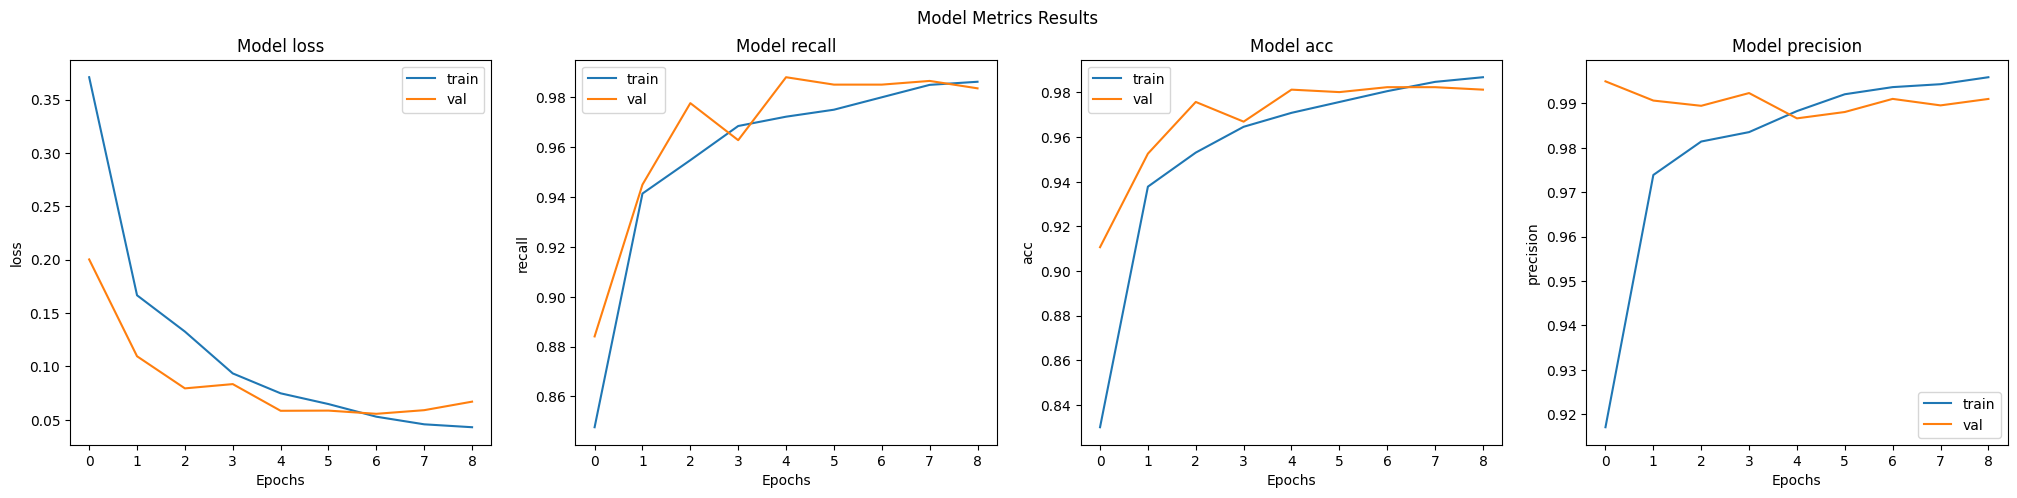

In [86]:
print("Model 5 with updated hyperparamters :\n")
eval_metrics(history5)

In [87]:
train_labels, train_predictions = predict_results(model_5,train_gen)
val_labels, val_predictions = predict_results(model_5,val_gen)

1/2 [==============>...............] - ETA: 0s

2023-03-29 00:18:13.028210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


Training Confusion Matrices:



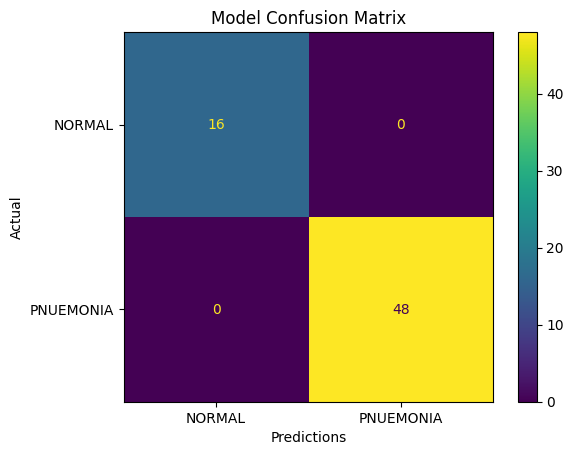

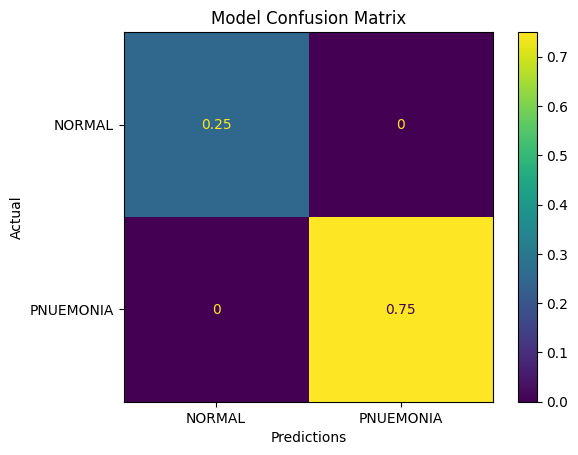

Validation Confusion Matrices:



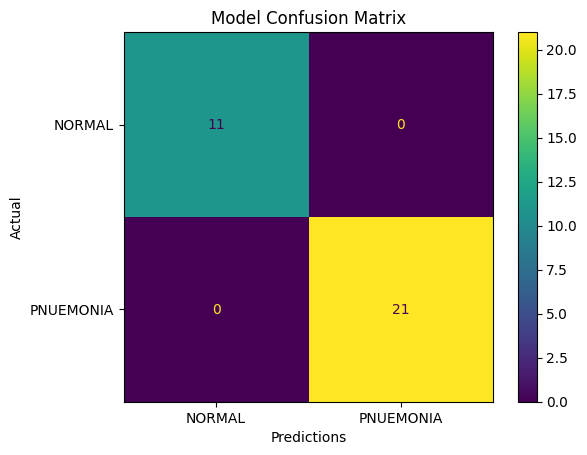

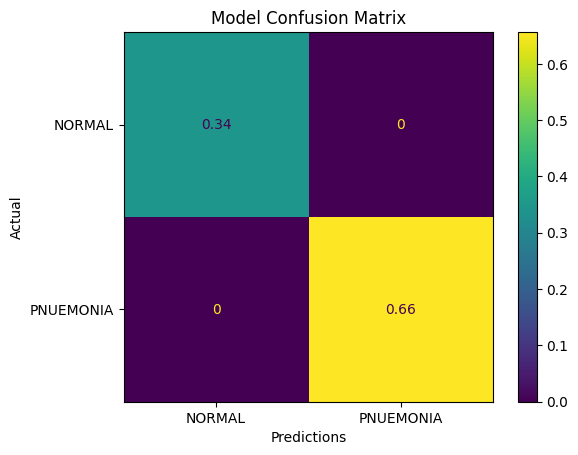

In [88]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [89]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history5)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        48

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64



68/68 [==============================] - 22s 320ms/step - loss: 0.0206 - acc: 0.9931 - recall: 0.9907 - precision: 1.0000
Loss: 0.0206


In [90]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history5)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      1.00      1.00        21

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



29/29 [==============================] - 5s 152ms/step - loss: 0.0670 - acc: 0.9813 - recall: 0.9837 - precision: 0.9910
Loss: 0.067


### Model 5 Evaluation - Needs Update

- Model Plots: The metrics seem to be converging better.
- Confusion Matrix: None of the models have FN or FP.
- Report: The validation recall is about .98, less than other models but still solid.
- Ths model wasn't bad. The validation's loss increased. The recall and f1score decreased from the previous model metrics.

---

# Data Augmentation

[Data Augmentation, YASSINE GHOUZAM, 2017](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

After several iterations of hyperparameter changes, the data will be augmented to see if this helps the models.  
- rotation_range=10,  randomly rotate images in the range (degrees, 0 to 180)
- zoom_range = [.1,.2], Randomly zoom image 
- width_shift_range=[.1,.2], randomly shift images horizontally (fraction of total width)
- height_shift_range=[.1,.2], Shift height

In [91]:
datagen = ImageDataGenerator(rescale=1/255,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = [.1,.2], # Randomly zoom image 
        width_shift_range=[.1,.2],  # randomly shift images horizontally (fraction of total width)
        height_shift_range=[.1,.2],  # randomly shift images vertically (fraction of total height))  
                            )

In [92]:

train_gen_aug = datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=128,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   seed = 42)

                                                    

Found 4325 images belonging to 2 classes.


# Model 6 (Model 5 with different augmented training data)

In [ ]:
#Using the same model with augmented data
model_6 = model_5

In [93]:
history6 = model_5.fit(train_gen_aug,batch_size=128,
                       epochs=90,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

Epoch 1/90
34/34 - 44s - loss: 0.7326 - acc: 0.6079 - recall: 0.7100 - precision: 0.7487 - val_loss: 0.6572 - val_acc: 0.7453 - val_recall: 0.9614 - val_precision: 0.7594 - 44s/epoch - 1s/step
Epoch 2/90
34/34 - 44s - loss: 0.6524 - acc: 0.7403 - recall: 0.9907 - precision: 0.7442 - val_loss: 0.6512 - val_acc: 0.7409 - val_recall: 0.9792 - val_precision: 0.7489 - 44s/epoch - 1s/step
Epoch 3/90
34/34 - 44s - loss: 0.6447 - acc: 0.7385 - recall: 0.9763 - precision: 0.7481 - val_loss: 0.7393 - val_acc: 0.2811 - val_recall: 0.0312 - val_precision: 1.0000 - 44s/epoch - 1s/step
Epoch 4/90
34/34 - 44s - loss: 0.6529 - acc: 0.6966 - recall: 0.9100 - precision: 0.7406 - val_loss: 0.6340 - val_acc: 0.7442 - val_recall: 0.9896 - val_precision: 0.7475 - 44s/epoch - 1s/step
Epoch 5/90
34/34 - 43s - loss: 0.6501 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422 - val_loss: 0.6383 - val_acc: 0.7431 - val_recall: 0.9926 - val_precision: 0.7455 - 43s/epoch - 1s/step
Epoch 6/90
34/34 - 44s - loss: 0.64

Model 6 with augmented data :



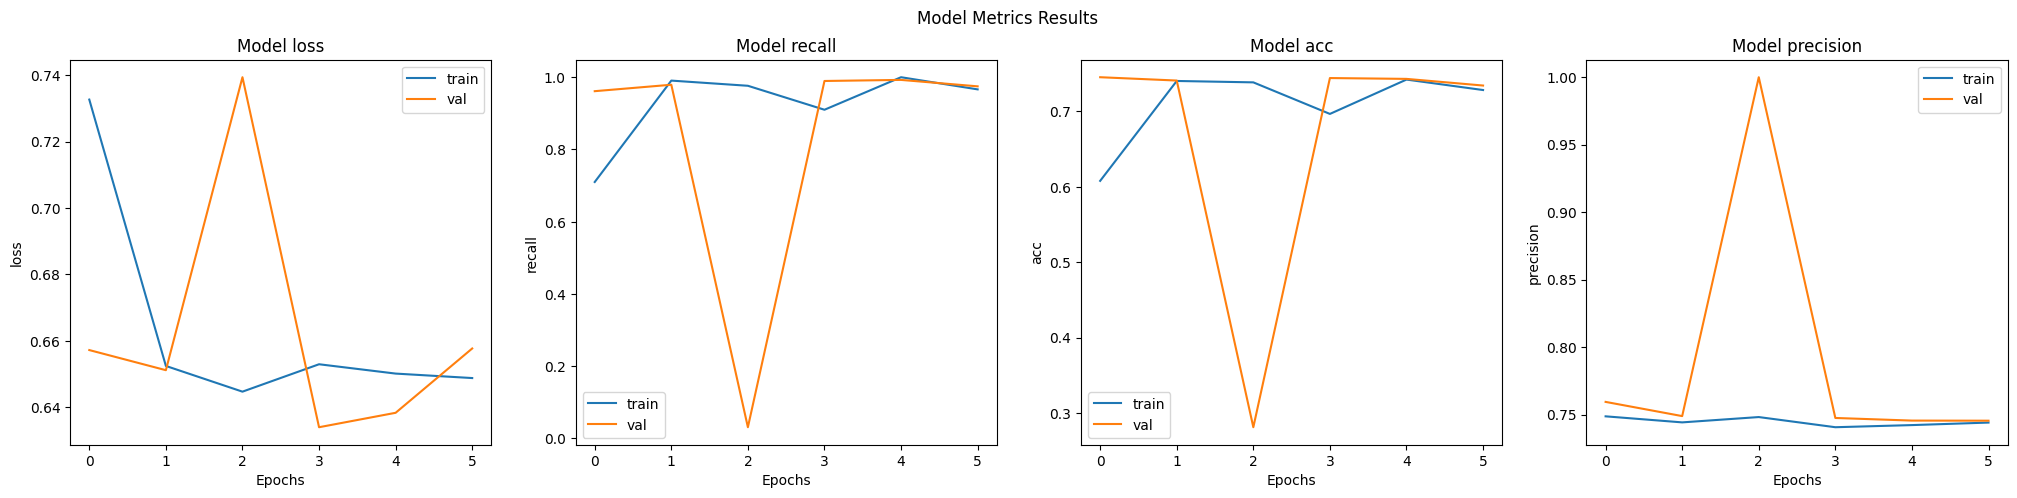

In [94]:
print("Model 6 with augmented data :\n")
eval_metrics(history6)


In [95]:
train_labels, train_predictions = predict_results(model_5,train_gen_aug)
val_labels, val_predictions = predict_results(model_5,val_gen)

1/1 [==============================] - 0s 14ms/step


Training Confusion Matrices:



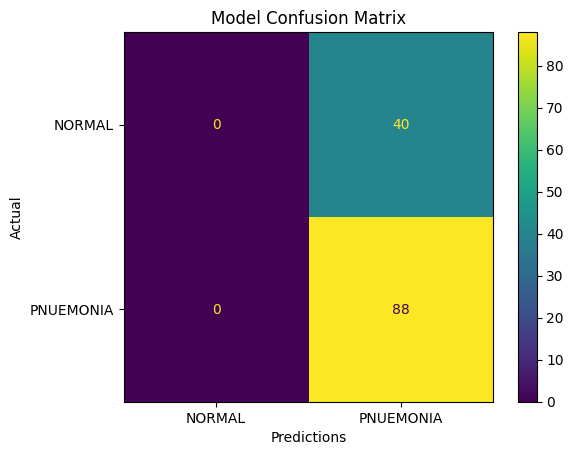

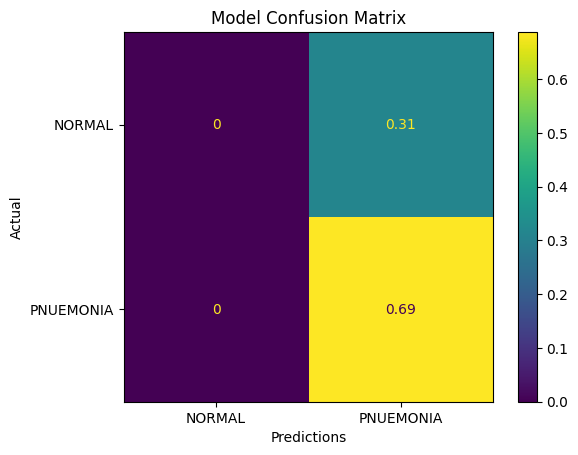

Validation Confusion Matrices:



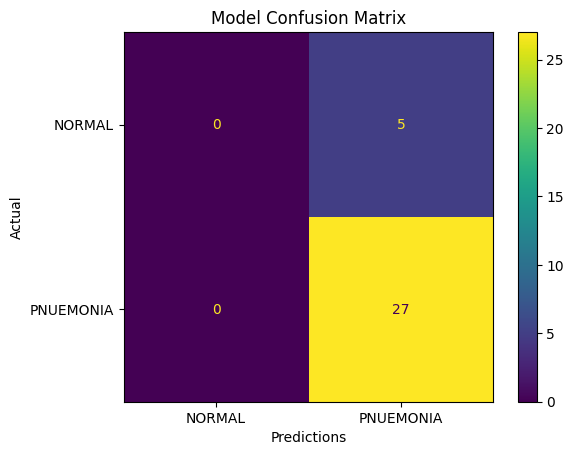

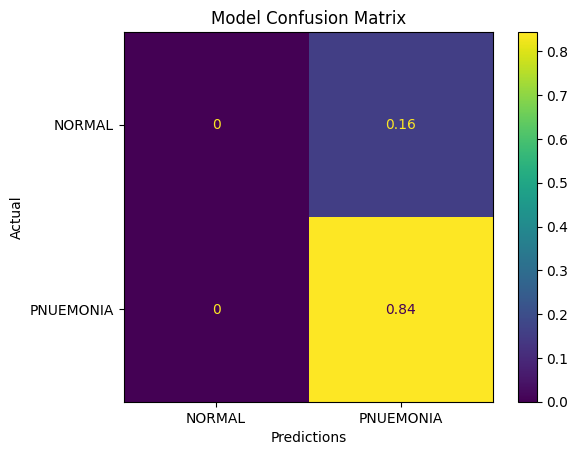

In [96]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [97]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history6)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        40
         1.0       0.69      1.00      0.81        88

    accuracy                           0.69       128
   macro avg       0.34      0.50      0.41       128
weighted avg       0.47      0.69      0.56       128



68/68 [==============================] - 22s 316ms/step - loss: 0.6567 - acc: 0.7392 - recall: 0.9685 - precision: 0.7517
Loss: 0.6567


In [98]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history6)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.84      1.00      0.92        27

    accuracy                           0.84        32
   macro avg       0.42      0.50      0.46        32
weighted avg       0.71      0.84      0.77        32



29/29 [==============================] - 5s 155ms/step - loss: 0.6577 - acc: 0.7343 - recall: 0.9747 - precision: 0.7455
Loss: 0.6577


### Model 6 Evaluation - Needs Updating

Using augmented training data produced the worst results so far. Epoch 2 caused the most variation. The model had no False Negatives, but many False Positives. The training data trained on 30% of Normal values in a batch. The loss is the highest so far in all iterations. The augmented data will not be used in the next iteration.

# Model 7 - Learning Rate Optimization

Using gridsearch and keras wrappers to do some hyperparameter optimization
- learning_rate = [.001,.01,.1,.2] 

Description of the model hyperparameters and data parameters:

- **Model***
    - layers: 3 Conv2D each w/ MaxPooling2D, 3 Dense output layers
    - filters: 32,64,96,128 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - dropout:** .5 between the dense output layers
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - **learning rate:** .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 128
    - epochs: 90
    - early stopping : True
    - class weights: {0: 1.6, 1: 0.7272727272727273}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [101]:
def buildModel(learning_rate):

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(units=128, activation='relu',), 
    Dropout(.3),
    Dense(units=64, activation='relu'),
    Dropout(.3),    
    Dense(units=1, activation='sigmoid'),
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer = Adam(learning_rate = learning_rate, ),
                    metrics=["acc","Recall","Precision"])

    
    return model

Learning rate determines the weights of out neural network with respect to the loss gradient. 

In [102]:
learning_rate = [.001,.01,.1,.2]
parameters_3 = dict( learning_rate=learning_rate)
parameters_3

{'learning_rate': [0.001, 0.01, 0.1, 0.2]}

In [103]:

classifier = KerasClassifier(build_fn=buildModel, batch_size = 128, epochs = 90, class_weight = class_weights)
#What hyperparameter we want to play with

grid_search = GridSearchCV(estimator = classifier,
                           error_score="raise",
                           param_grid = parameters_3,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
gs_3 = grid_search.fit(X_train, y_train, verbose = 1)

Epoch 1/90


2023-03-29 01:09:25.357383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6461 - acc: 0.7143 - recall: 0.7812 - precision: 0.8333
Epoch 2/90
1/1 [==============================] - 0s 268ms/step - loss: 0.6403 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 3/90
1/1 [==============================] - 0s 245ms/step - loss: 0.6806 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 4/90
1/1 [==============================] - 0s 227ms/step - loss: 0.6596 - acc: 0.7143 - recall: 0.9375 - precision: 0.7500
Epoch 5/90
1/1 [==============================] - 0s 256ms/step - loss: 0.6433 - acc: 0.6905 - recall: 0.8438 - precision: 0.7714
Epoch 6/90
1/1 [==============================] - 0s 94ms/step - loss: 0.6333 - acc: 0.7857 - recall: 0.9688 - precision: 0.7949
Epoch 7/90
1/1 [==============================] - 0s 62ms/step - loss: 0.6416 - acc: 0.7381 - recall: 0.9688 - precision: 0.7561
Epoch 8/90
1/1 [==============================] - 0s 254ms/step - loss: 0.6467 - acc: 0.7381 - recall: 0.9

1/1 [==============================] - 0s 46ms/step - loss: 0.0926 - acc: 0.9286 - recall: 0.9062 - precision: 1.0000
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1146 - acc: 0.9286 - recall: 0.9375 - precision: 0.9677
Epoch 66/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1835 - acc: 0.9048 - recall: 0.9375 - precision: 0.9375
Epoch 67/90
1/1 [==============================] - 0s 47ms/step - loss: 0.1027 - acc: 0.9524 - recall: 0.9375 - precision: 1.0000
Epoch 68/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0990 - acc: 0.9524 - recall: 0.9375 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0854 - acc: 0.9524 - recall: 0.9375 - precision: 1.0000
Epoch 70/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0645 - acc: 0.9762 - recall: 0.9688 - precision: 1.0000
Epoch 71/90
1/1 [==============================] - 0s 46ms/step - loss: 0.0988 - acc: 0.9524 - recall:

2023-03-29 01:09:34.077544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 246ms/step
Epoch 1/90


2023-03-29 01:09:35.239296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7013 - acc: 0.4884 - recall: 0.4828 - precision: 0.6667
Epoch 2/90
1/1 [==============================] - 0s 198ms/step - loss: 0.7059 - acc: 0.5349 - recall: 0.6552 - precision: 0.6552
Epoch 3/90
1/1 [==============================] - 0s 298ms/step - loss: 0.6957 - acc: 0.6047 - recall: 0.5517 - precision: 0.8000
Epoch 4/90
1/1 [==============================] - 0s 258ms/step - loss: 0.6905 - acc: 0.5581 - recall: 0.5862 - precision: 0.7083
Epoch 5/90
1/1 [==============================] - 0s 248ms/step - loss: 0.7126 - acc: 0.5581 - recall: 0.6207 - precision: 0.6923
Epoch 6/90
1/1 [==============================] - 0s 81ms/step - loss: 0.6942 - acc: 0.5349 - recall: 0.5172 - precision: 0.7143
Epoch 7/90
1/1 [==============================] - 0s 159ms/step - loss: 0.6859 - acc: 0.4651 - recall: 0.2414 - precision: 0.8750
Epoch 8/90
1/1 [==============================] - 0s 148ms/step - loss: 0.6847 - acc: 0.4419 - recall: 0.

1/1 [==============================] - 0s 52ms/step - loss: 0.0224 - acc: 0.9767 - recall: 0.9655 - precision: 1.0000
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0123 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0243 - acc: 0.9767 - recall: 0.9655 - precision: 1.0000
Epoch 67/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0158 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/90
1/1 [==============================] - 0s 51ms/step - loss: 0.0053 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0093 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/90
1/1 [==============================] - 0s 47ms/step - loss: 0.0199 - acc: 0.9767 - recall: 0.9655 - precision: 1.0000
Epoch 71/90
1/1 [==============================] - 0s 48ms/step - loss: 0.0177 - acc: 1.0000 - recall:

2023-03-29 01:09:44.103305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 181ms/step
Epoch 1/90


2023-03-29 01:09:45.522696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7289 - acc: 0.6047 - recall: 0.7037 - precision: 0.6786
Epoch 2/90
1/1 [==============================] - 0s 272ms/step - loss: 0.7105 - acc: 0.3953 - recall: 0.0370 - precision: 1.0000
Epoch 3/90
1/1 [==============================] - 0s 277ms/step - loss: 0.7724 - acc: 0.3488 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/90
1/1 [==============================] - 0s 165ms/step - loss: 0.7205 - acc: 0.3256 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 5/90
1/1 [==============================] - 0s 160ms/step - loss: 0.7200 - acc: 0.3953 - recall: 0.1111 - precision: 0.6000
Epoch 6/90
1/1 [==============================] - 0s 87ms/step - loss: 0.7280 - acc: 0.3953 - recall: 0.1111 - precision: 0.6000
Epoch 7/90
1/1 [==============================] - 0s 248ms/step - loss: 0.7151 - acc: 0.4186 - recall: 0.1481 - precision: 0.6667
Epoch 8/90
1/1 [==============================] - 0s 157ms/step - loss: 0.6983 - acc: 0.4

2023-03-29 01:09:54.048731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 175ms/step
Epoch 1/90


2023-03-29 01:09:55.084304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6505 - acc: 0.3810 - recall: 0.4688 - precision: 0.6250
Epoch 2/90
1/1 [==============================] - 0s 255ms/step - loss: 23.5721 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 3/90
1/1 [==============================] - 0s 257ms/step - loss: 0.7884 - acc: 0.2381 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/90
1/1 [==============================] - 0s 252ms/step - loss: 0.6696 - acc: 0.2619 - recall: 0.0312 - precision: 1.0000
Epoch 5/90
1/1 [==============================] - 0s 169ms/step - loss: 0.6475 - acc: 0.4762 - recall: 0.5312 - precision: 0.7083
Epoch 6/90
1/1 [==============================] - 0s 148ms/step - loss: 0.6358 - acc: 0.7381 - recall: 0.9375 - precision: 0.7692
Epoch 7/90
1/1 [==============================] - 0s 141ms/step - loss: 0.6594 - acc: 0.7381 - recall: 0.9062 - precision: 0.7838
Epoch 8/90
1/1 [==============================] - 0s 154ms/step - loss: 0.7123 - acc: 0.3095 - 

Epoch 64/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6336 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 65/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6268 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 66/90
1/1 [==============================] - 0s 46ms/step - loss: 0.6321 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 67/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6332 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 68/90
1/1 [==============================] - 0s 141ms/step - loss: 0.6279 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 69/90
1/1 [==============================] - 0s 49ms/step - loss: 0.6362 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 70/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6307 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 71/90
1/1 [==============================] - 0s 47ms/step - loss: 0.6197 - acc: 0.7

2023-03-29 01:10:03.606718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 179ms/step
Epoch 1/90


2023-03-29 01:10:04.688276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7028 - acc: 0.5349 - recall: 0.6207 - precision: 0.6667
Epoch 2/90
1/1 [==============================] - 0s 266ms/step - loss: 17.4490 - acc: 0.3256 - recall: 0.1379 - precision: 0.5000
Epoch 3/90
1/1 [==============================] - 0s 216ms/step - loss: 0.8125 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 4/90
1/1 [==============================] - 0s 239ms/step - loss: 0.7096 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 5/90
1/1 [==============================] - 0s 155ms/step - loss: 0.7058 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 6/90
1/1 [==============================] - 0s 270ms/step - loss: 0.7014 - acc: 0.5349 - recall: 0.5172 - precision: 0.7143
Epoch 7/90
1/1 [==============================] - 0s 162ms/step - loss: 0.7025 - acc: 0.4186 - recall: 0.4828 - precision: 0.5833
Epoch 8/90
1/1 [==============================] - 0s 85ms/step - loss: 0.7037 - acc: 0.5349 - recall: 0

2023-03-29 01:10:13.275835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 170ms/step
Epoch 1/90


2023-03-29 01:10:14.364206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7281 - acc: 0.5581 - recall: 0.5185 - precision: 0.7000
Epoch 2/90
1/1 [==============================] - 0s 271ms/step - loss: 54.4978 - acc: 0.3953 - recall: 0.0370 - precision: 1.0000
Epoch 3/90
1/1 [==============================] - 0s 252ms/step - loss: 0.8251 - acc: 0.6279 - recall: 1.0000 - precision: 0.6279
Epoch 4/90
1/1 [==============================] - 0s 81ms/step - loss: 0.9478 - acc: 0.6047 - recall: 0.9630 - precision: 0.6190
Epoch 5/90
1/1 [==============================] - 0s 245ms/step - loss: 0.7253 - acc: 0.5814 - recall: 0.7037 - precision: 0.6552
Epoch 6/90
1/1 [==============================] - 0s 168ms/step - loss: 0.7281 - acc: 0.3953 - recall: 0.1111 - precision: 0.6000
Epoch 7/90
1/1 [==============================] - 0s 216ms/step - loss: 0.7129 - acc: 0.3721 - recall: 0.0370 - precision: 0.5000
Epoch 8/90
1/1 [==============================] - 0s 74ms/step - loss: 0.7678 - acc: 0.4419 - recall: 0.

2023-03-29 01:10:22.605641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 163ms/step
Epoch 1/90


2023-03-29 01:10:24.283495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6502 - acc: 0.4286 - recall: 0.5000 - precision: 0.6667
Epoch 2/90
1/1 [==============================] - 0s 261ms/step - loss: 102357680.0000 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 3/90
1/1 [==============================] - 0s 177ms/step - loss: 13674.0713 - acc: 0.2381 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/90
1/1 [==============================] - 0s 259ms/step - loss: 525595.6250 - acc: 0.2143 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 5/90
1/1 [==============================] - 0s 140ms/step - loss: 419296.6875 - acc: 0.7381 - recall: 0.9688 - precision: 0.7561
Epoch 6/90
1/1 [==============================] - 0s 140ms/step - loss: 255544.4375 - acc: 0.5476 - recall: 0.6250 - precision: 0.7407
Epoch 7/90
1/1 [==============================] - 0s 167ms/step - loss: 56981296.0000 - acc: 0.2381 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 8/90
1/1 [==============================

2023-03-29 01:10:32.490045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 384ms/step
Epoch 1/90


2023-03-29 01:10:33.827700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6966 - acc: 0.6977 - recall: 0.7586 - precision: 0.7857
Epoch 2/90
1/1 [==============================] - 0s 188ms/step - loss: 106103368.0000 - acc: 0.6744 - recall: 0.6897 - precision: 0.8000
Epoch 3/90
1/1 [==============================] - 0s 264ms/step - loss: 158.2381 - acc: 0.3256 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/90
1/1 [==============================] - 0s 78ms/step - loss: 24.2246 - acc: 0.4651 - recall: 0.6207 - precision: 0.6000
Epoch 5/90
1/1 [==============================] - 0s 255ms/step - loss: 2465.8542 - acc: 0.3488 - recall: 0.1724 - precision: 0.5556
Epoch 6/90
1/1 [==============================] - 0s 80ms/step - loss: 500.4754 - acc: 0.6047 - recall: 0.7241 - precision: 0.7000
Epoch 7/90
1/1 [==============================] - 0s 212ms/step - loss: 23.4519 - acc: 0.6744 - recall: 0.9310 - precision: 0.6923
Epoch 8/90
1/1 [==============================] - 0s 170ms/step - loss: 4.1689 - 

2023-03-29 01:10:42.025295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 216ms/step
Epoch 1/90


2023-03-29 01:10:43.090431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7278 - acc: 0.6977 - recall: 0.8148 - precision: 0.7333
Epoch 2/90
1/1 [==============================] - 0s 197ms/step - loss: 543252864.0000 - acc: 0.3721 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 3/90
1/1 [==============================] - 1s 505ms/step - loss: 7723.7158 - acc: 0.6279 - recall: 1.0000 - precision: 0.6279
Epoch 4/90
1/1 [==============================] - 0s 274ms/step - loss: 265605.0938 - acc: 0.6279 - recall: 1.0000 - precision: 0.6279
Epoch 5/90
1/1 [==============================] - 0s 257ms/step - loss: 1050842.5000 - acc: 0.6047 - recall: 0.9630 - precision: 0.6190
Epoch 6/90
1/1 [==============================] - 0s 162ms/step - loss: 679000.3750 - acc: 0.3953 - recall: 0.3704 - precision: 0.5263
Epoch 7/90
1/1 [==============================] - 0s 132ms/step - loss: 177630.2500 - acc: 0.3488 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 8/90
1/1 [==============================] - 0s 154

2023-03-29 01:10:51.881133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 226ms/step
Epoch 1/90


2023-03-29 01:10:52.956858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6491 - acc: 0.4286 - recall: 0.4375 - precision: 0.7000
Epoch 2/90
1/1 [==============================] - 0s 268ms/step - loss: 63209684992.0000 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 3/90
1/1 [==============================] - 0s 261ms/step - loss: 5674255.0000 - acc: 0.2381 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 4/90
1/1 [==============================] - 0s 253ms/step - loss: 1072300.3750 - acc: 0.5000 - recall: 0.5625 - precision: 0.7200
Epoch 5/90
1/1 [==============================] - 0s 186ms/step - loss: 26558562.0000 - acc: 0.3571 - recall: 0.1562 - precision: 1.0000
Epoch 6/90
1/1 [==============================] - 0s 172ms/step - loss: 2035727.2500 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 7/90
1/1 [==============================] - 0s 145ms/step - loss: 1640176.7500 - acc: 0.7619 - recall: 1.0000 - precision: 0.7619
Epoch 8/90
1/1 [==============================] - 0s 59

2023-03-29 01:11:01.355120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 173ms/step
Epoch 1/90


2023-03-29 01:11:02.774661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7005 - acc: 0.4884 - recall: 0.5862 - precision: 0.6296
Epoch 2/90
1/1 [==============================] - 0s 177ms/step - loss: 51709915136.0000 - acc: 0.3488 - recall: 0.0345 - precision: 1.0000
Epoch 3/90
1/1 [==============================] - 0s 260ms/step - loss: 31707424.0000 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 4/90
1/1 [==============================] - 0s 169ms/step - loss: 16377134.0000 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 5/90
1/1 [==============================] - 0s 185ms/step - loss: 556470.6250 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 6/90
1/1 [==============================] - 0s 168ms/step - loss: 1438093.0000 - acc: 0.6744 - recall: 1.0000 - precision: 0.6744
Epoch 7/90
1/1 [==============================] - 0s 163ms/step - loss: 116715.1953 - acc: 0.3256 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 8/90
1/1 [==============================] - 0s 154

2023-03-29 01:11:11.346832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 240ms/step
Epoch 1/90


2023-03-29 01:11:12.450834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7284 - acc: 0.6279 - recall: 0.7037 - precision: 0.7037
Epoch 2/90
1/1 [==============================] - 0s 261ms/step - loss: 142840823808.0000 - acc: 0.3721 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 3/90
1/1 [==============================] - 0s 267ms/step - loss: 8738413.0000 - acc: 0.6279 - recall: 1.0000 - precision: 0.6279
Epoch 4/90
1/1 [==============================] - 0s 363ms/step - loss: 152109648.0000 - acc: 0.6279 - recall: 1.0000 - precision: 0.6279
Epoch 5/90
1/1 [==============================] - 0s 259ms/step - loss: 24155984.0000 - acc: 0.3721 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 6/90
1/1 [==============================] - 0s 143ms/step - loss: 5359326.5000 - acc: 0.5349 - recall: 0.4074 - precision: 0.7333
Epoch 7/90
1/1 [==============================] - 0s 272ms/step - loss: 62771068.0000 - acc: 0.3721 - recall: 0.0000e+00 - precision: 0.0000e+00
Epoch 8/90
1/1 [===================

2023-03-29 01:11:21.217960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 180ms/step
Epoch 1/90


2023-03-29 01:11:22.307677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6944 - acc: 0.4531 - recall: 0.4545 - precision: 0.6452
Epoch 2/90
1/1 [==============================] - 0s 281ms/step - loss: 0.6958 - acc: 0.5625 - recall: 0.6136 - precision: 0.7105
Epoch 3/90
1/1 [==============================] - 0s 272ms/step - loss: 0.6960 - acc: 0.4375 - recall: 0.3409 - precision: 0.6818
Epoch 4/90
1/1 [==============================] - 0s 273ms/step - loss: 0.6900 - acc: 0.3750 - recall: 0.1818 - precision: 0.6667
Epoch 5/90
1/1 [==============================] - 0s 371ms/step - loss: 0.6865 - acc: 0.4688 - recall: 0.2955 - precision: 0.8125
Epoch 6/90
1/1 [==============================] - 0s 262ms/step - loss: 0.6821 - acc: 0.4219 - recall: 0.2273 - precision: 0.7692
Epoch 7/90
1/1 [==============================] - 0s 180ms/step - loss: 0.6950 - acc: 0.4062 - recall: 0.2273 - precision: 0.7143
Epoch 8/90
1/1 [==============================] - 0s 189ms/step - loss: 0.6917 - acc: 0.4375 - recall: 0

1/1 [==============================] - 0s 68ms/step - loss: 0.0258 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 65/90
1/1 [==============================] - 0s 75ms/step - loss: 0.0407 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 66/90
1/1 [==============================] - 0s 71ms/step - loss: 0.0235 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 67/90
1/1 [==============================] - 0s 73ms/step - loss: 0.0161 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 68/90
1/1 [==============================] - 0s 77ms/step - loss: 0.0178 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 69/90
1/1 [==============================] - 0s 85ms/step - loss: 0.0084 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 70/90
1/1 [==============================] - 0s 93ms/step - loss: 0.0068 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000
Epoch 71/90
1/1 [==============================] - 0s 102ms/step - loss: 0.0091 - acc: 1.0000 - recall

In [104]:
print("Best: %f using %s" % (gs_3.best_score_, gs_3.best_params_))

Best: 0.719336 using {'learning_rate': 0.001}


This  .001 is the defult learning rate, nothing modifications and additons will be done. The results will be same as Model Iteration 5.

---

# Transfer Learning

Using pretrained models from another problem and using them on another problem
- VGG19 Pre-Trained Model <br>
    This method has faster training speed, fewer training samples per time, and higher accuracy
- Feature Extraction without augmented data
- Feature Extraction with augmented data
- Fine Tuning

In [133]:
#The imagenet weights are downloaded from online
cnn_base = VGG19(weights="imagenet", 
                 include_top=False, 
                 input_shape=(224, 224, 3))

In [134]:
#Creating the model layer architecture including cnn_base (19 layers)
model_8 = models.Sequential()
model_8.add(cnn_base)
model_8.add(layers.Flatten())
model_8.add(layers.Dense(132, activation='relu'))
model_8.add(layers.Dense(1, activation='sigmoid'))

In [135]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [136]:
model_8.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_144 (Flatten)       (None, 25088)             0         
                                                                 
 dense_377 (Dense)           (None, 132)               3311748   
                                                                 
 dense_378 (Dense)           (None, 1)                 133       
                                                                 
Total params: 23,336,265
Trainable params: 23,336,265
Non-trainable params: 0
_________________________________________________________________


In [137]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_8.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_8.trainable_weights))

vgg19 True
flatten_144 True
dense_377 True
dense_378 True
36


In [138]:
# Freeze the model
cnn_base.trainable = False

In [139]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_8.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_8.trainable_weights))

vgg19 False
flatten_144 True
dense_377 True
dense_378 True
4


In [140]:
model_8.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [141]:
#Copying model before trained for Augmented Data Fitting
model_9 = model_8

In [142]:
#Fitting with regular training data
history8 = model_8.fit(train_gen,batch_size=128,
                       epochs=90,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen, 
                      callbacks = es) #stopping early because of time resources

Epoch 1/90


2023-03-29 01:53:09.670361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 01:53:36.163388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 34s - loss: 0.3384 - acc: 0.8548 - recall: 0.8654 - precision: 0.9341 - val_loss: 0.1117 - val_acc: 0.9636 - val_recall: 0.9703 - val_precision: 0.9805 - 34s/epoch - 496ms/step
Epoch 2/90
68/68 - 29s - loss: 0.1052 - acc: 0.9653 - recall: 0.9629 - precision: 0.9901 - val_loss: 0.0725 - val_acc: 0.9746 - val_recall: 0.9777 - val_precision: 0.9880 - 29s/epoch - 432ms/step
Epoch 3/90
68/68 - 30s - loss: 0.0742 - acc: 0.9757 - recall: 0.9760 - precision: 0.9911 - val_loss: 0.0874 - val_acc: 0.9669 - val_recall: 0.9599 - val_precision: 0.9954 - 30s/epoch - 442ms/step
Epoch 4/90
68/68 - 30s - loss: 0.0597 - acc: 0.9773 - recall: 0.9748 - precision: 0.9946 - val_loss: 0.0581 - val_acc: 0.9813 - val_recall: 0.9822 - val_precision: 0.9925 - 30s/epoch - 448ms/step
Epoch 5/90
68/68 - 32s - loss: 0.0422 - acc: 0.9866 - recall: 0.9860 - precision: 0.9959 - val_loss: 0.0674 - val_acc: 0.9757 - val_recall: 0.9747 - val_precision: 0.9924 - 32s/epoch - 464ms/step
Epoch 6/90
68/68 - 30s - loss: 

Model 8 with augmented data :



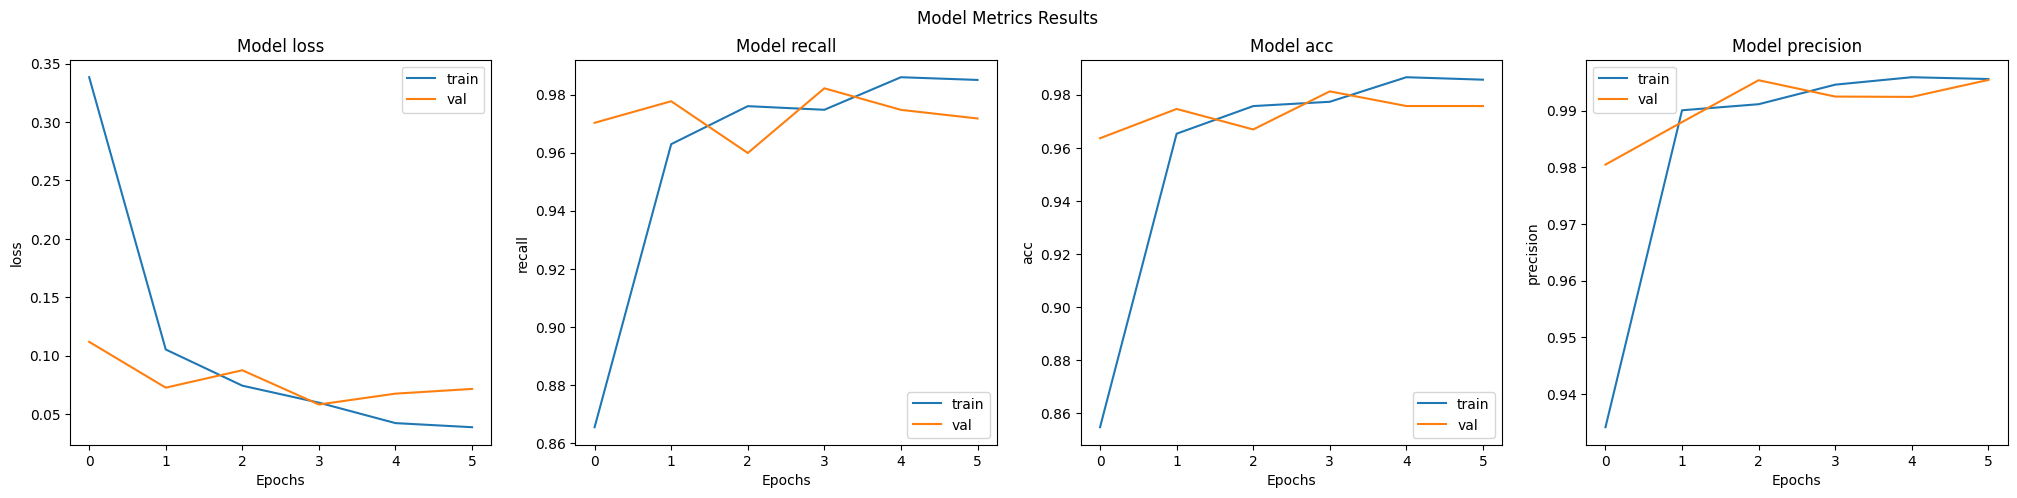

In [143]:
print("Model 8 with augmented data :\n")
eval_metrics(history8)

In [144]:
train_labels, train_predictions = predict_results(model_8,train_gen_aug)
val_labels, val_predictions = predict_results(model_8,val_gen)

2023-03-29 02:00:48.631176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step


Training Confusion Matrices:



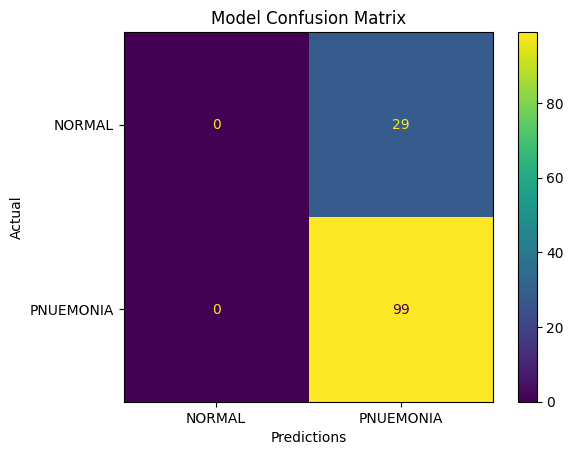

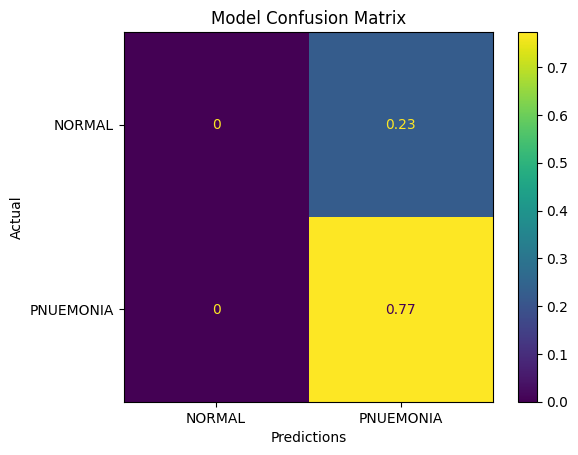

Validation Confusion Matrices:



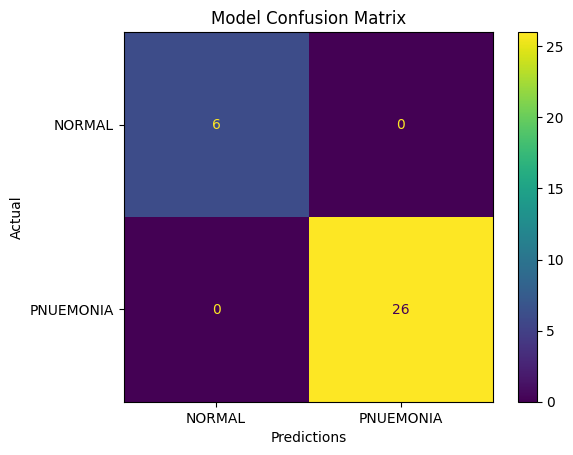

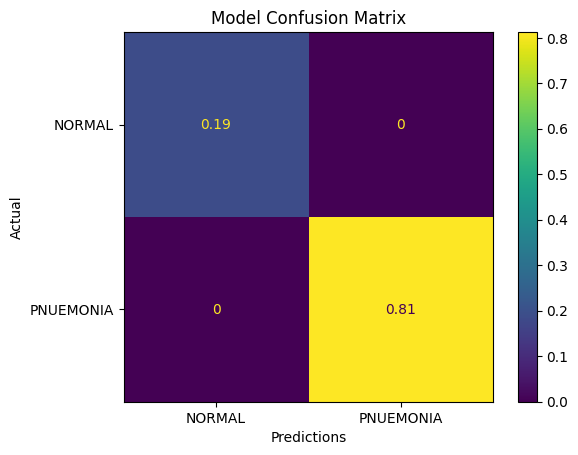

In [145]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [146]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen_aug,history8)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        29
         1.0       0.77      1.00      0.87        99

    accuracy                           0.77       128
   macro avg       0.39      0.50      0.44       128
weighted avg       0.60      0.77      0.67       128



34/34 [==============================] - 42s 1s/step - loss: 1.7944 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422
Loss: 1.7944


In [148]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history8)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00        26

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



29/29 [==============================] - 5s 174ms/step - loss: 0.0714 - acc: 0.9757 - recall: 0.9718 - precision: 0.9954
Loss: 0.0714


## Transfer Model 10 Evaluation

The model is one of top models. The validation data performed better than the training data score. There were no wrong predictions on the validation data and the loss is much less than the training set.


---

# Transfer Model 9 w/ Augmented Data

In [149]:
#Fitting with augmented data
history9 = model_9.fit(train_gen_aug,batch_size=128,
                       epochs=90,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen, 
                      callbacks = es) #stopping early because of time resources

Epoch 1/90
34/34 - 47s - loss: 0.8832 - acc: 0.6090 - recall: 0.6664 - precision: 0.7753 - val_loss: 2.7920 - val_acc: 0.2580 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 47s/epoch - 1s/step
Epoch 2/90
34/34 - 49s - loss: 0.5470 - acc: 0.7334 - recall: 0.7738 - precision: 0.8533 - val_loss: 2.4111 - val_acc: 0.2591 - val_recall: 0.0015 - val_precision: 1.0000 - 49s/epoch - 1s/step
Epoch 3/90
34/34 - 48s - loss: 0.5309 - acc: 0.7519 - recall: 0.8034 - precision: 0.8537 - val_loss: 2.4328 - val_acc: 0.2591 - val_recall: 0.0015 - val_precision: 1.0000 - 48s/epoch - 1s/step
Epoch 4/90
34/34 - 47s - loss: 0.5006 - acc: 0.7607 - recall: 0.8022 - precision: 0.8655 - val_loss: 2.4747 - val_acc: 0.2591 - val_recall: 0.0015 - val_precision: 1.0000 - 47s/epoch - 1s/step
Epoch 4: early stopping


Model 9 w augmented data :



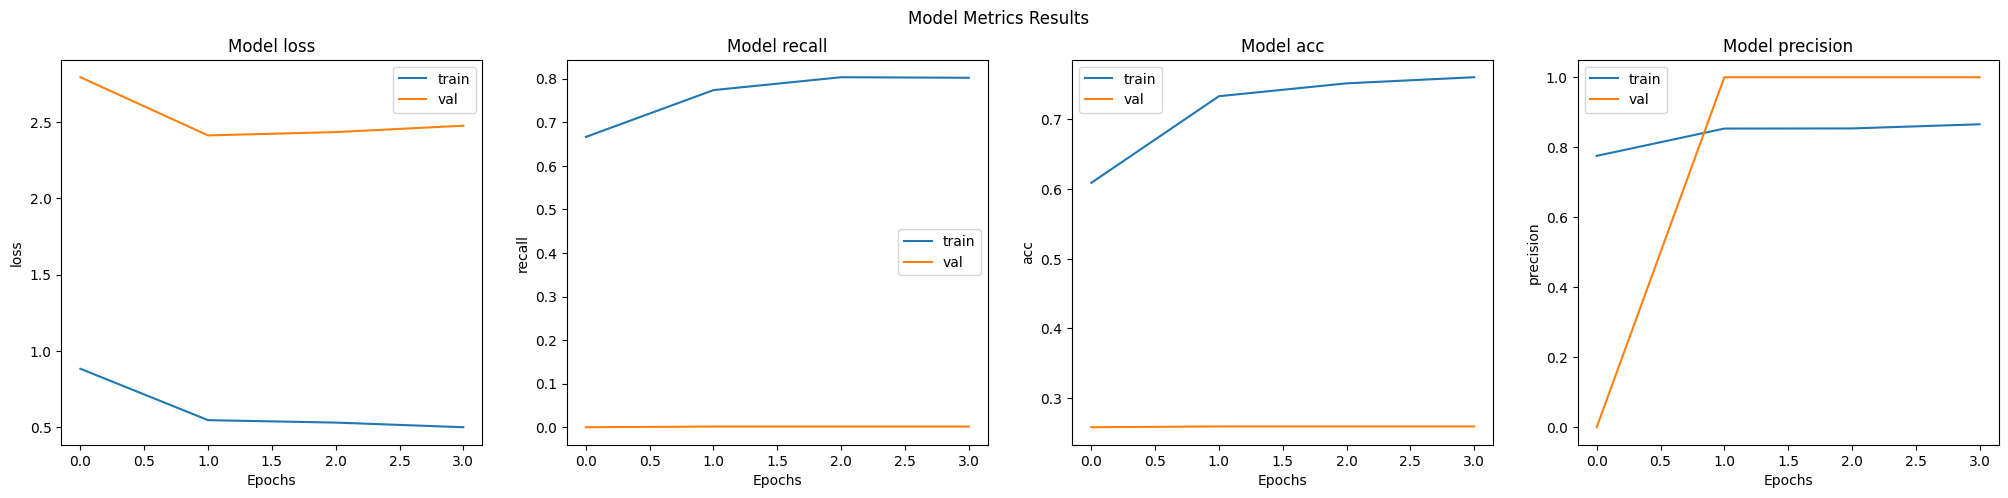

In [150]:
print("Model 9 w augmented data :\n")
eval_metrics(history9)

In [151]:
train_labels, train_predictions = predict_results(model_9,train_gen)
val_labels, val_predictions = predict_results(model_9,val_gen)

1/1 [==============================] - 0s 18ms/step


Training Confusion Matrices:



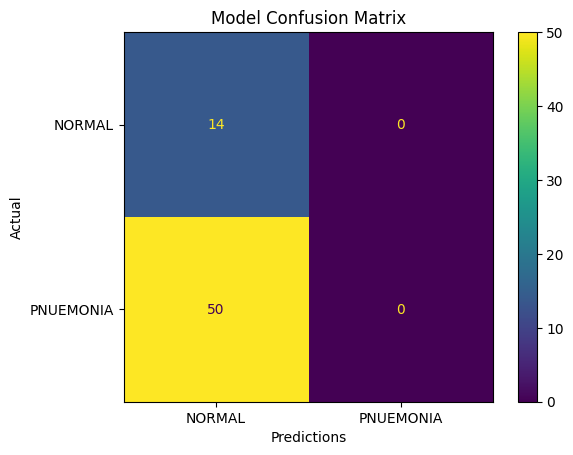

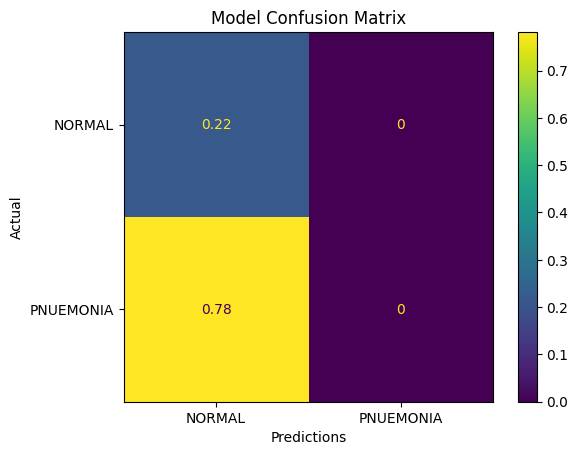

Validation Confusion Matrices:



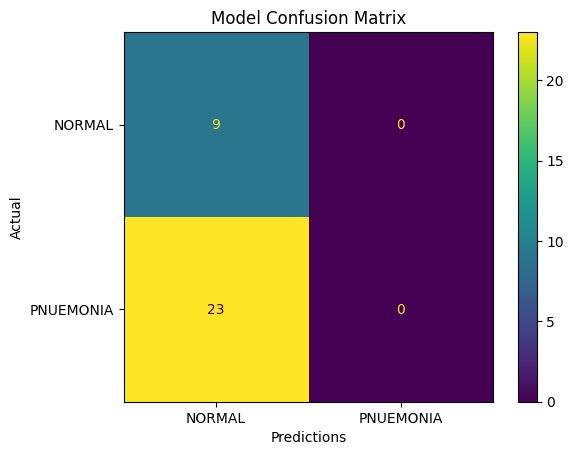

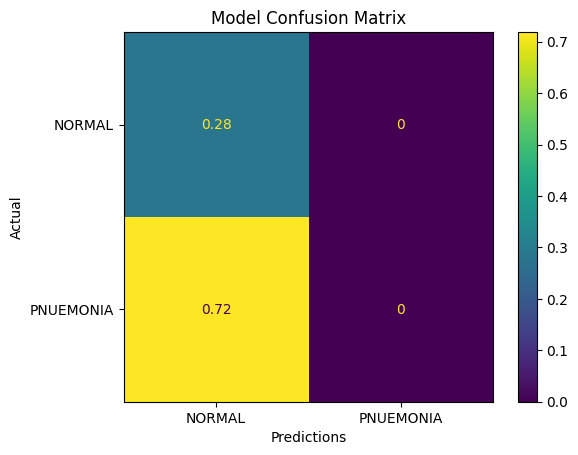

In [152]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [153]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history9)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.22      1.00      0.36        14
         1.0       0.00      0.00      0.00        50

    accuracy                           0.22        64
   macro avg       0.11      0.50      0.18        64
weighted avg       0.05      0.22      0.08        64



68/68 [==============================] - 25s 363ms/step - loss: 2.4967 - acc: 0.2603 - recall: 0.0034 - precision: 1.0000
Loss: 2.4967


In [154]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history9)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.28      1.00      0.44         9
         1.0       0.00      0.00      0.00        23

    accuracy                           0.28        32
   macro avg       0.14      0.50      0.22        32
weighted avg       0.08      0.28      0.12        32



29/29 [==============================] - 5s 180ms/step - loss: 2.4747 - acc: 0.2591 - recall: 0.0015 - precision: 1.0000
Loss: 2.4747


## Transfer Model 9 Evaluation

The Transfer VGG19 model with augmented data was the worst so far. For the validation data there were mostly FN and and some TNs. Pneumonia was not detected. 

Models trainined the augmented training data will not be used.

---

# Transfer Model 10 w/ Fine Tuning

#### Removing a dense layer from the pre trained model

In [155]:
#Copying the models to fine tune
model_10 = model_8
cnn_base_tuned = cnn_base

In [156]:
model_10.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_144 (Flatten)       (None, 25088)             0         
                                                                 
 dense_377 (Dense)           (None, 132)               3311748   
                                                                 
 dense_378 (Dense)           (None, 1)                 133       
                                                                 
Total params: 23,336,265
Trainable params: 3,311,881
Non-trainable params: 20,024,384
_________________________________________________________________


In [157]:
cnn_base_tuned.trainable = True

In [158]:
cnn_base_tuned.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Removing one of the last layers from the pretrained model

In [161]:
cnn_base_tuned.trainable = True
set_trainable = False
for layer in cnn_base_tuned.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [162]:
model_10.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [163]:
history10 = model_10.fit(train_gen,batch_size=128,
                       epochs=90,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen, 
                      callbacks = es) #stopping early because of time resources

Epoch 1/90


2023-03-29 02:18:07.842665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 02:18:35.048026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 34s - loss: 0.8418 - acc: 0.6425 - recall: 0.7688 - precision: 0.7543 - val_loss: 0.6880 - val_acc: 0.7420 - val_recall: 1.0000 - val_precision: 0.7420 - 34s/epoch - 498ms/step
Epoch 2/90
68/68 - 33s - loss: 0.6596 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422 - val_loss: 0.6719 - val_acc: 0.7420 - val_recall: 1.0000 - val_precision: 0.7420 - 33s/epoch - 482ms/step
Epoch 3/90
68/68 - 33s - loss: 0.6540 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422 - val_loss: 0.6574 - val_acc: 0.7420 - val_recall: 1.0000 - val_precision: 0.7420 - 33s/epoch - 490ms/step
Epoch 4/90
68/68 - 33s - loss: 0.6523 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422 - val_loss: 0.6478 - val_acc: 0.7420 - val_recall: 1.0000 - val_precision: 0.7420 - 33s/epoch - 486ms/step
Epoch 5/90
68/68 - 33s - loss: 0.6517 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422 - val_loss: 0.6409 - val_acc: 0.7420 - val_recall: 1.0000 - val_precision: 0.7420 - 33s/epoch - 490ms/step
Epoch 6/90
68/68 - 34s - loss: 

Model 9 w/o augmented data :



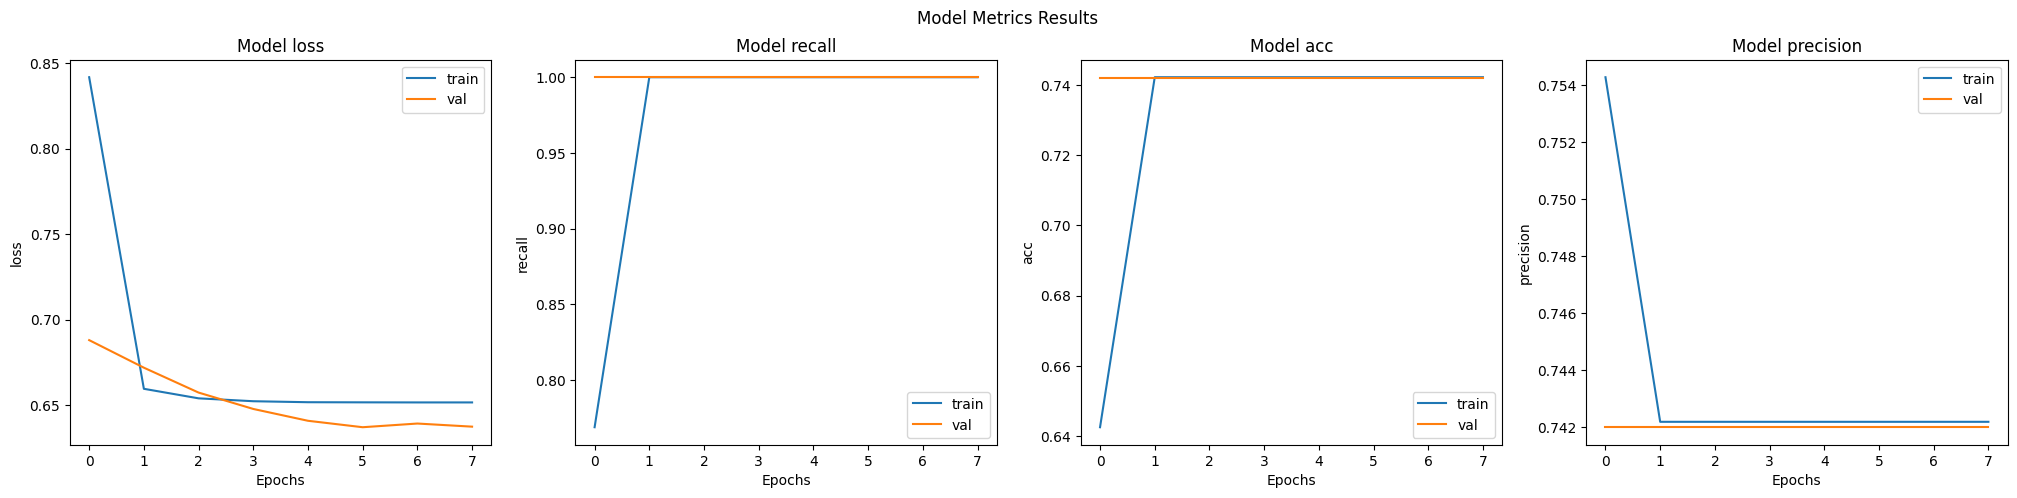

In [164]:
print("Model 9 w/o augmented data :\n")
eval_metrics(history10)

In [165]:
train_labels, train_predictions = predict_results(model_10,train_gen)
val_labels, val_predictions = predict_results(model_10,val_gen)

2023-03-29 02:23:10.612843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 20ms/step


Training Confusion Matrices:



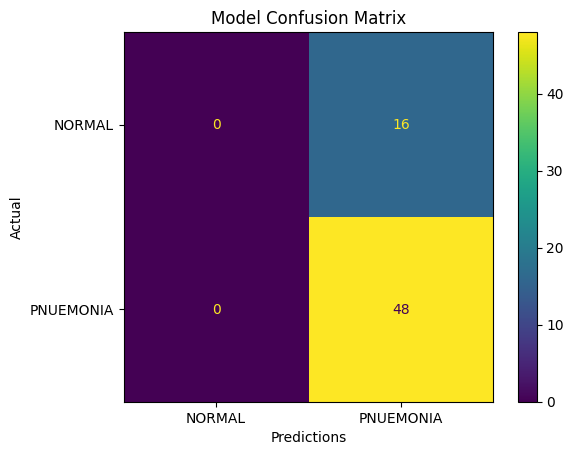

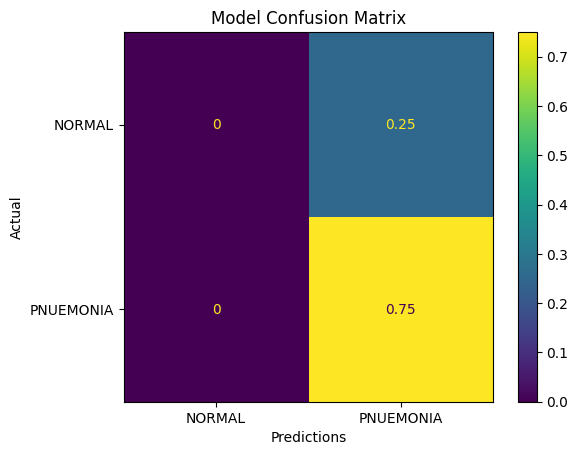

Validation Confusion Matrices:



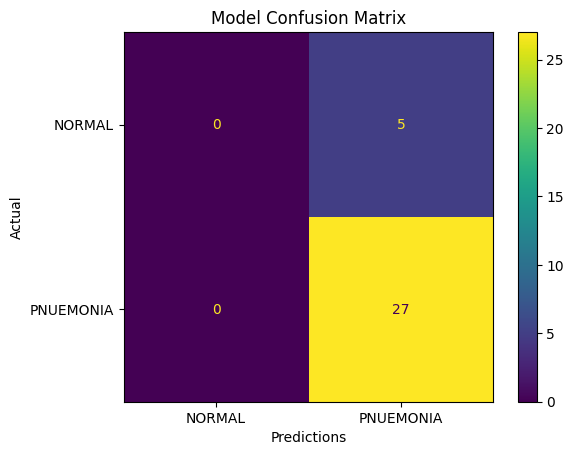

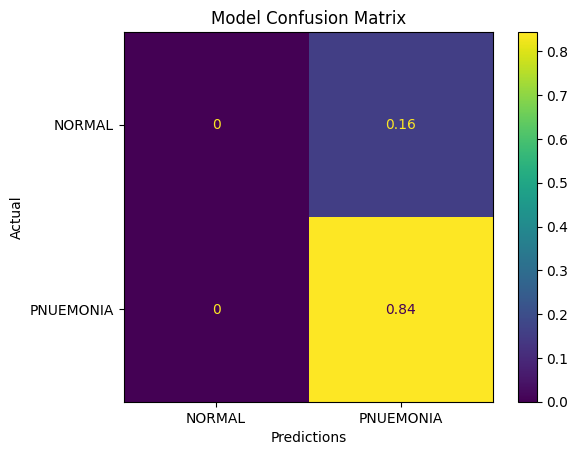

In [166]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [167]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history10)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        16
         1.0       0.75      1.00      0.86        48

    accuracy                           0.75        64
   macro avg       0.38      0.50      0.43        64
weighted avg       0.56      0.75      0.64        64



68/68 [==============================] - 25s 359ms/step - loss: 0.6374 - acc: 0.7422 - recall: 1.0000 - precision: 0.7422
Loss: 0.6374


In [168]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history10)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.84      1.00      0.92        27

    accuracy                           0.84        32
   macro avg       0.42      0.50      0.46        32
weighted avg       0.71      0.84      0.77        32



29/29 [==============================] - 6s 187ms/step - loss: 0.6374 - acc: 0.7420 - recall: 1.0000 - precision: 0.7420
Loss: 0.6374


## Transfer Model 10 Evaluation

The fine tuning effort of the model made it drastically worse. The Loss of both training and validation was extremely high. The recall and f1score on the Normal data is a 0. This model will not work.

---

# Final Model

## Best Model

The top 3 models listed all had metrics list around 1, the main differences are the loss metrics for the validation data.
Based on this information, Model 5 will be chosen 
- Model 1 (Baseline) - Loss: .0865 <br>
- **Model 5** ( 4 Conv2D Layers, 3 Dense Layers, Batchsize = 128, Epoch = 90, Dropout = .5, classweight ) - Loss: .06 <br>
- Model 9 (VGG19 Model w/ Feature Extraction) - Loss: .0714 <br>


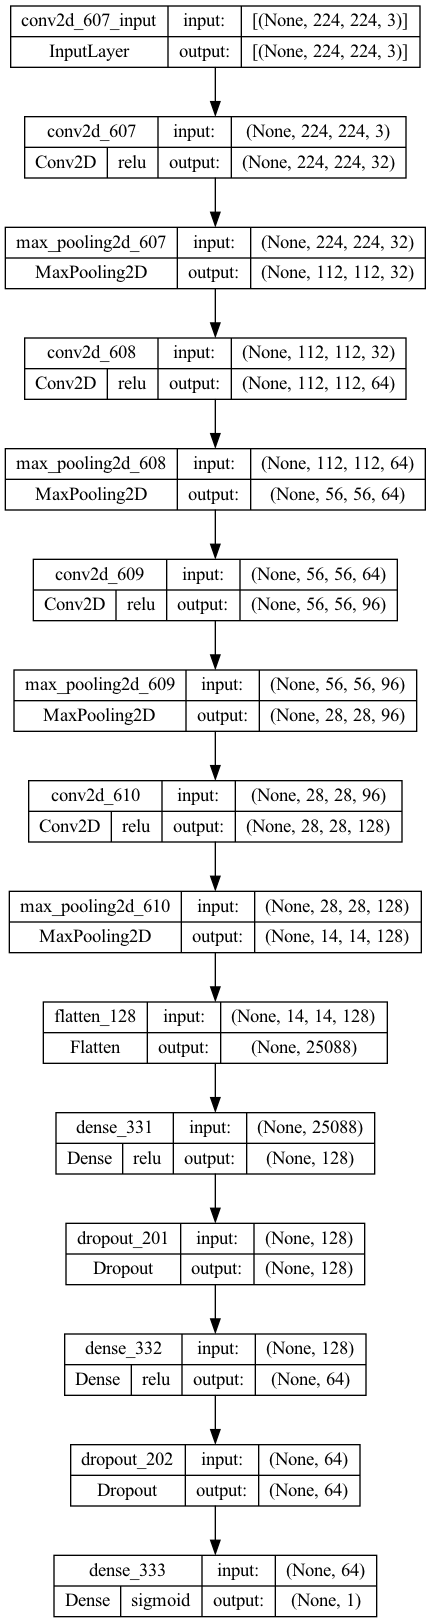

In [362]:
#Plotting model architecture
plot_model(model_5, show_shapes=True, show_layer_names=True, show_layer_activations=True, to_file = "images/CNN_Arch.png")

In [311]:
#Saving Model 5
save_file("model_5",model_5)

## Prediction

Using the chosen model and test data to predict

In [199]:
#Test data previously generated in preprocessing step, Batch Size = 624
test_labels, test_predictions = predict_results(model_5,test_gen)


2023-03-29 03:13:04.013530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 31ms/step


Test Confusion Matrices:



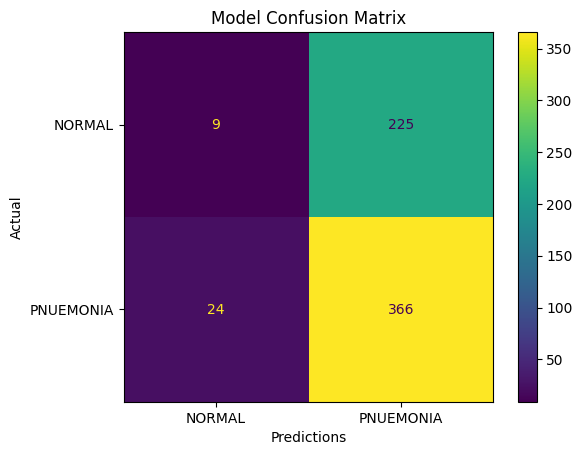

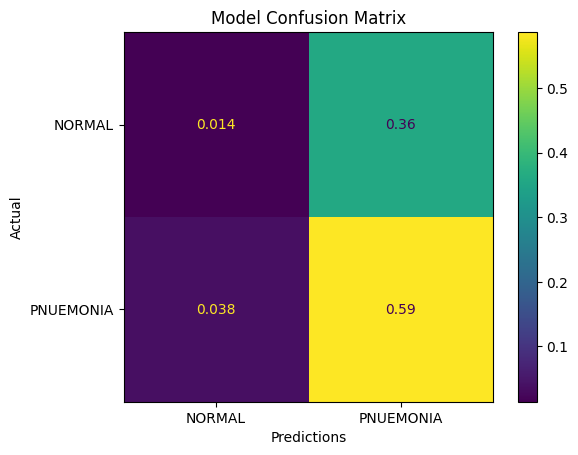

In [203]:
print("Test Confusion Matrices:\n")
conf_matrix(test_labels, test_predictions, None)
conf_matrix(test_labels, test_predictions, "all")

In [290]:
test_pred_round = np.round(test_predictions,0)
classification_report(test_labels,test_pred_round, output_dict=True)

{'0.0': {'precision': 0.2727272727272727,
  'recall': 0.038461538461538464,
  'f1-score': 0.06741573033707866,
  'support': 234},
 '1.0': {'precision': 0.6192893401015228,
  'recall': 0.9384615384615385,
  'f1-score': 0.746177370030581,
  'support': 390},
 'accuracy': 0.6009615384615384,
 'macro avg': {'precision': 0.44600830641439776,
  'recall': 0.48846153846153845,
  'f1-score': 0.4067965501838299,
  'support': 624},
 'weighted avg': {'precision': 0.489328564836179,
  'recall': 0.6009615384615384,
  'f1-score': 0.4916417551455176,
  'support': 624}}

In [217]:
#Evaluating Model With Training Data
test_results = model_5.evaluate(test_gen, return_dict= True)
test_results

1/1 [==============================] - 6s 6s/step - loss: 0.6837 - acc: 0.6010 - recall: 0.9385 - precision: 0.6193


{'loss': 0.6836573481559753,
 'acc': 0.6009615659713745,
 'recall': 0.9384615421295166,
 'precision': 0.6192893981933594}

**The model doesn't perform as well on the test data as it did on the training and validation data.** <br>

From the 624 Data pieces:<br>
    - .59% True Positive (366)<br>
    - .014% True Negative (9)<br>
    - .04% False Negative (24)<br>
    - .36% False Positive (225)<br>
    
Normal:<br>
    - Recall:.04 <br>
    - F1-Score:.07 <br>

Pneumonia:<br>
    - Recall:.94 <br>
    - F1-Score:.75 <br>
- Loss:.68
- Accuracy:.6

# Model Explainer

The Lime Module will outline images and support explanation by highlighting important areas

In [259]:
def img_array_pred(y_label, X_image_array,model,num):
    """ Inputing the data set and model to retrieve an image and prediciton results. This supports input into the 
    Lime Explainer lodule"""

    #num = np.random.randint(0,20) If want to later generate random pictures
    
    label = y_label[num]
    img = X_image_array[num]

    # Get Model Prediction
    pred = model.predict(np.array([img]))
    pred_round = np.round(pred,0)

    # Print True and Predicted Image
    if pred_round == 0:
        print('Image predicted as Normal (0)!')
    else:
        print('Image predicted as Pneumonia (1)')

    if label == 0:
        print('Image is Normal (0)!')
    else:
        print('Image is Pneumonia (1)!')

    print (f"Image Index {num} was chosen.")    
    
    return array_to_img(img)

## Analysis of True Positive Image

1/1 [==============================] - 0s 11ms/step
Image predicted as Pneumonia (1)
Image is Pneumonia (1)!
Image Index 300 was chosen.


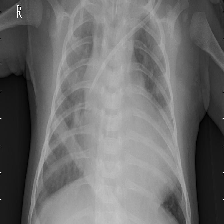

In [358]:
#Prints Prediction, True Label, Associate Predicted Image and Index
img = img_array_pred(y_test, X_test,model_5,300)
img

In [265]:
explainer = lime_image.LimeImageExplainer()

In [266]:
explanation = explainer.explain_instance(X_test[300].astype('double'), model_5.predict,batch_size=624 , 
                                         top_labels=3, hide_color=0, num_samples=1000,)

  0%|          | 0/1000 [00:00<?, ?it/s]

12/12 [==============================] - 0s 33ms/step


In [353]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)

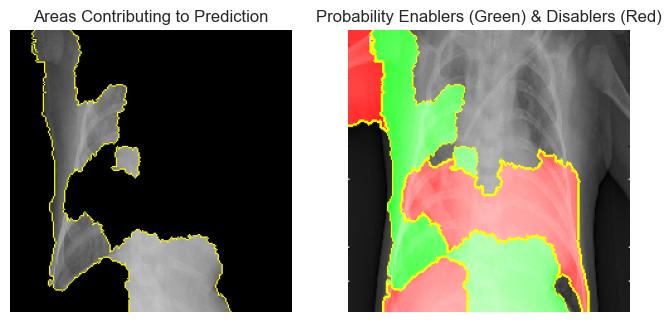

In [395]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(mark_boundaries(temp_1, mask_1))
axes[0].set_title("Areas Contributing to Prediction")
axes[1].imshow(mark_boundaries(temp_2, mask_2))
axes[1].set_title("Probability Enablers (Green) & Disablers (Red)")
axes[0].axis('off')
axes[1].axis('off')
plt.savefig('images/Lime_TP.png')

## Analysis of  False Positive Image

### img2 = img_array_pred(y_test, X_test,model_5,581)
img2

In [348]:
explainer = lime_image.LimeImageExplainer()
explanation2 = explainer.explain_instance(X_test[1].astype
                                          ("double"), model_5.predict,  
                                         top_labels=3, hide_color=None, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


In [351]:

temp_12, mask_12 = explanation2.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=True)
temp_22, mask_22 = explanation2.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)

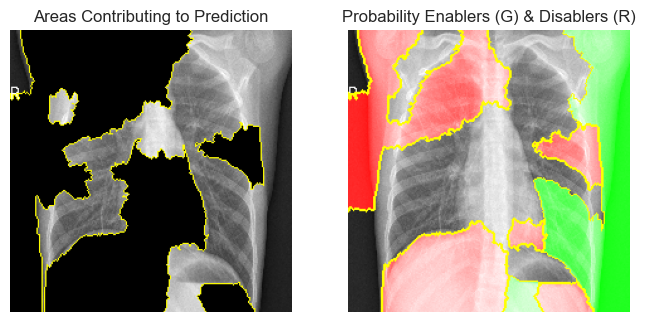

In [394]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(mark_boundaries(temp_12, mask_12))
axes[0].set_title("Areas Contributing to Prediction")
axes[1].imshow(mark_boundaries(temp_22, mask_22))
axes[1].set_title("Probability Enablers (G) & Disablers (R)")
axes[0].axis('off')
axes[1].axis('off')
plt.savefig('images/Lime_FN.png')

The model seems like it best with edges, the center areas decrease the percentage of guessing correctly.

In [ ]:
#Calculating end time
end = datetime.datetime.now()
duration = end - original_start
print('Notebook model execution: {}'.format(duration))

# Conclusion

## Reccommmendation
The intended use was to correctly identify Normal or Pneumonia diagnosis. The primary goal was to minimize False Negative diagnosis (identifying Normal when Pneumonia is present).

Hospital:

- Usage: The model is best as a learning tool and not an official diagnosis.
- Strategy: Use the model as an initial reviewer of the images.
- Staffing: The model is best used with a doctor, not standalone.

Technical:

- Scope, review and process images more beforehand
- Visualize the activation functions to see better what areas the model layers are diagnosing
- Iterate model improvement with with augmented data
- Visually inspect the images that were FN and FP.


## Limitations

Hospital:
- Important image areas
- Radiologist SME knowledge

Technical:

- Hardware and Software Compatibility (Modeling on M2 GPU Laptop)
- Hyperparameter optimization limits
- Blackbox of Hidden Layers
